## Causal Inference

To understand potential causal relationships between lifestyle, demographic, and clinical variables and the onset of chronic diseases (Diabetes, Cardiovascular Disease, Kidney Disease), we apply several causal discovery algorithms to selected features from the NHANES dataset.

### Algorithms Used

We use three widely adopted structure learning methods for causal discovery, each with distinct assumptions and inference strategies:

1. **PC Algorithm**  
   - A constraint-based method that infers the causal structure by systematically testing for conditional independencies.
   - Assumes causal sufficiency and the faithfulness condition.
   - Returns a partially directed acyclic graph (CPDAG) representing the Markov equivalence class of DAGs.

2. **Greedy Equivalence Search (GES)**  
   - A score-based method that explores the space of equivalence classes of DAGs.
   - Optimizes a scoring criterion such as the Bayesian Information Criterion (BIC) to find the most plausible causal structure.
   - Tends to be more robust to noise in independence tests compared to constraint-based approaches.

3. **LiNGAM (Linear Non-Gaussian Acyclic Model)**  
   - A functional causal model assuming linear relationships and non-Gaussian noise.
   - Capable of inferring causal directionality from observational data, unlike methods that rely solely on conditional independence.
   - Well-suited for continuous-valued variables.

These methods are implemented using the [`causal-learn`](https://github.com/py-why/causal-learn) Python library.



---

# Diabetes

---

In [2]:
import pickle
from collections import Counter

# Step 1: Initialize a Counter to track feature appearances
feature_counter = Counter()

# Reading the dictionary from the file
with open('feature_sets_diabetes.pkl', 'rb') as f:
    loaded_feature_sets = pickle.load(f)

# Printing to verify
print(loaded_feature_sets)
for method, features in loaded_feature_sets.items():
    feature_counter.update(features)


features_in_at_least_2_methods = [feature for feature, count in feature_counter.items() if count >= 2]

features_in_at_least_2_methods = [feature for feature in features_in_at_least_2_methods if feature not in ('RXQ050', 'RXQ033', 'BPQ101D')]
# Printing the result
print("Features that appeared in at least 2 methods:", features_in_at_least_2_methods)


{'Model-Based': ['LBXGH', 'DR1HELP', 'BAARFC31', 'RXQ050', 'RXQ033', 'DRD370EQ', 'BAQ321B', 'OCQ180', 'RHQ078', 'PAD800', 'DR1TALCO', 'MCQ160B', 'DRD370AQ', 'DRD370DQ', 'BAQ321C', 'LBXRDW', 'LBDGLUSI', 'BPQ080', 'LUARXNC', 'DR1TNIAC', 'WTDR2D', 'BPQ020', 'LBDBANO', 'FNQ530', 'LBDBPBSI', 'LBXTC', 'DPQ100', 'KIQ022', 'DR1TFDFE', 'SMQ770', 'DR1TVB12', 'WHD010', 'BPXOPLS2', 'DR1TP184', 'BMXARMC', 'BPQ101D', 'DR1TLZ', 'LBXES1', 'DR1TCOPP', 'DRD340', 'SMD460', 'IMQ060', 'BAXPF42', 'DR1TPHOS', 'LBXDHE', 'DRD370SQ', 'PAD810Qcombined', 'BAXTC32', 'LBXFER', 'BAARFC22'], 'Domain': ['RIDAGEYR', 'RIAGENDR', 'RIDRETH3', 'DMDEDUC2', 'INDFMMPI', 'INDFMPIR', 'BMXBMI', 'BMXWAIST', 'BMXHIP', 'DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR', 'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 'DR1TCHOL', 'DR1TCAFF', 'DR1_320Z', 'PAD680', 'LBXGLU', 'LBDINSI', 'LBXAGP', 'LBDHDD', 'SMQ040', 'ALQ121', 'SLD012', 'SLD013', 'DPQ100', 'PAD790Qcombined', 'PAD810Qcombined'], 'Correlation': ['LBXGH', 'LBXGLU', 'LBDGLUSI', 'RXQ050', '

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz, fastkci, chisq
from sklearn.impute import KNNImputer

# Step 1: Load NHANES dataset
df = pd.read_csv("NHANES_SAMPLE.csv")  # Ensure the file path is correct
columns = features_in_at_least_2_methods + ["DIQ010"]# Load diabetes-related variable names and explanations

# Step 2: Keep only selected columns (features + target)

# Step 3: Convert DIQ010 to binary (1 = diabetes, 0 = non-diabetes)
df["DIQ010"] = df["DIQ010"].apply(lambda x: 1 if x == 1 else 0)

# Handle activity columns
activity_columns = [("PAD790Q", "PAD790U"), ("PAD810Q", "PAD810U")]  # List of pairs
for freq_col, unit_col in activity_columns:
    if freq_col in df.columns and unit_col in df.columns:
        df[f"{freq_col}combined"] = df[freq_col].astype(str) + "_" + df[unit_col].astype(str)  # Concatenate values
        df.drop([freq_col, unit_col], axis=1, inplace=True)  # Drop original columns

df = df[columns]

# Step 6: Remove constant columns (if any)
df = df.loc[:, df.nunique() > 1]

# Step 7: Convert categorical columns to numerical
for col in df.select_dtypes(include=["object", "category"]).columns:
    df[col] = df[col].astype("category").cat.codes

# Step 8: Convert dataframe to numpy array
knn_imputer = KNNImputer(n_neighbors=2)
df = df.dropna(axis=1, how='all')
df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)


data = df.to_numpy()
# Step 9: Run PC algorithm for causal discovery
cg = pc(data, alpha=0.05, indep_test=fisherz, max_condition_set=4)



/home/maiya.goloburda/.conda/envs/ml808/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_3071270/1332545223.py:37: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)
Depth=9, working on node 22: 100%|██████████| 23/23 [00:00<00:00, 2107.64it/s]


{'LBXGH': 'LBXGH', 'BAQ321C': 'BAQ321C', 'LBXRDW': 'LBXRDW', 'LBDGLUSI': 'LBDGLUSI', 'BPQ080': 'BPQ080', 'BPQ020': 'BPQ020', 'LBXTC': 'LBXTC', 'DPQ100': 'DPQ100', 'BPXOPLS2': 'BPXOPLS2', 'BMXARMC': 'BMXARMC', 'LBXDHE': 'LBXDHE', 'PAD810Qcombined': 'PAD810Qcombined', 'RIDAGEYR': 'RIDAGEYR', 'DMDEDUC2': 'DMDEDUC2', 'BMXBMI': 'BMXBMI', 'BMXWAIST': 'BMXWAIST', 'LBXGLU': 'LBXGLU', 'LBDINSI': 'LBDINSI', 'LBDHDD': 'LBDHDD', 'HUQ010': 'HUQ010', 'FNQ440': 'FNQ440', 'LBDTCSI': 'LBDTCSI', 'DIQ010': 'DIQ010'}


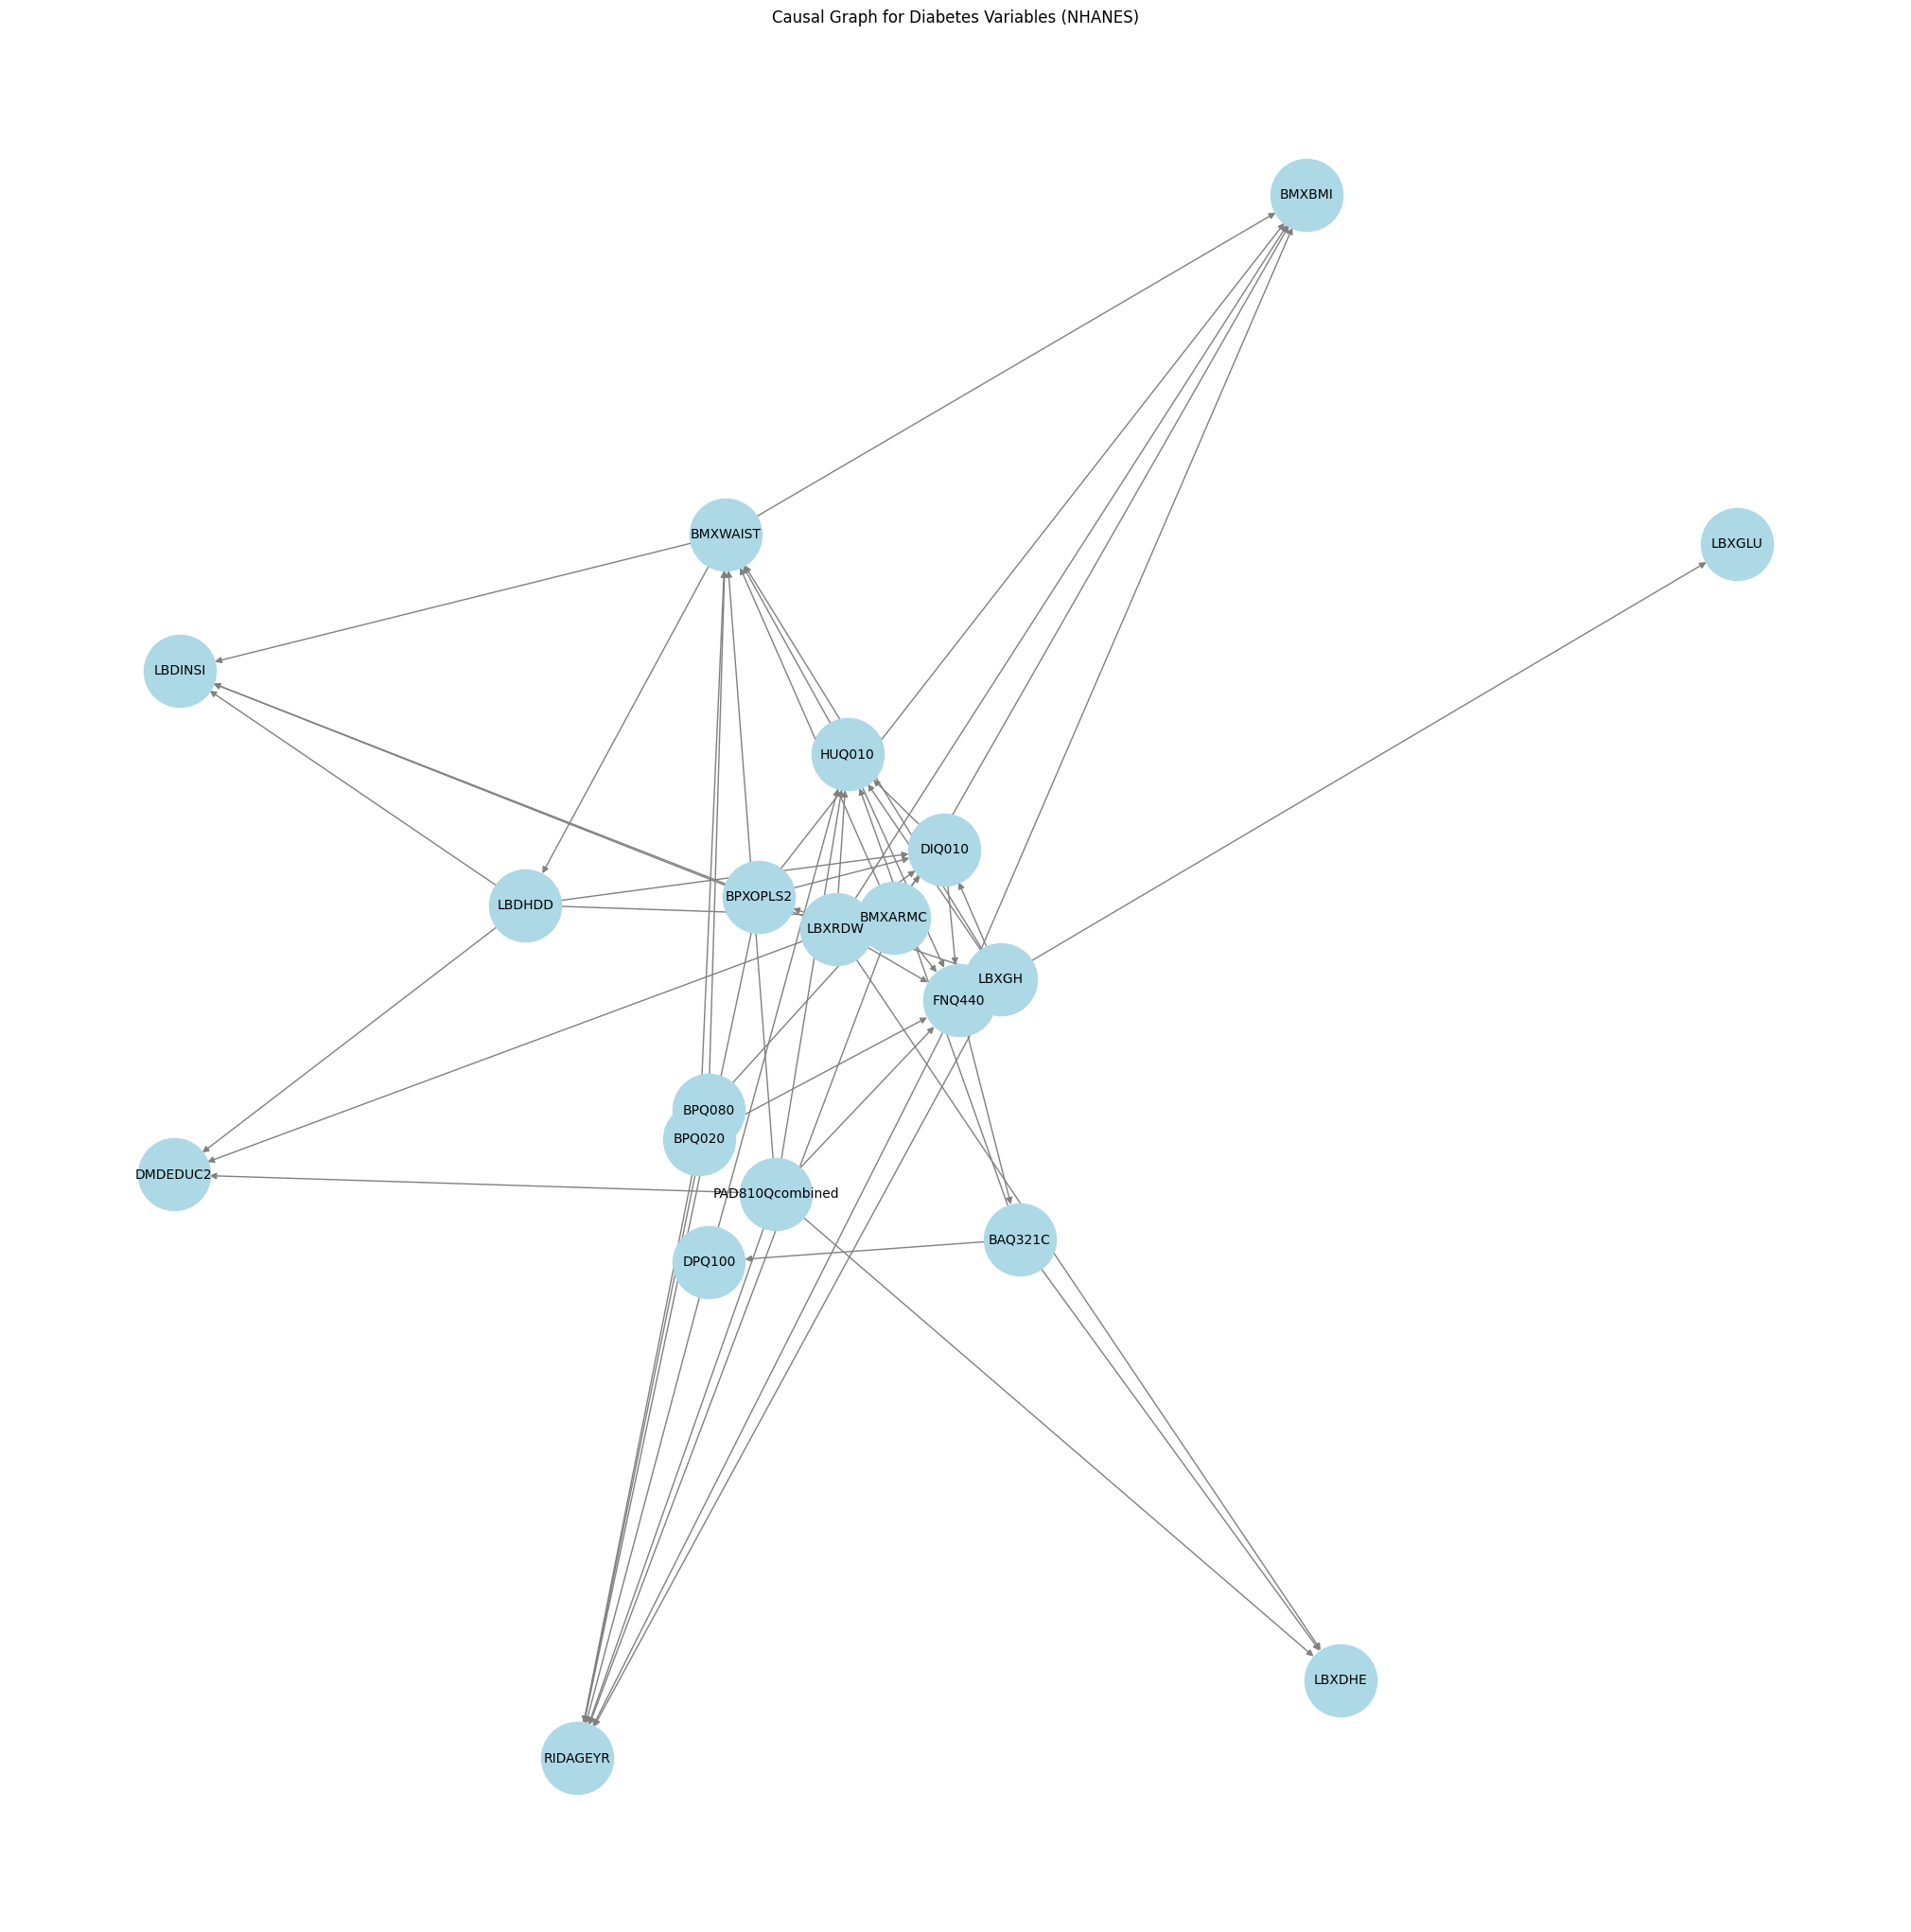

In [4]:
G_pc_diabetes = nx.DiGraph()  # Create a directed graph
node_labels = {col: col for col in df.columns}  # Map column names to themselves
print(node_labels)

for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if cg.G.graph[i, j] == 1:  # If there is an edge
            feature_i = df.columns[i]  # Get the feature name using the index
            feature_j = df.columns[j]  # Get the feature name using the index
            if feature_i in df.columns and feature_j in df.columns:  # Ensure the feature exists in df.columns
                G_pc_diabetes.add_edge(feature_i, feature_j)  # Add edge using column names
node_labels = {key: value for key, value in node_labels.items() if key in G_pc_diabetes.nodes}

pos = nx.spring_layout(G_pc_diabetes, seed=42)

plt.figure(figsize=(20, 20))
nx.draw(G_pc_diabetes, pos, labels=node_labels, with_labels=True, node_size=3000,
        node_color="lightblue", edge_color="gray", font_size=10)
plt.title("Causal Graph for Diabetes Variables (NHANES)")
plt.show()


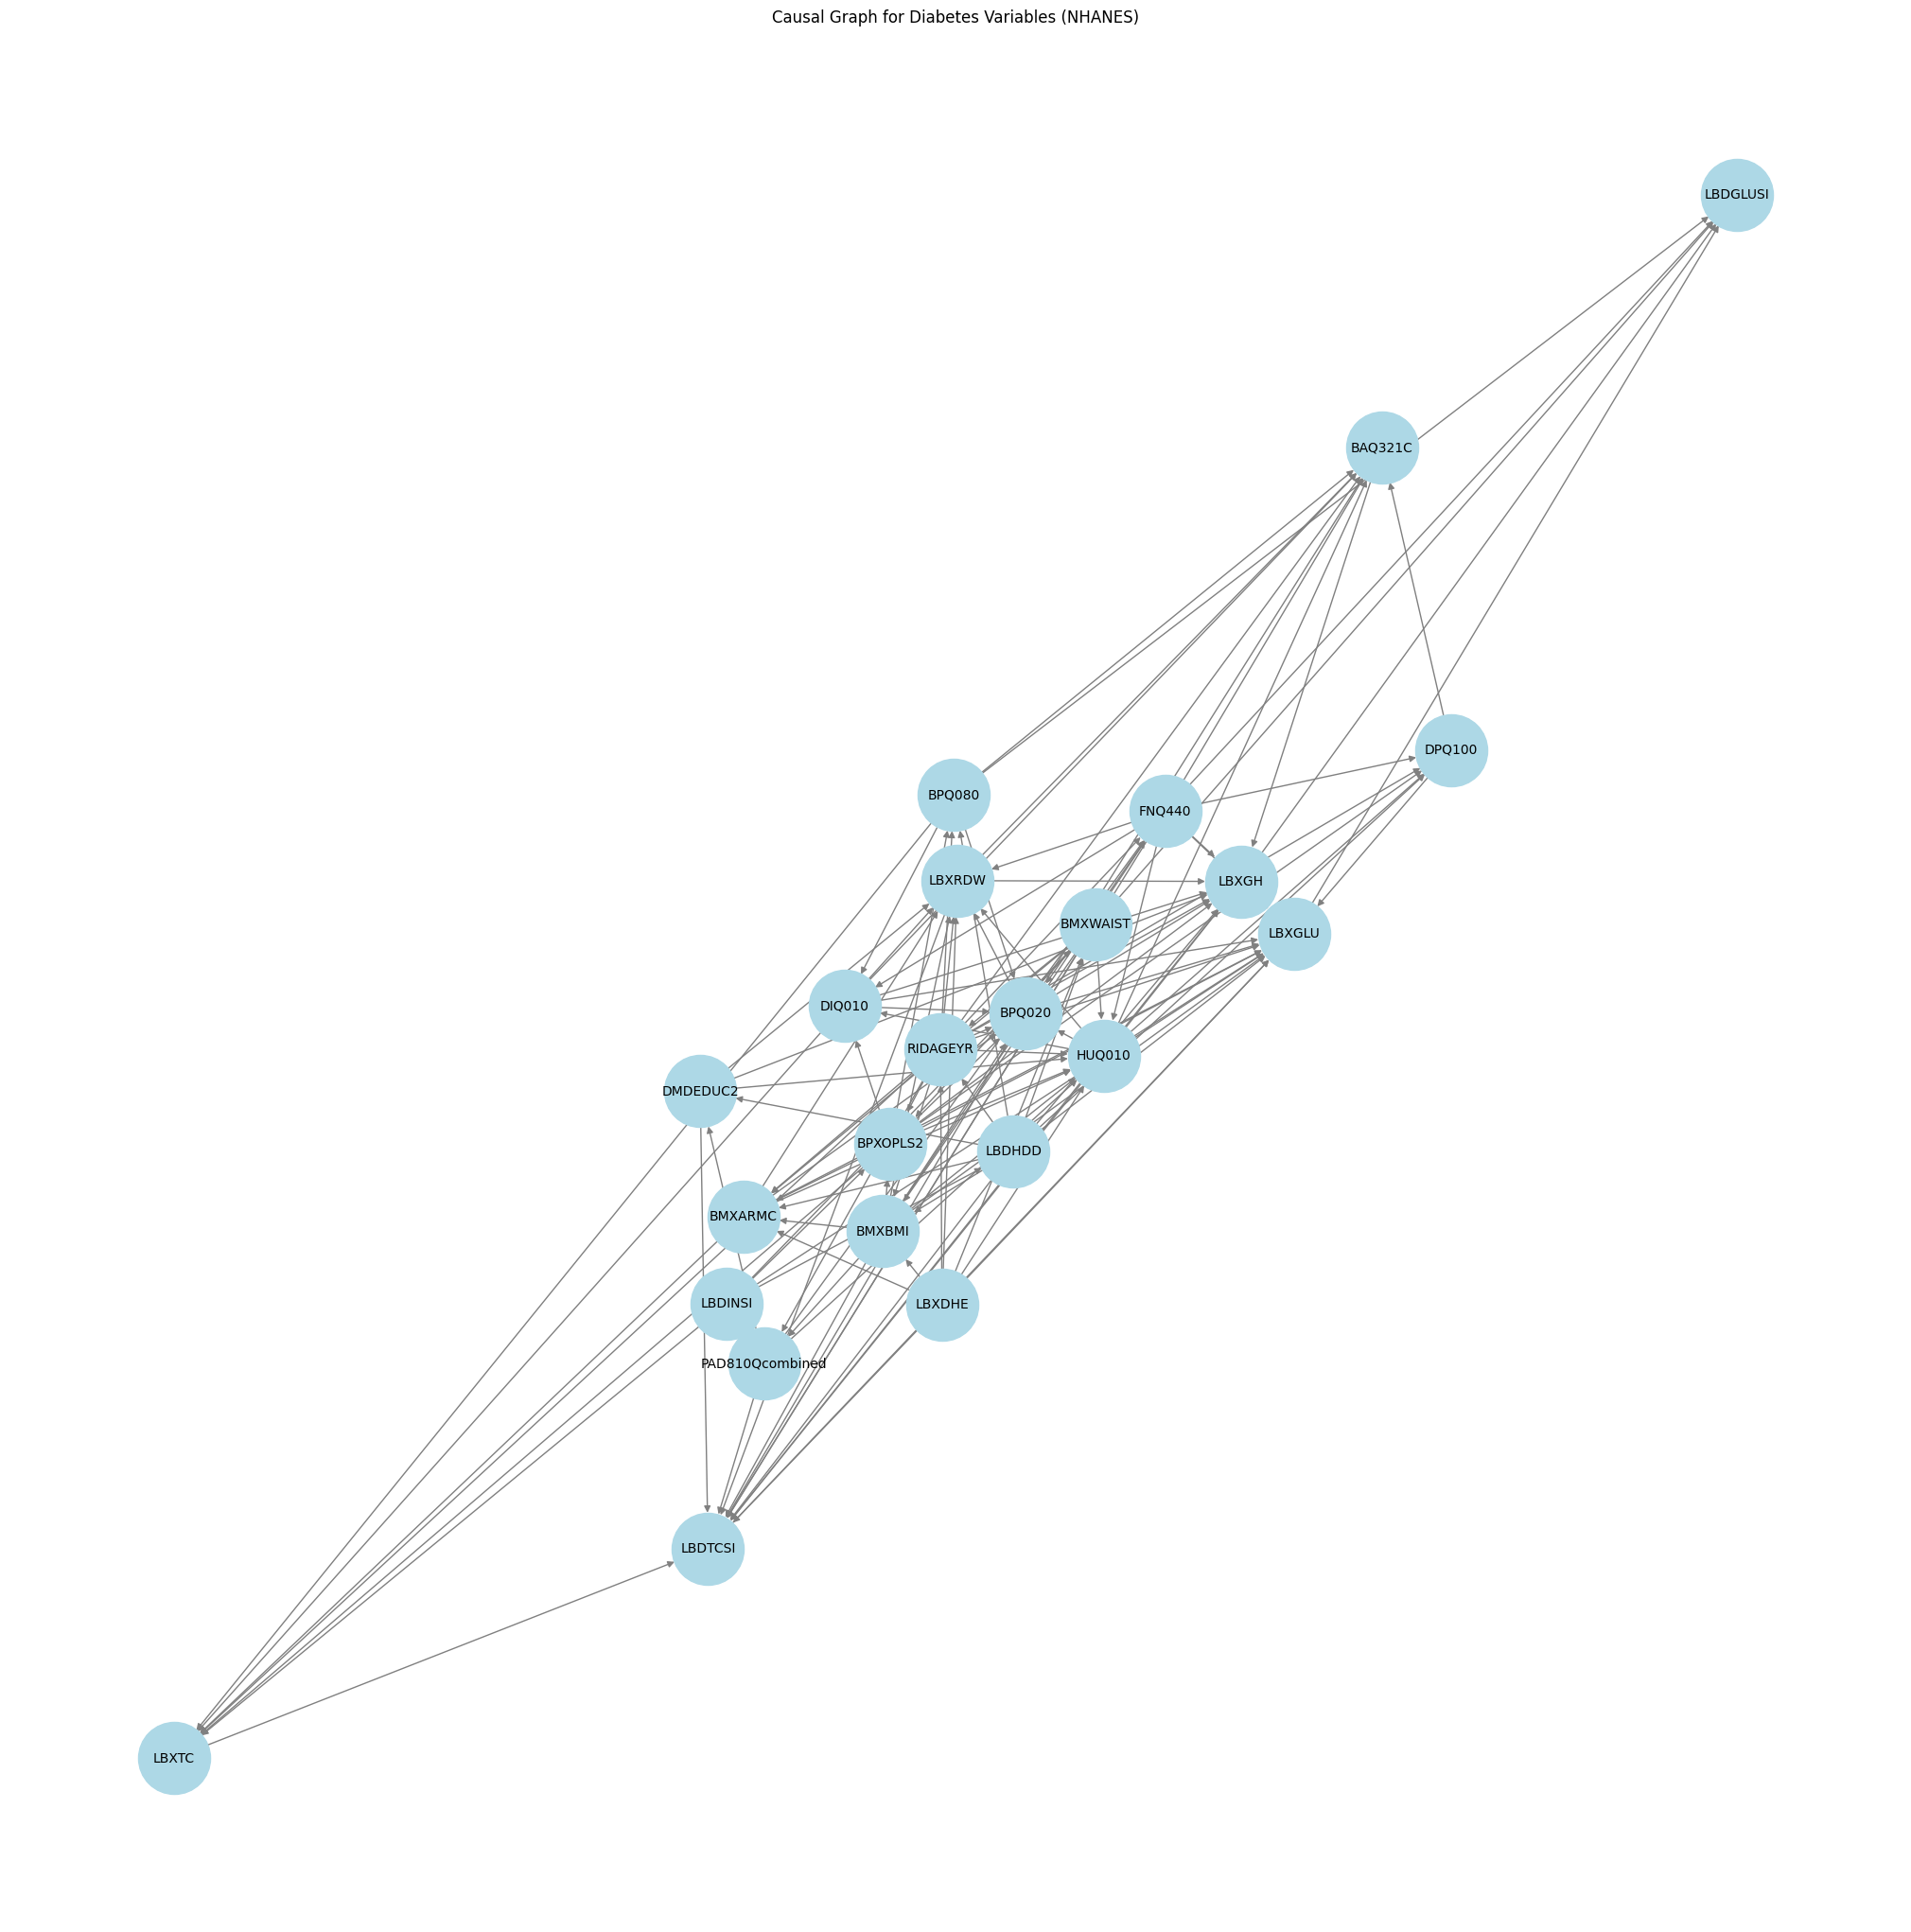

In [5]:
from causallearn.search.FCMBased import lingam

lingam = lingam.ICALiNGAM( random_state=42)
lingam.fit(data)

# Step 10: Get the causal graph from the learned coefficients
edges = lingam.adjacency_matrix_  # This gives you the adjacency matrix representing the causal graph

# Step 11: Convert causal graph to NetworkX graph
G_lingam_diabetes = nx.DiGraph()  # Create a directed graph
node_labels = {col: col for col in df.columns}  # Use column names as node labels

# Add edges to the graph
for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if edges[i, j] != 0:  # If there is a causal relationship
            G_lingam_diabetes.add_edge(df.columns[i], df.columns[j])  # Add edge from column i to column j

# Step 12: Generate `pos` for visualization
pos = nx.spring_layout(G_lingam_diabetes, seed=42)

# Step 13: Visualize the causal graph using column names as labels
plt.figure(figsize=(20, 20))
nx.draw(G_lingam_diabetes, pos, labels=node_labels, with_labels=True, node_size=3000,
        node_color="lightblue", edge_color="gray", font_size=10)
plt.title("Causal Graph for Diabetes Variables (NHANES)")
plt.show()


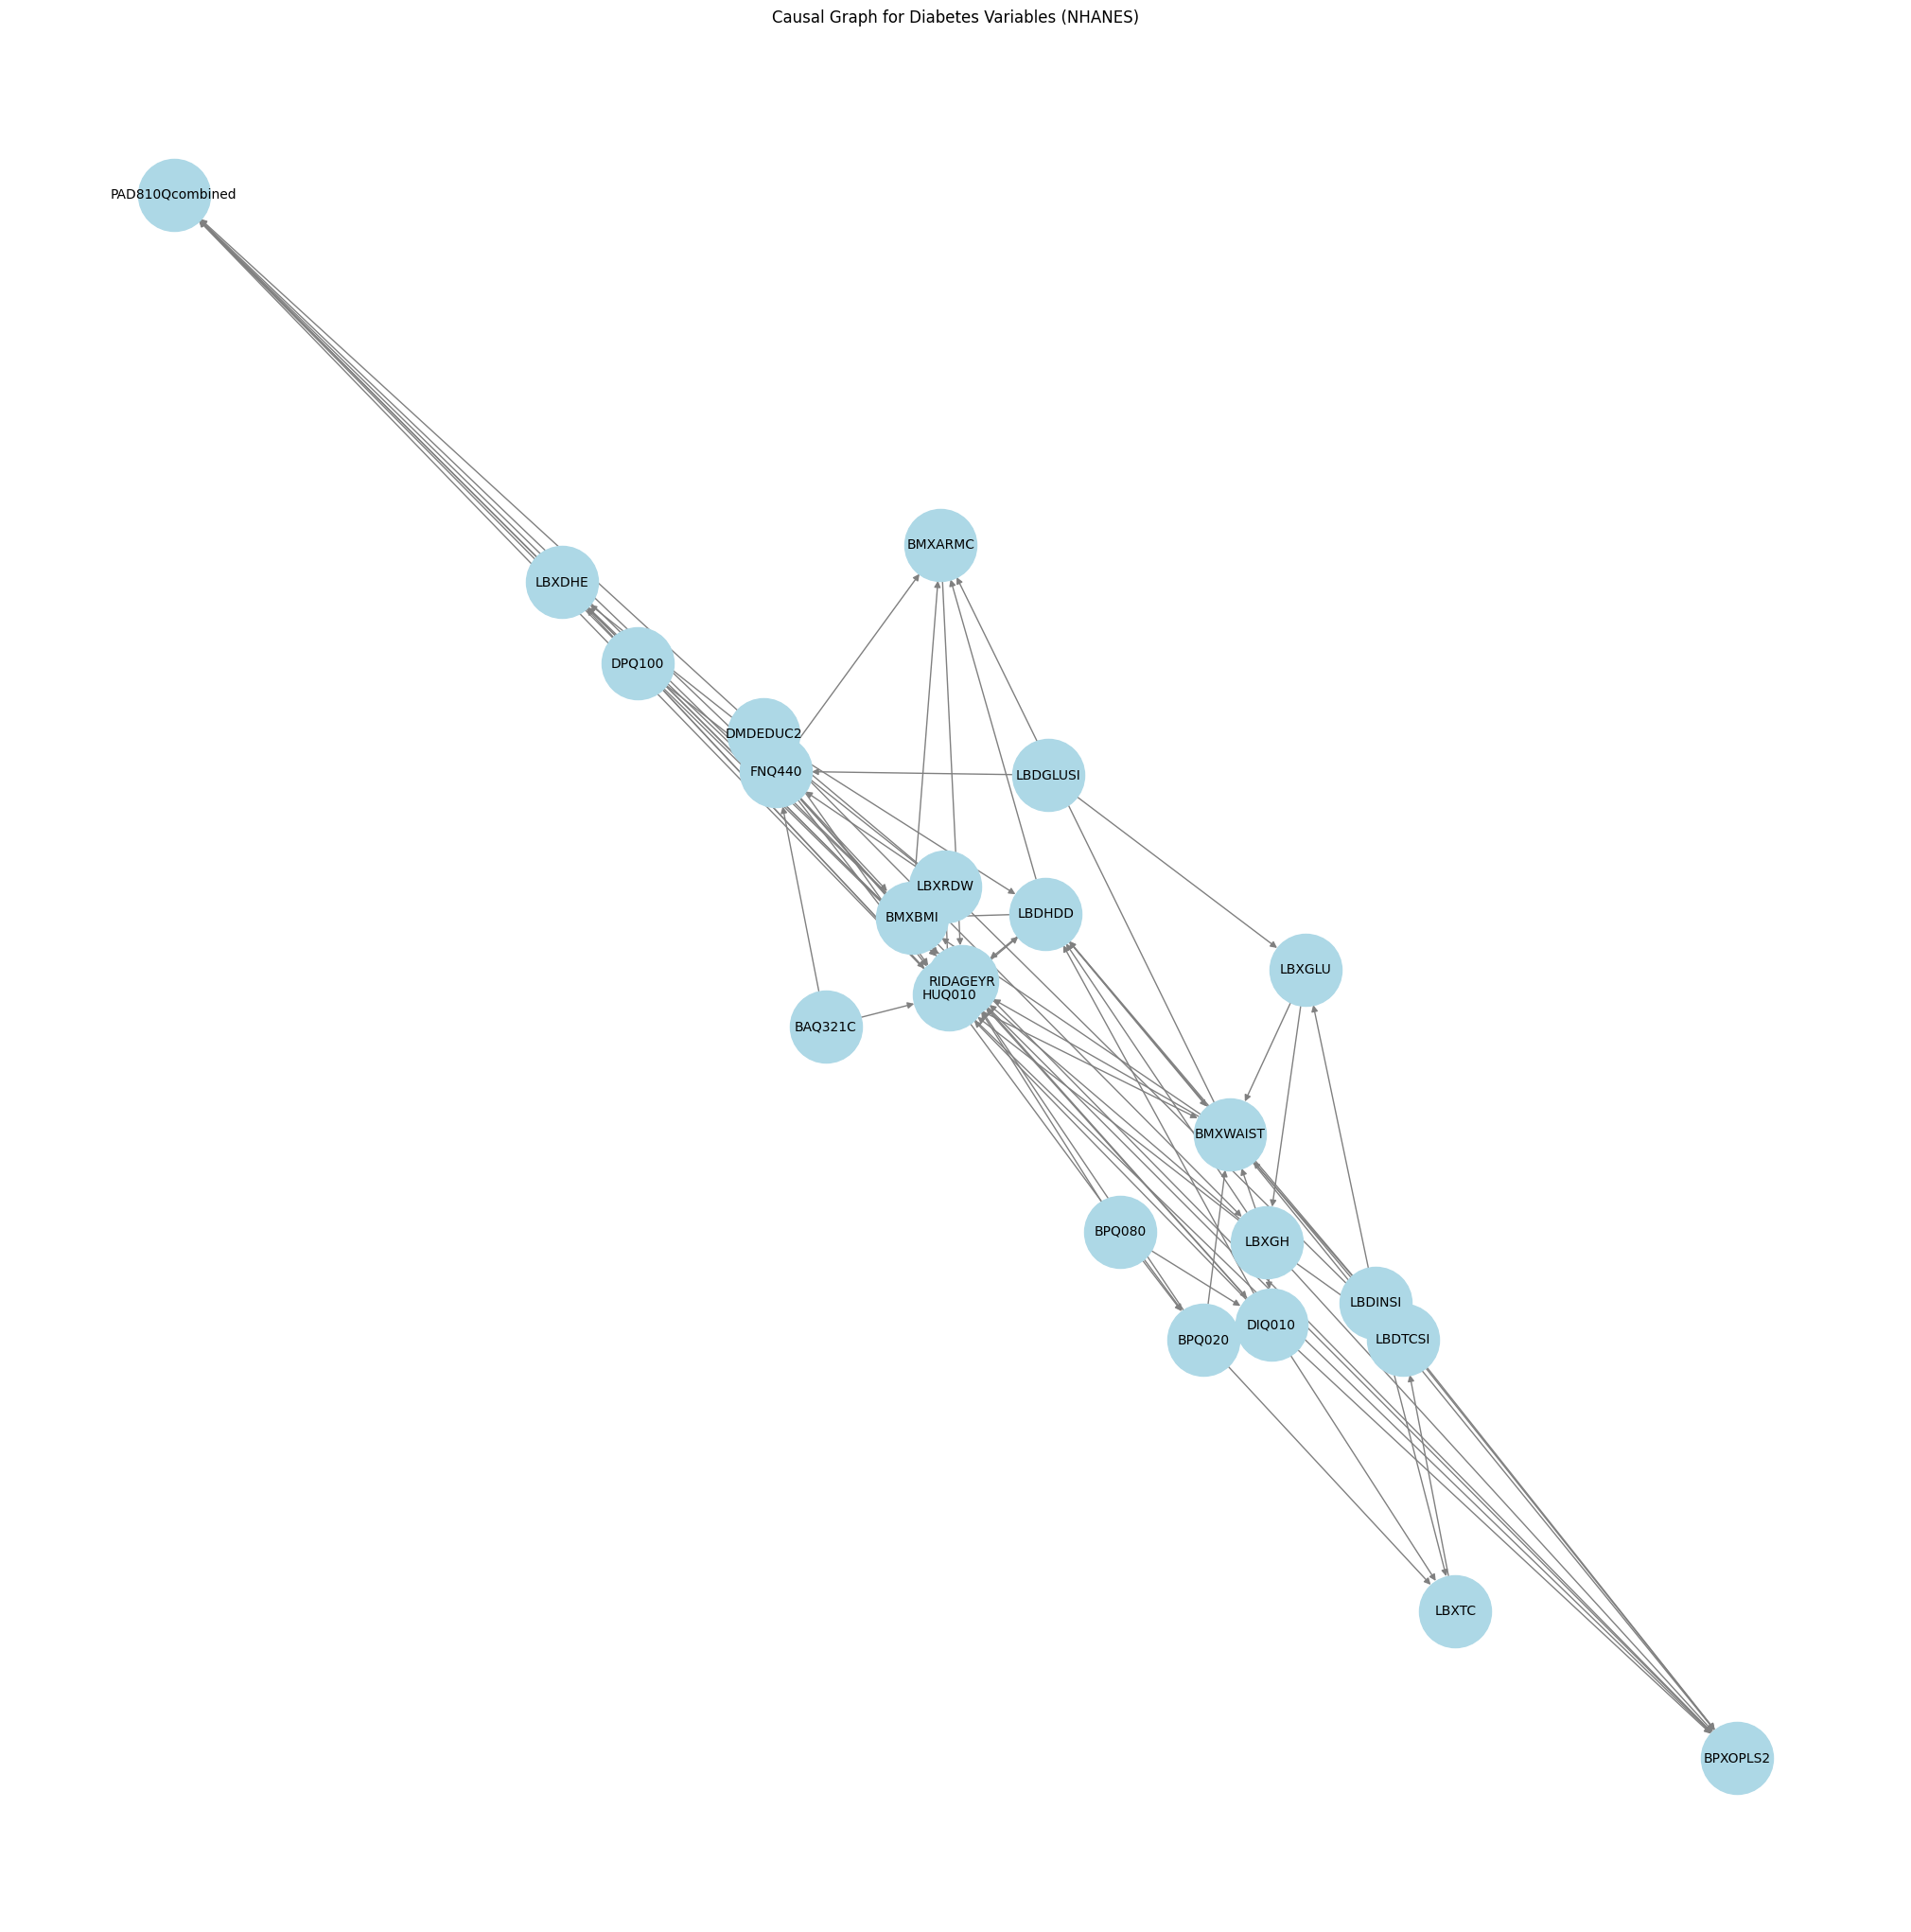

In [6]:
from causallearn.search.ScoreBased.GES import ges


ges = ges(data)

edges = ges["G"].graph 

G_ges_diabetes = nx.DiGraph()  # Create a directed graph
node_labels = {col: col for col in df.columns}  # Use column names as node labels

# Add edges to the graph
# node_labels = {col: col for col in df.columns}  # Use column names as node labels

# Add edges to the graph
for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if edges[i, j] == 1:  # If there is a causal relationship i → j
            G_ges_diabetes.add_edge(df.columns[i], df.columns[j])  # Add edge from column i to column j
        elif edges[i, j] == -1:  # If there is a causal relationship j → i
            G_ges_diabetes.add_edge(df.columns[j], df.columns[i])  # Add edge from column j to column i

# Step 12: Generate `pos` for visualization
pos = nx.spring_layout(G_ges_diabetes, seed=42)

# Step 13: Visualize the causal graph using column names as labels
plt.figure(figsize=(20, 20))
nx.draw(G_ges_diabetes, pos, labels=node_labels, with_labels=True, node_size=3000,
        node_color="lightblue", edge_color="gray", font_size=10)
plt.title("Causal Graph for Diabetes Variables (NHANES)")
plt.show()


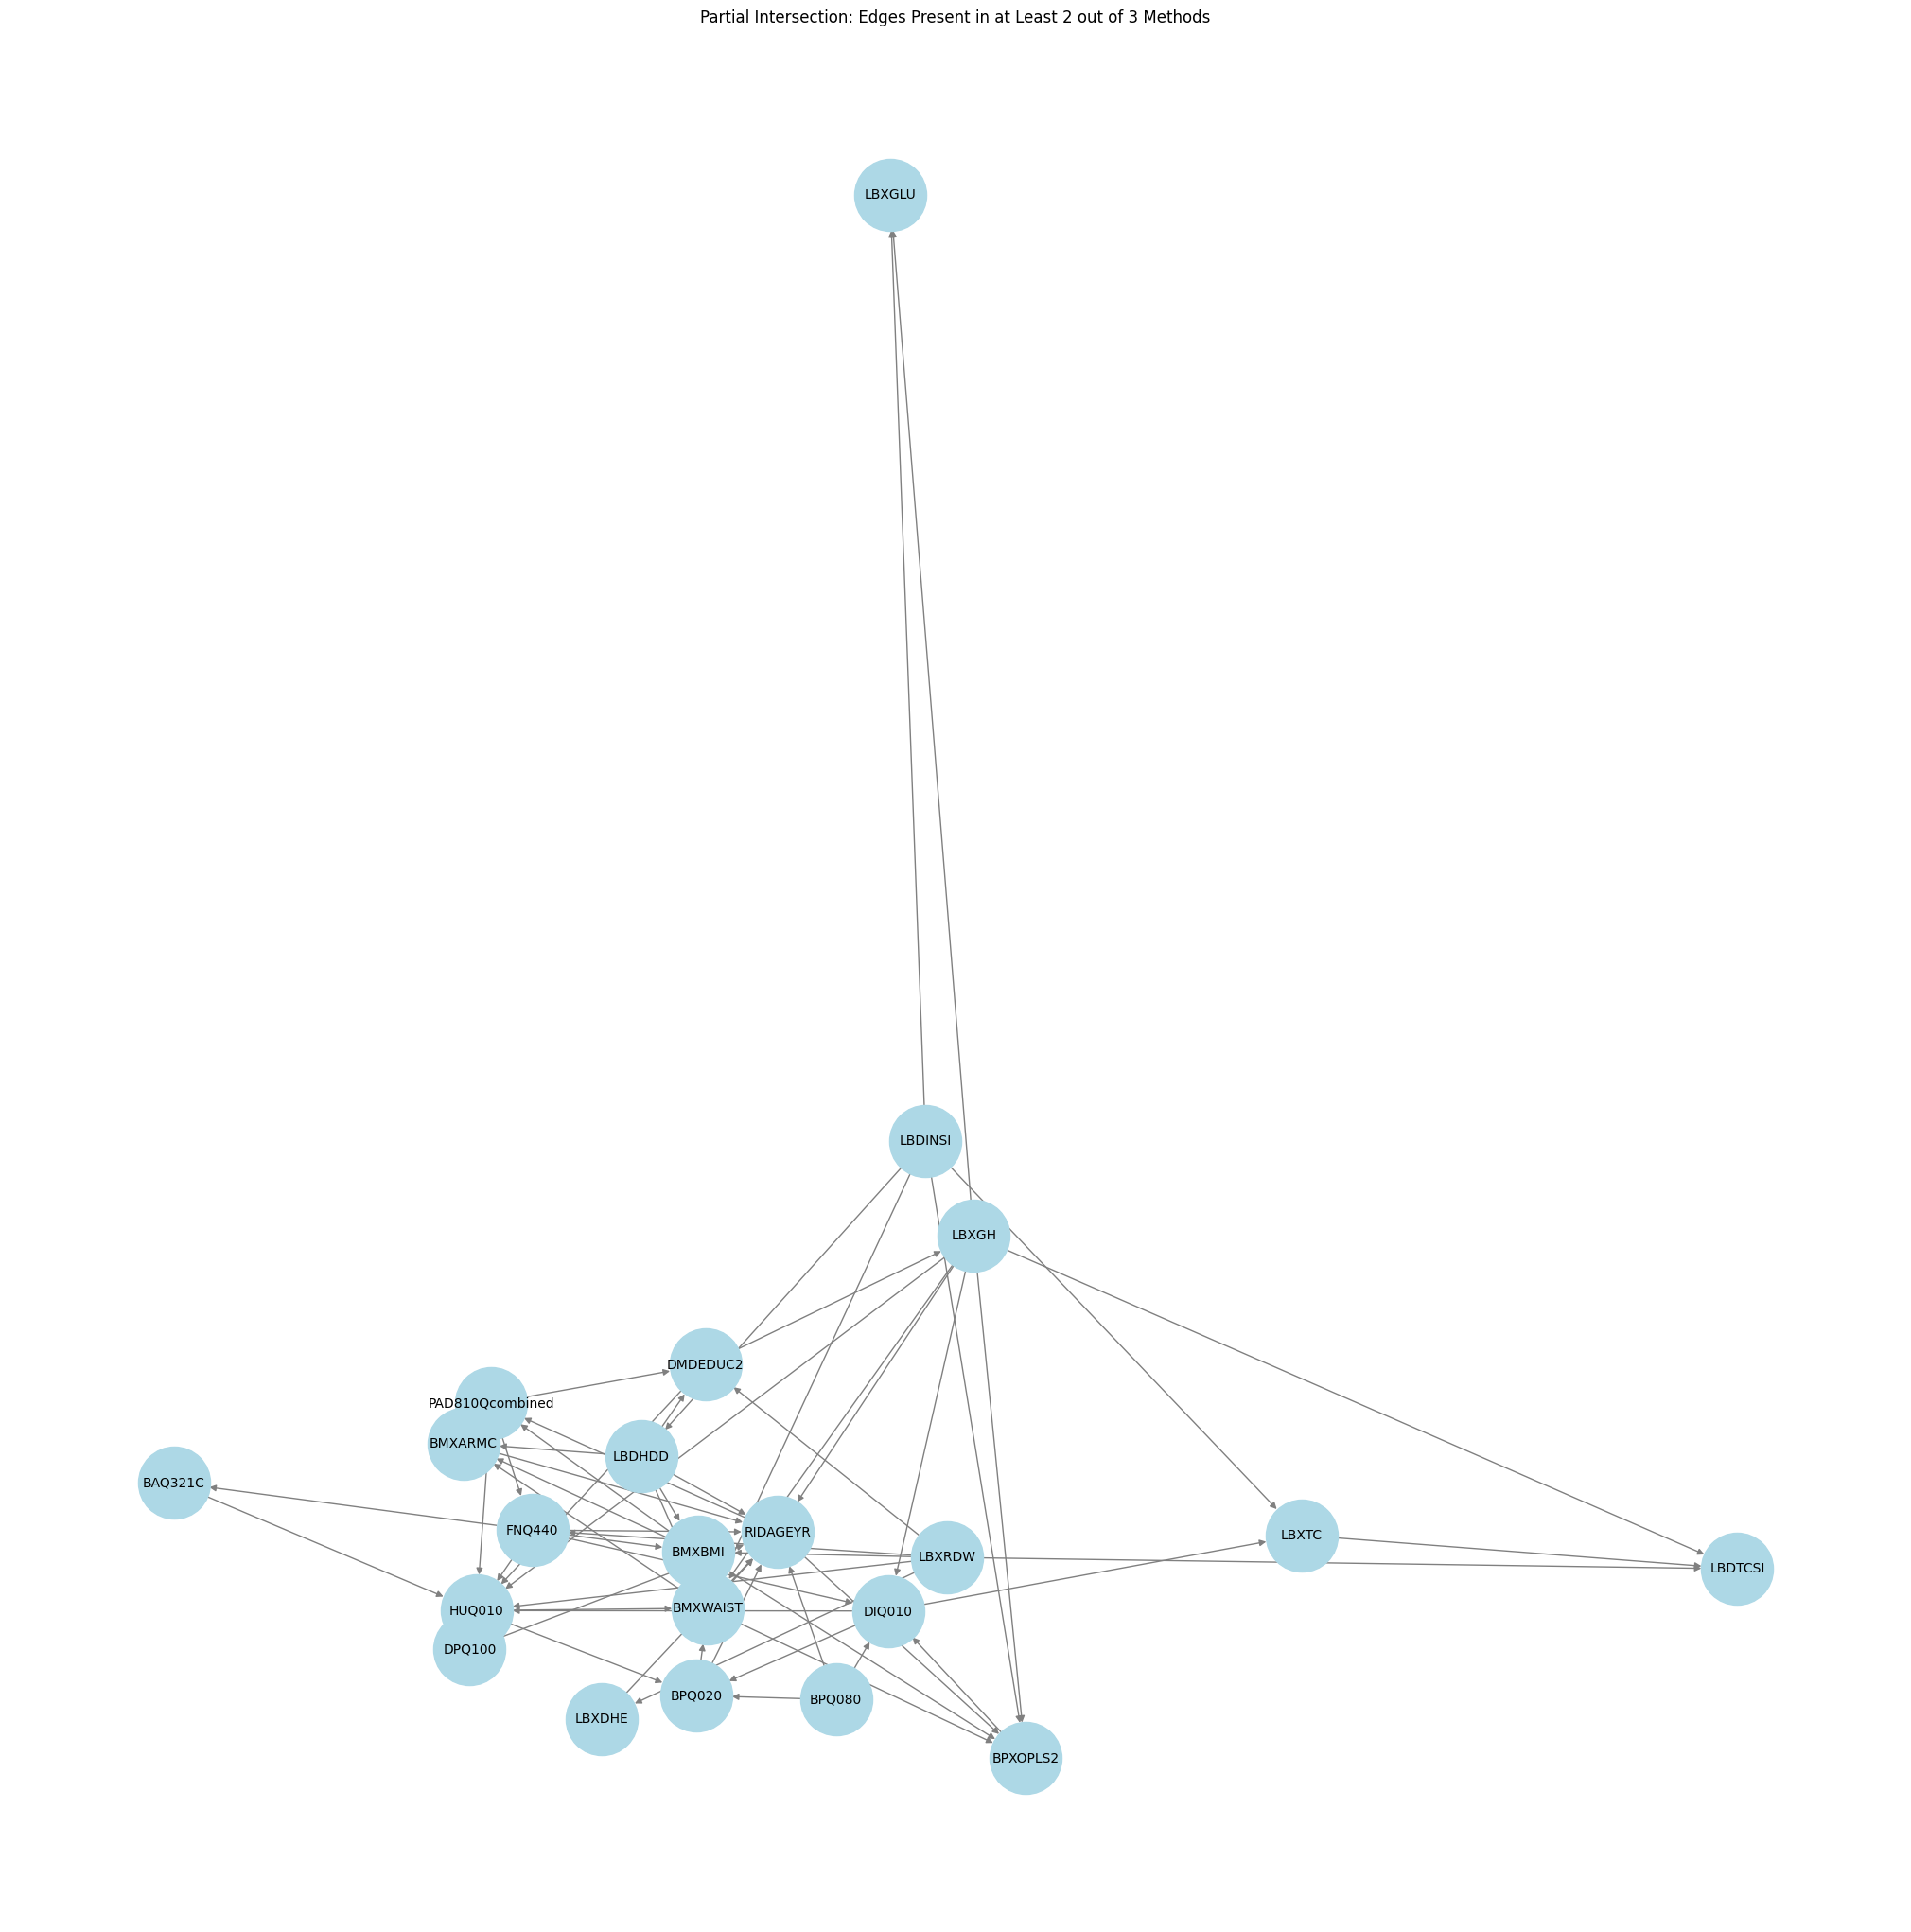

In [7]:
from collections import Counter

# Convert all edge lists to a common format: (source, target)
edges_pc = list(G_pc_diabetes.edges())
edges_lingam = list(G_lingam_diabetes.edges())
edges_ges = list(G_ges_diabetes.edges())

# Combine all edges from all graphs
all_edges = edges_pc + edges_lingam + edges_ges

# Count occurrences of each edge
edge_counts = Counter(all_edges)

# Filter edges that appear in at least 2 graphs
partial_edges = [edge for edge, count in edge_counts.items() if count >= 2]

# Create a new graph with only those partial edges
partial_graph_diabetes = nx.DiGraph()
partial_graph_diabetes.add_edges_from(partial_edges)

# Add nodes explicitly (in case some nodes are disconnected)
partial_graph_diabetes.add_nodes_from(G_pc_diabetes.nodes())

# Visualize
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(partial_graph_diabetes, seed=42)
nx.draw(partial_graph_diabetes, pos, with_labels=True, node_size=3000,
        node_color="lightblue", edge_color="gray", font_size=10)
plt.title("Partial Intersection: Edges Present in at Least 2 out of 3 Methods")
plt.show()


In [10]:
def extract_causal_roles(graph, node='DIQ010'):
    return {
        'Direct Causes (Parents)': sorted(list(graph.predecessors(node))),
        'Indirect Causes (Ancestors excl. direct)': sorted(list(set(nx.ancestors(graph, node)) - set(graph.predecessors(node)))),
        'Effects (Children)': sorted(list(graph.successors(node)))
    }

# Suppose you have graphs per disease per method like this
graphs = {
    ('Diabetes', 'PC'): G_pc_diabetes,
    ('Diabetes', 'LiNGAM'): G_lingam_diabetes,
    ('Diabetes', 'GES'): G_ges_diabetes,
    # Add more entries here: e.g., ('CVD', 'PC'): G_cvd_pc, ...
}

# Create the structure for the table
summary = {}

for (disease, method), graph in graphs.items():
    roles = extract_causal_roles(graph, node='DIQ010')  # or other node for CVD/KIDNEY
    for role_type, variables in roles.items():
        key = role_type
        col = f"{disease} ({method})"
        if key not in summary:
            summary[key] = {}
        summary[key][col] = ', '.join(variables) if variables else '—'

# Convert to DataFrame
df_summary = pd.DataFrame(summary).T  # Transpose so rows are relationship types
df_summary.fillna('—', inplace=True)

# Preview
pd.set_option('display.max_colwidth', None)

# Convert the DataFrame to LaTeX format after adjusting the option.
latex_code = df_summary.to_latex(index=True)

with open("causal_summary_table.tex", "w") as f:
    f.write(latex_code)

/tmp/ipykernel_3071270/1009798887.py:36: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_code = df_summary.to_latex(index=True)


---

# Kidney disease

---

In [11]:
import pickle
from collections import Counter

# Step 1: Initialize a Counter to track feature appearances
feature_counter = Counter()

# Reading the dictionary from the file
with open('feature_sets_kidney.pkl', 'rb') as f:
    loaded_feature_sets = pickle.load(f)

# Printing to verify
print(loaded_feature_sets)
for method, features in loaded_feature_sets.items():
    feature_counter.update(features)


features_in_at_least_2_methods = [feature for feature, count in feature_counter.items() if count >= 2]

features_in_at_least_2_methods = [feature for feature in features_in_at_least_2_methods if feature not in ('RXQ050', 'RXQ033')]
# Printing the result
print("Features that appeared in at least 2 methods:", features_in_at_least_2_methods)


{'Model-Based': ['RXQ050', 'FNQ430', 'LBDNENO', 'ALQ130', 'DMQMILIZ', 'DR1TP204', 'LBXSF1SI', 'LUANMTGP', 'DR1TNIAC', 'DRD350GQ', 'WTPH2YR', 'DIQ050', 'DR1TVARA', 'OCQ383', 'INDFMMPC', 'INDFMMPI', 'DR1TMOIS', 'BPXOSY1', 'RHQ200', 'IND310', 'SMQ770', 'OCQ215', 'DRD370KQ', 'PHASUPMN', 'OHQ680', 'LBDBCDSI', 'BAARFC41', 'LBXRBCSI', 'LUXSIQRM', 'LBXSF6SI', 'DR1TZINC', 'DPQ050', 'LBXPLTSI', 'HUQ010', 'LBXTC', 'DRD370OQ', 'RXQ520', 'DRD370G', 'MCQ220', 'OHQ620', 'DPQ080', 'DR1TATOC', 'BAXPF42', 'SMQ040', 'BAXPF52', 'LBXDHE', 'BPQ020', 'PHAGUMHR', 'PHAALCHR', 'RHQ332'], 'Domain': ['RIDAGEYR', 'RIAGENDR', 'RIDRETH3', 'DMDEDUC2', 'INDFMMPI', 'INDFMPIR', 'BMXBMI', 'BMXWAIST', 'BMXHIP', 'DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR', 'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 'DR1TCAFF', 'DR1_320Z', 'PAD680', 'LBXHGB', 'LBXHSCRP', 'LBXGLU', 'LBDINSI', 'SMQ040', 'ALQ121', 'SLD012', 'SLD013', 'DPQ100', 'LBDTHGSI', 'LBXBPB', 'PAD790Qcombined', 'PAD810Qcombined'], 'Correlation': ['LBXSF6SI', 'DIQ010', 'RXQ05

In [12]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz, fastkci, chisq
from sklearn.impute import KNNImputer

# Step 1: Load NHANES dataset
df = pd.read_csv("NHANES_SAMPLE.csv")  # Ensure the file path is correct
columns = features_in_at_least_2_methods + ["KIQ022"]# Load KD-related variable names and explanations

# Step 2: Keep only selected columns (features + target)

# Step 3: Convert DIQ010 to binary (1 = kidney problems)
df["KIQ022"] = df["KIQ022"].apply(lambda x: 1 if x == 1 else 0)

# Handle activity columns
activity_columns = [("PAD790Q", "PAD790U"), ("PAD810Q", "PAD810U")]  # List of pairs
for freq_col, unit_col in activity_columns:
    if freq_col in df.columns and unit_col in df.columns:
        df[f"{freq_col}combined"] = df[freq_col].astype(str) + "_" + df[unit_col].astype(str)  # Concatenate values
        df.drop([freq_col, unit_col], axis=1, inplace=True)  # Drop original columns

df = df[columns]

# Step 6: Remove constant columns (if any)
df = df.loc[:, df.nunique() > 1]

# Step 7: Convert categorical columns to numerical
for col in df.select_dtypes(include=["object", "category"]).columns:
    df[col] = df[col].astype("category").cat.codes

# Step 8: Convert dataframe to numpy array
knn_imputer = KNNImputer(n_neighbors=2)
df = df.dropna(axis=1, how='all')
df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)


data = df.to_numpy()
# Step 9: Run PC algorithm for causal discovery
cg = pc(data, alpha=0.05, indep_test=fisherz, max_condition_set=3)



/tmp/ipykernel_3071270/2881367897.py:37: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)
Depth=7, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 1235.63it/s]


{'FNQ430': 'FNQ430', 'INDFMMPI': 'INDFMMPI', 'OHQ680': 'OHQ680', 'LBXRBCSI': 'LBXRBCSI', 'LUXSIQRM': 'LUXSIQRM', 'LBXSF6SI': 'LBXSF6SI', 'HUQ010': 'HUQ010', 'LBXTC': 'LBXTC', 'SMQ040': 'SMQ040', 'LBXDHE': 'LBXDHE', 'BPQ020': 'BPQ020', 'RIDAGEYR': 'RIDAGEYR', 'PAD810Qcombined': 'PAD810Qcombined', 'DIQ010': 'DIQ010', 'KIQ022': 'KIQ022'}


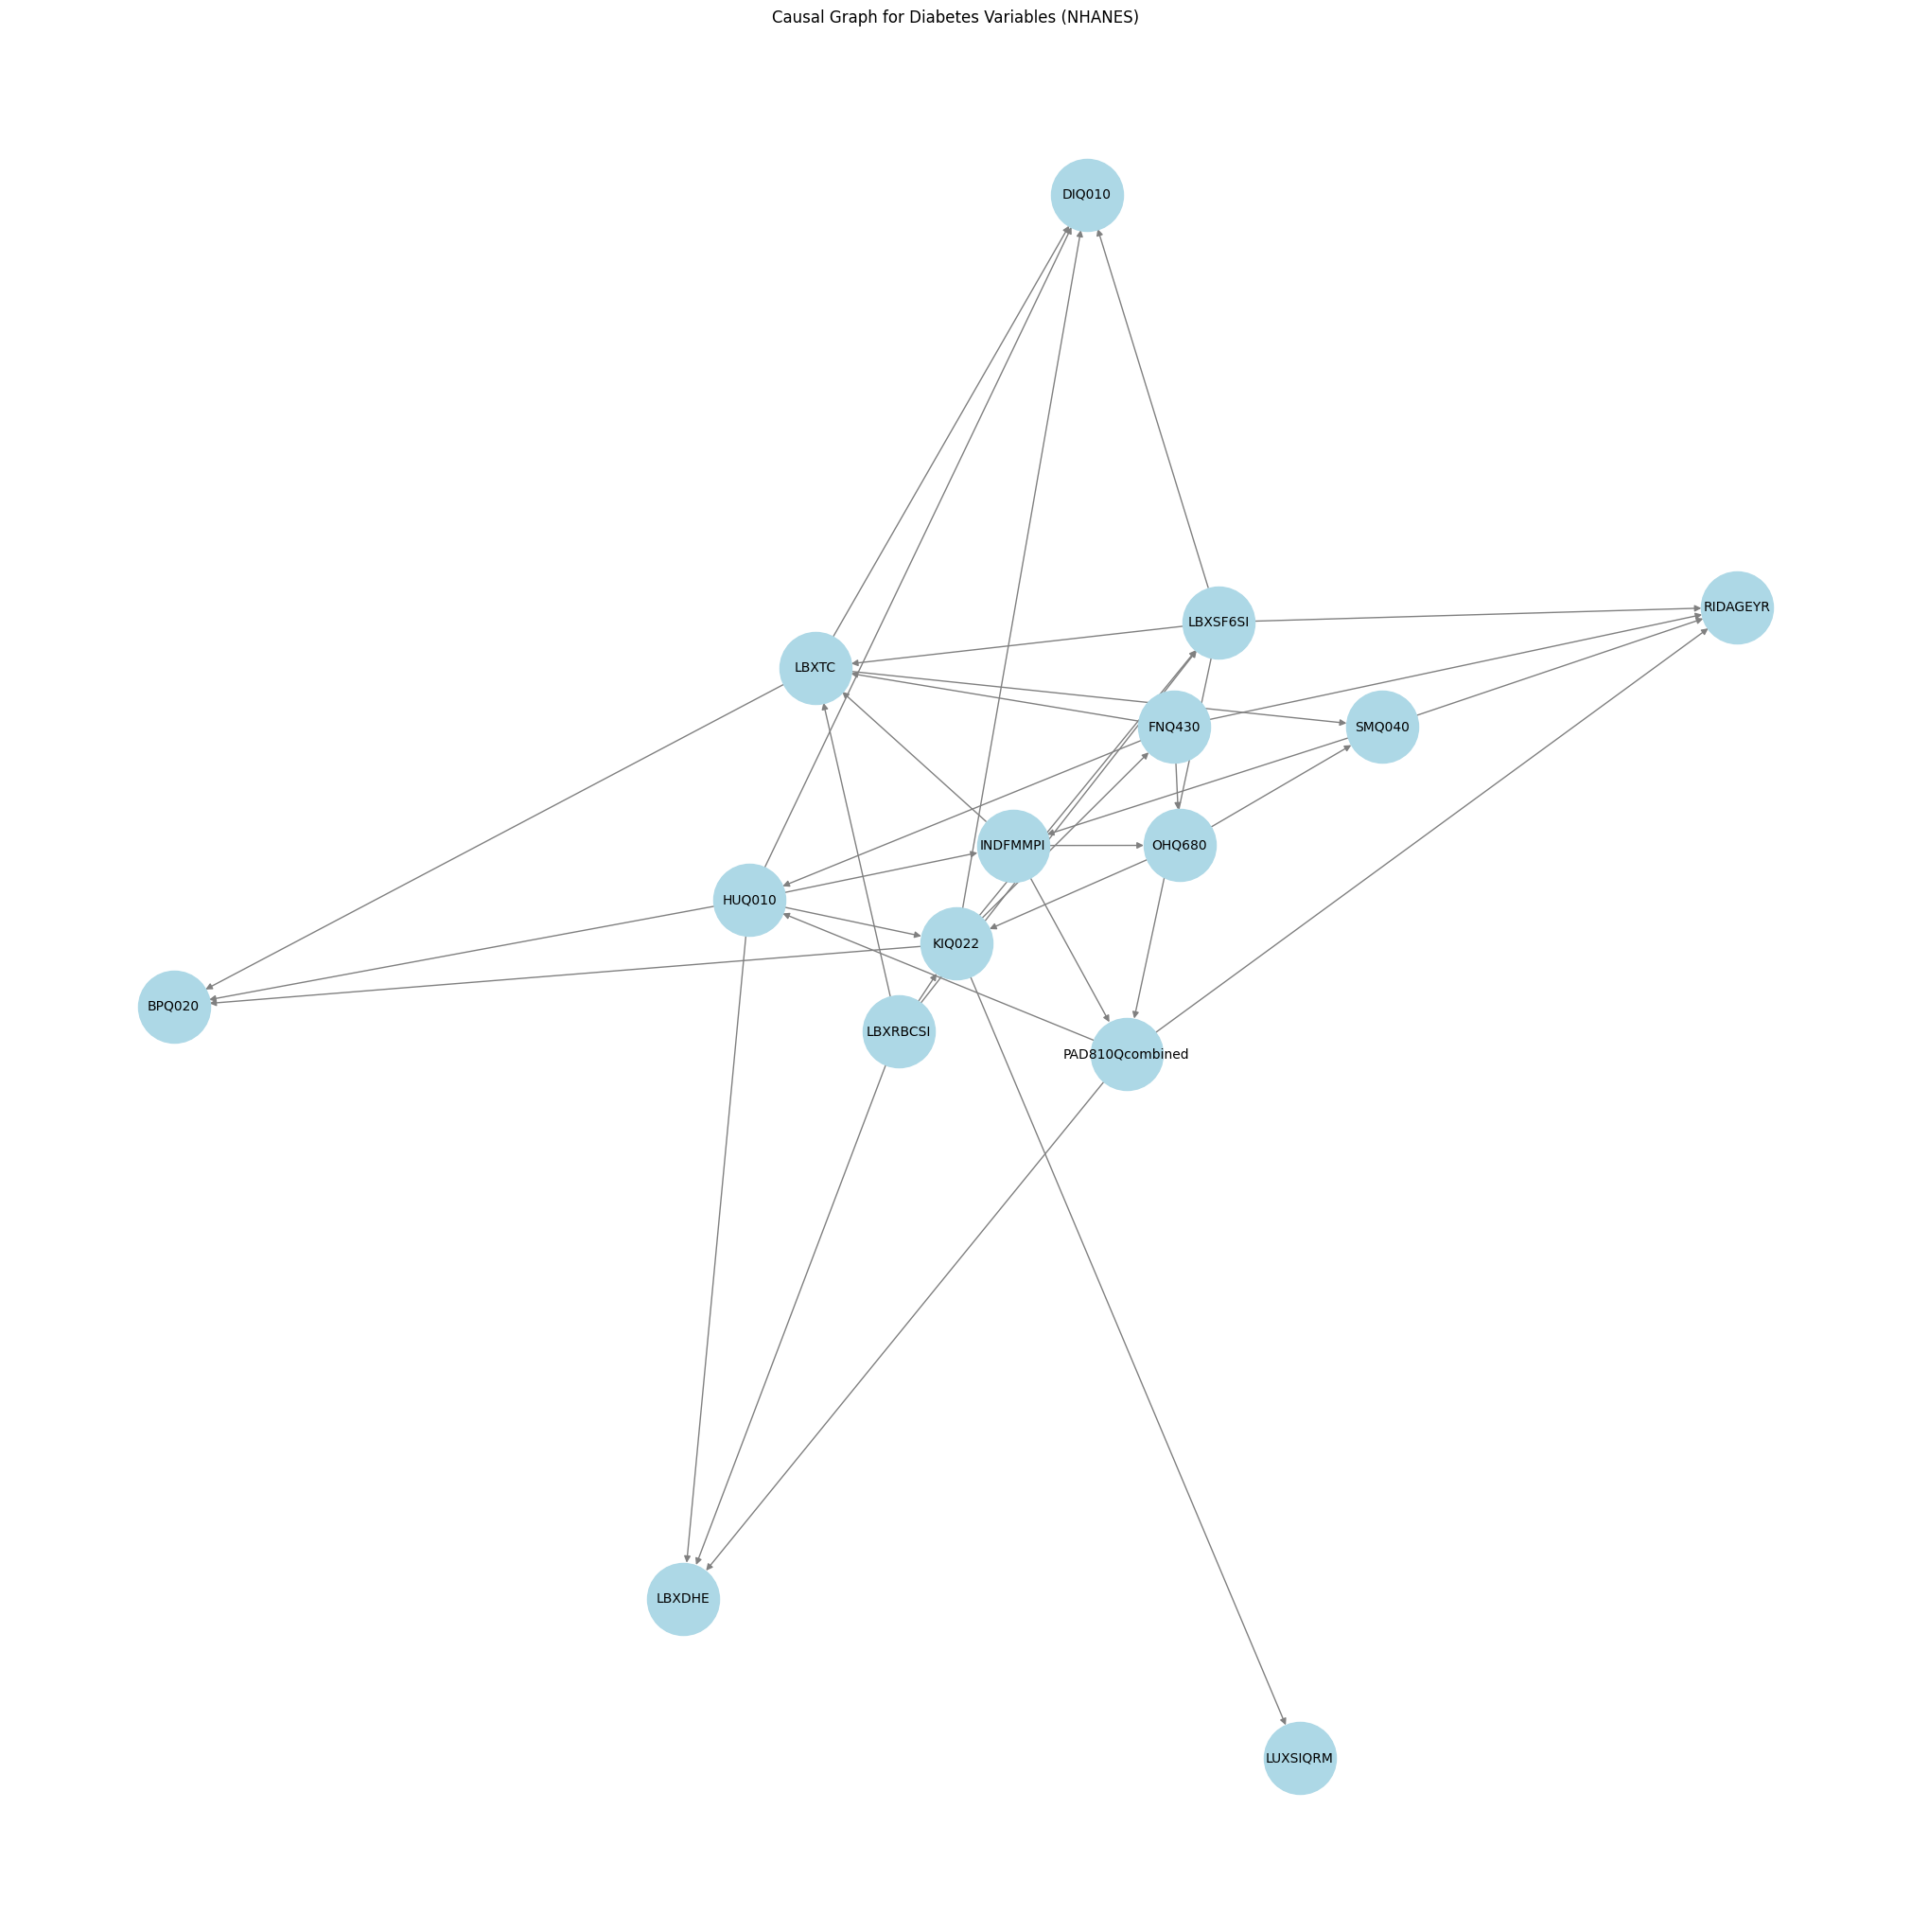

In [14]:
G_pc_kd = nx.DiGraph()  # Create a directed graph
node_labels = {col: col for col in df.columns}  # Map column names to themselves
print(node_labels)

for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if cg.G.graph[i, j] == 1:  # If there is an edge
            feature_i = df.columns[i]  # Get the feature name using the index
            feature_j = df.columns[j]  # Get the feature name using the index
            if feature_i in df.columns and feature_j in df.columns:  # Ensure the feature exists in df.columns
                G_pc_kd.add_edge(feature_i, feature_j)  # Add edge using column names
node_labels = {key: value for key, value in node_labels.items() if key in G_pc_kd.nodes}

pos = nx.spring_layout(G_pc_kd, seed=42)

plt.figure(figsize=(20, 20))
nx.draw(G_pc_kd, pos, labels=node_labels, with_labels=True, node_size=3000,
        node_color="lightblue", edge_color="gray", font_size=10)
plt.title("Causal Graph for Diabetes Variables (NHANES)")
plt.show()

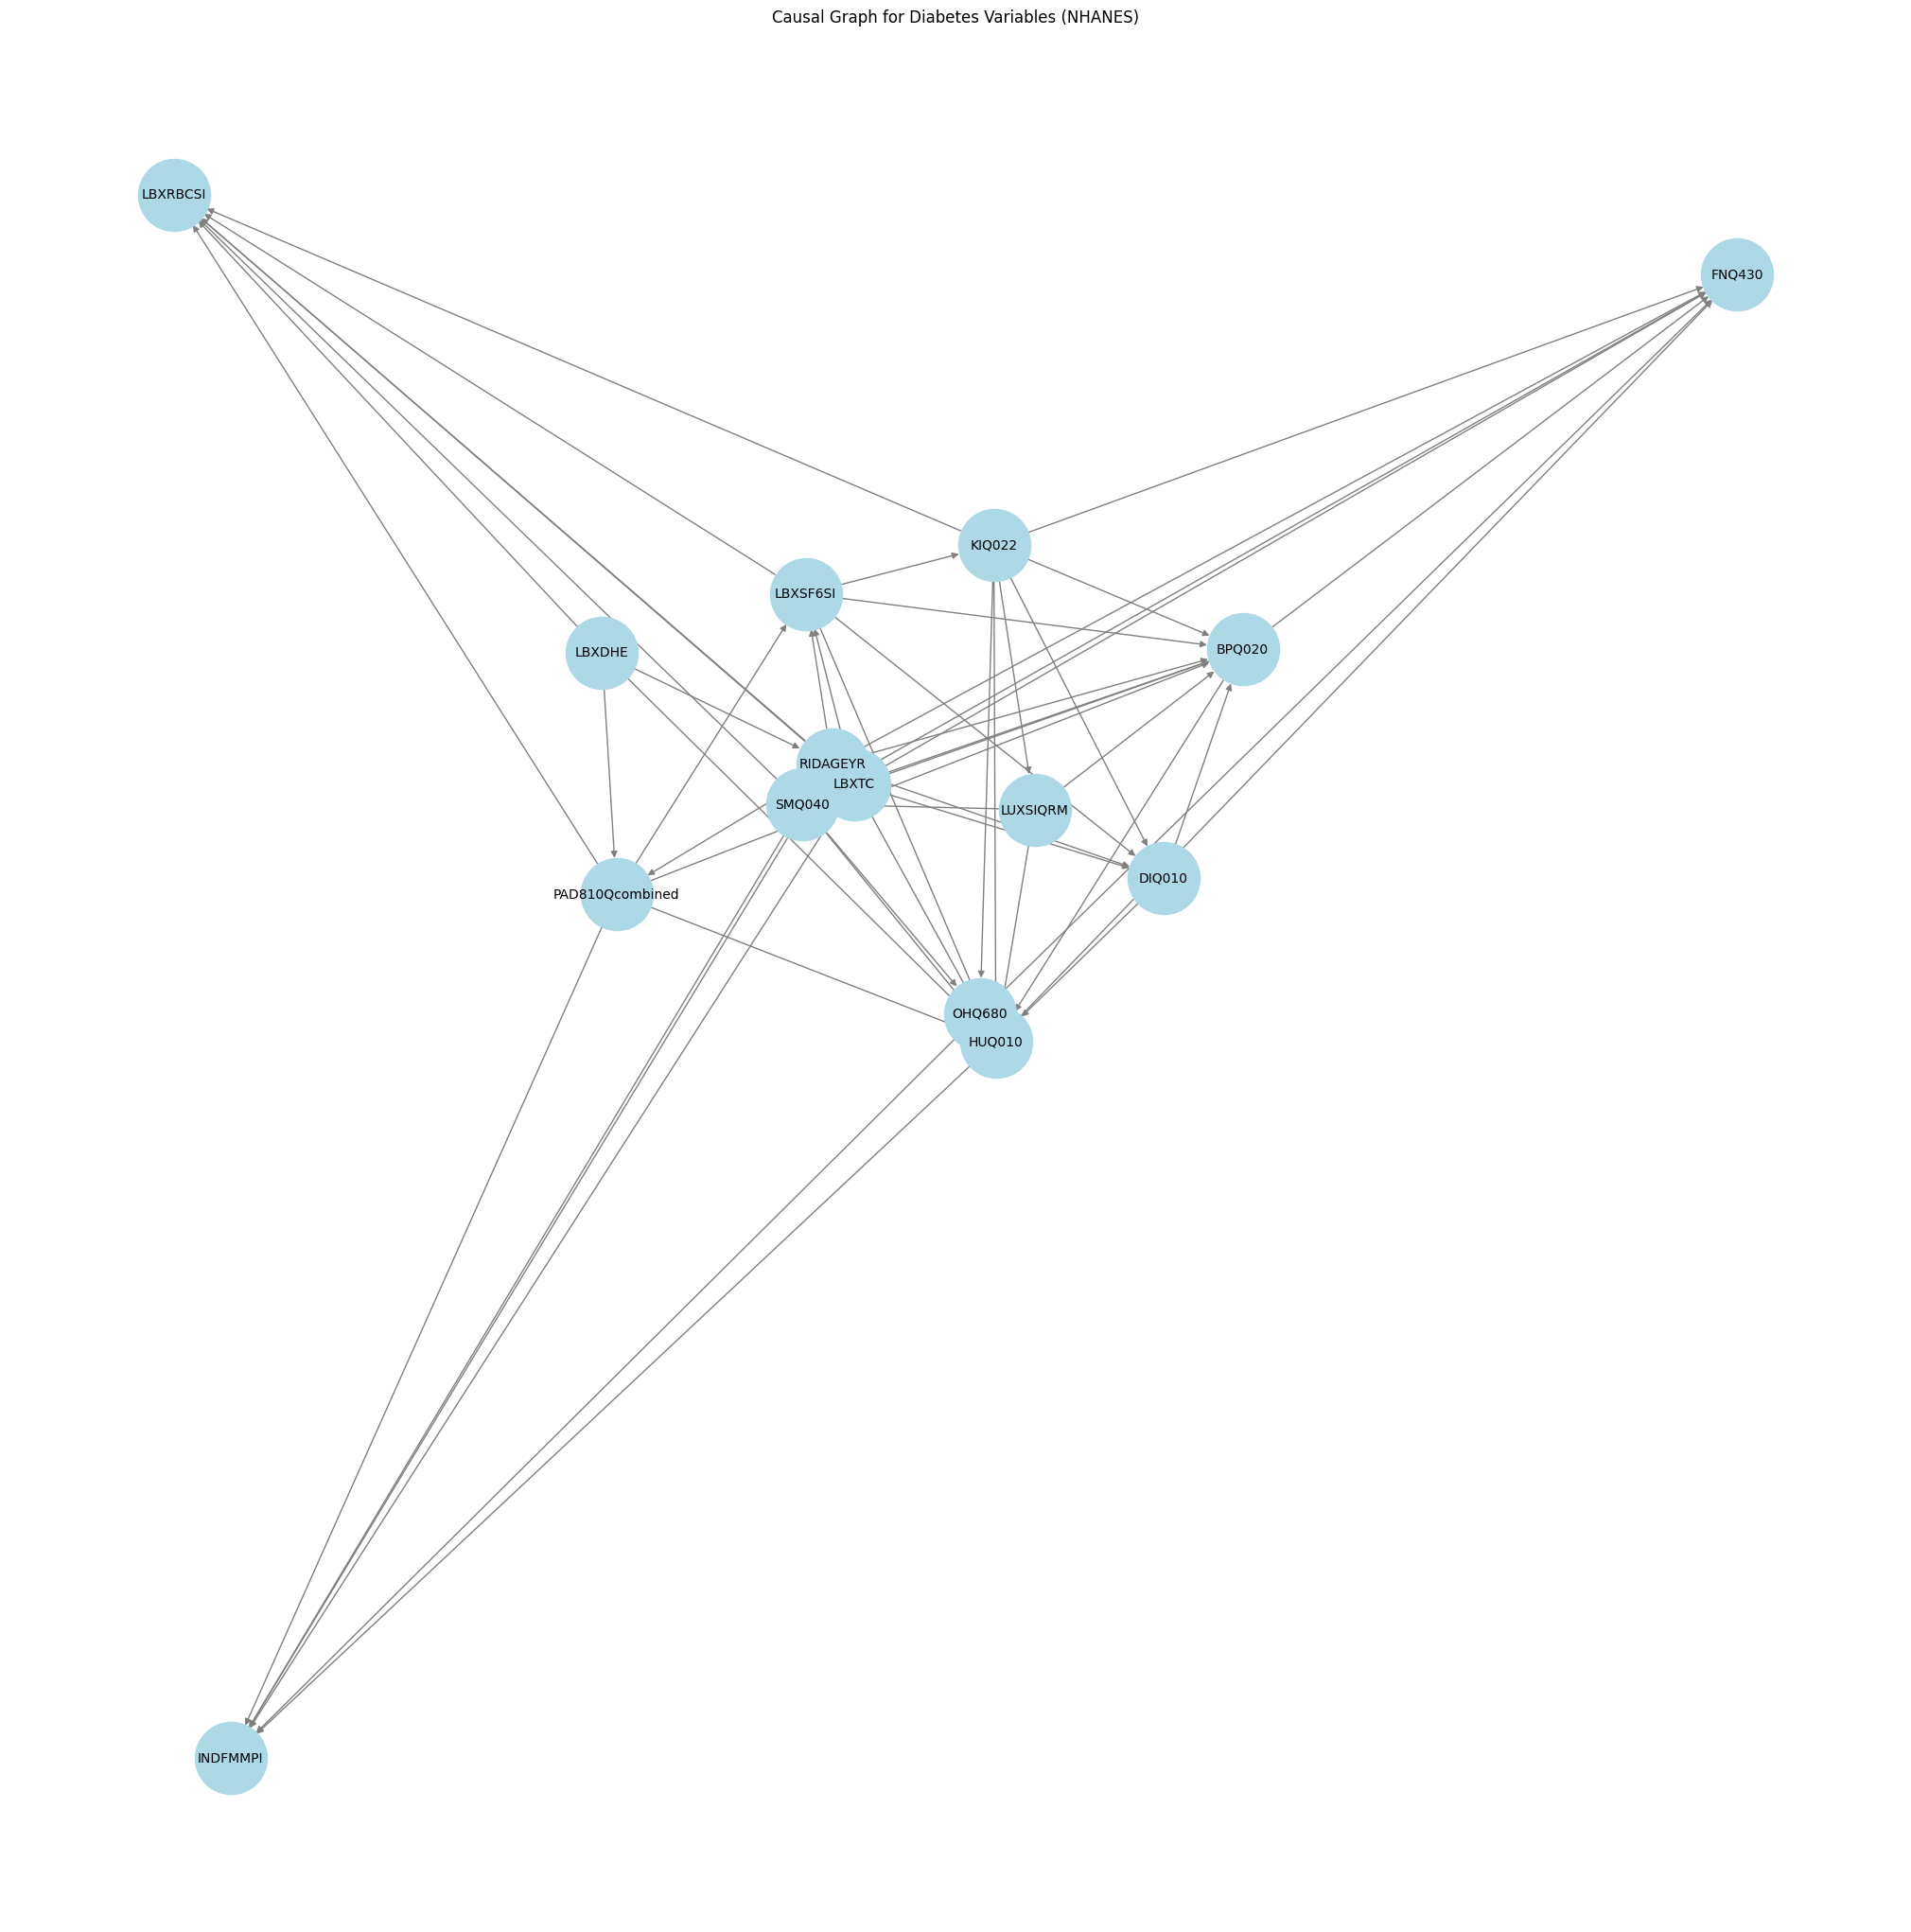

In [15]:
from causallearn.search.FCMBased import lingam

lingam = lingam.ICALiNGAM( random_state=1)
lingam.fit(data)

# Step 10: Get the causal graph from the learned coefficients
edges = lingam.adjacency_matrix_  # This gives you the adjacency matrix representing the causal graph

# Step 11: Convert causal graph to NetworkX graph
G_lingam_kd = nx.DiGraph()  # Create a directed graph
node_labels = {col: col for col in df.columns}  # Use column names as node labels

# Add edges to the graph
for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if edges[i, j] != 0:  # If there is a causal relationship
            G_lingam_kd.add_edge(df.columns[i], df.columns[j])  # Add edge from column i to column j

# Step 12: Generate `pos` for visualization
pos = nx.spring_layout(G_lingam_kd, seed=42)

# Step 13: Visualize the causal graph using column names as labels
plt.figure(figsize=(20, 20))
nx.draw(G_lingam_kd, pos, labels=node_labels, with_labels=True, node_size=3000,
        node_color="lightblue", edge_color="gray", font_size=10)
plt.title("Causal Graph for Diabetes Variables (NHANES)")
plt.show()


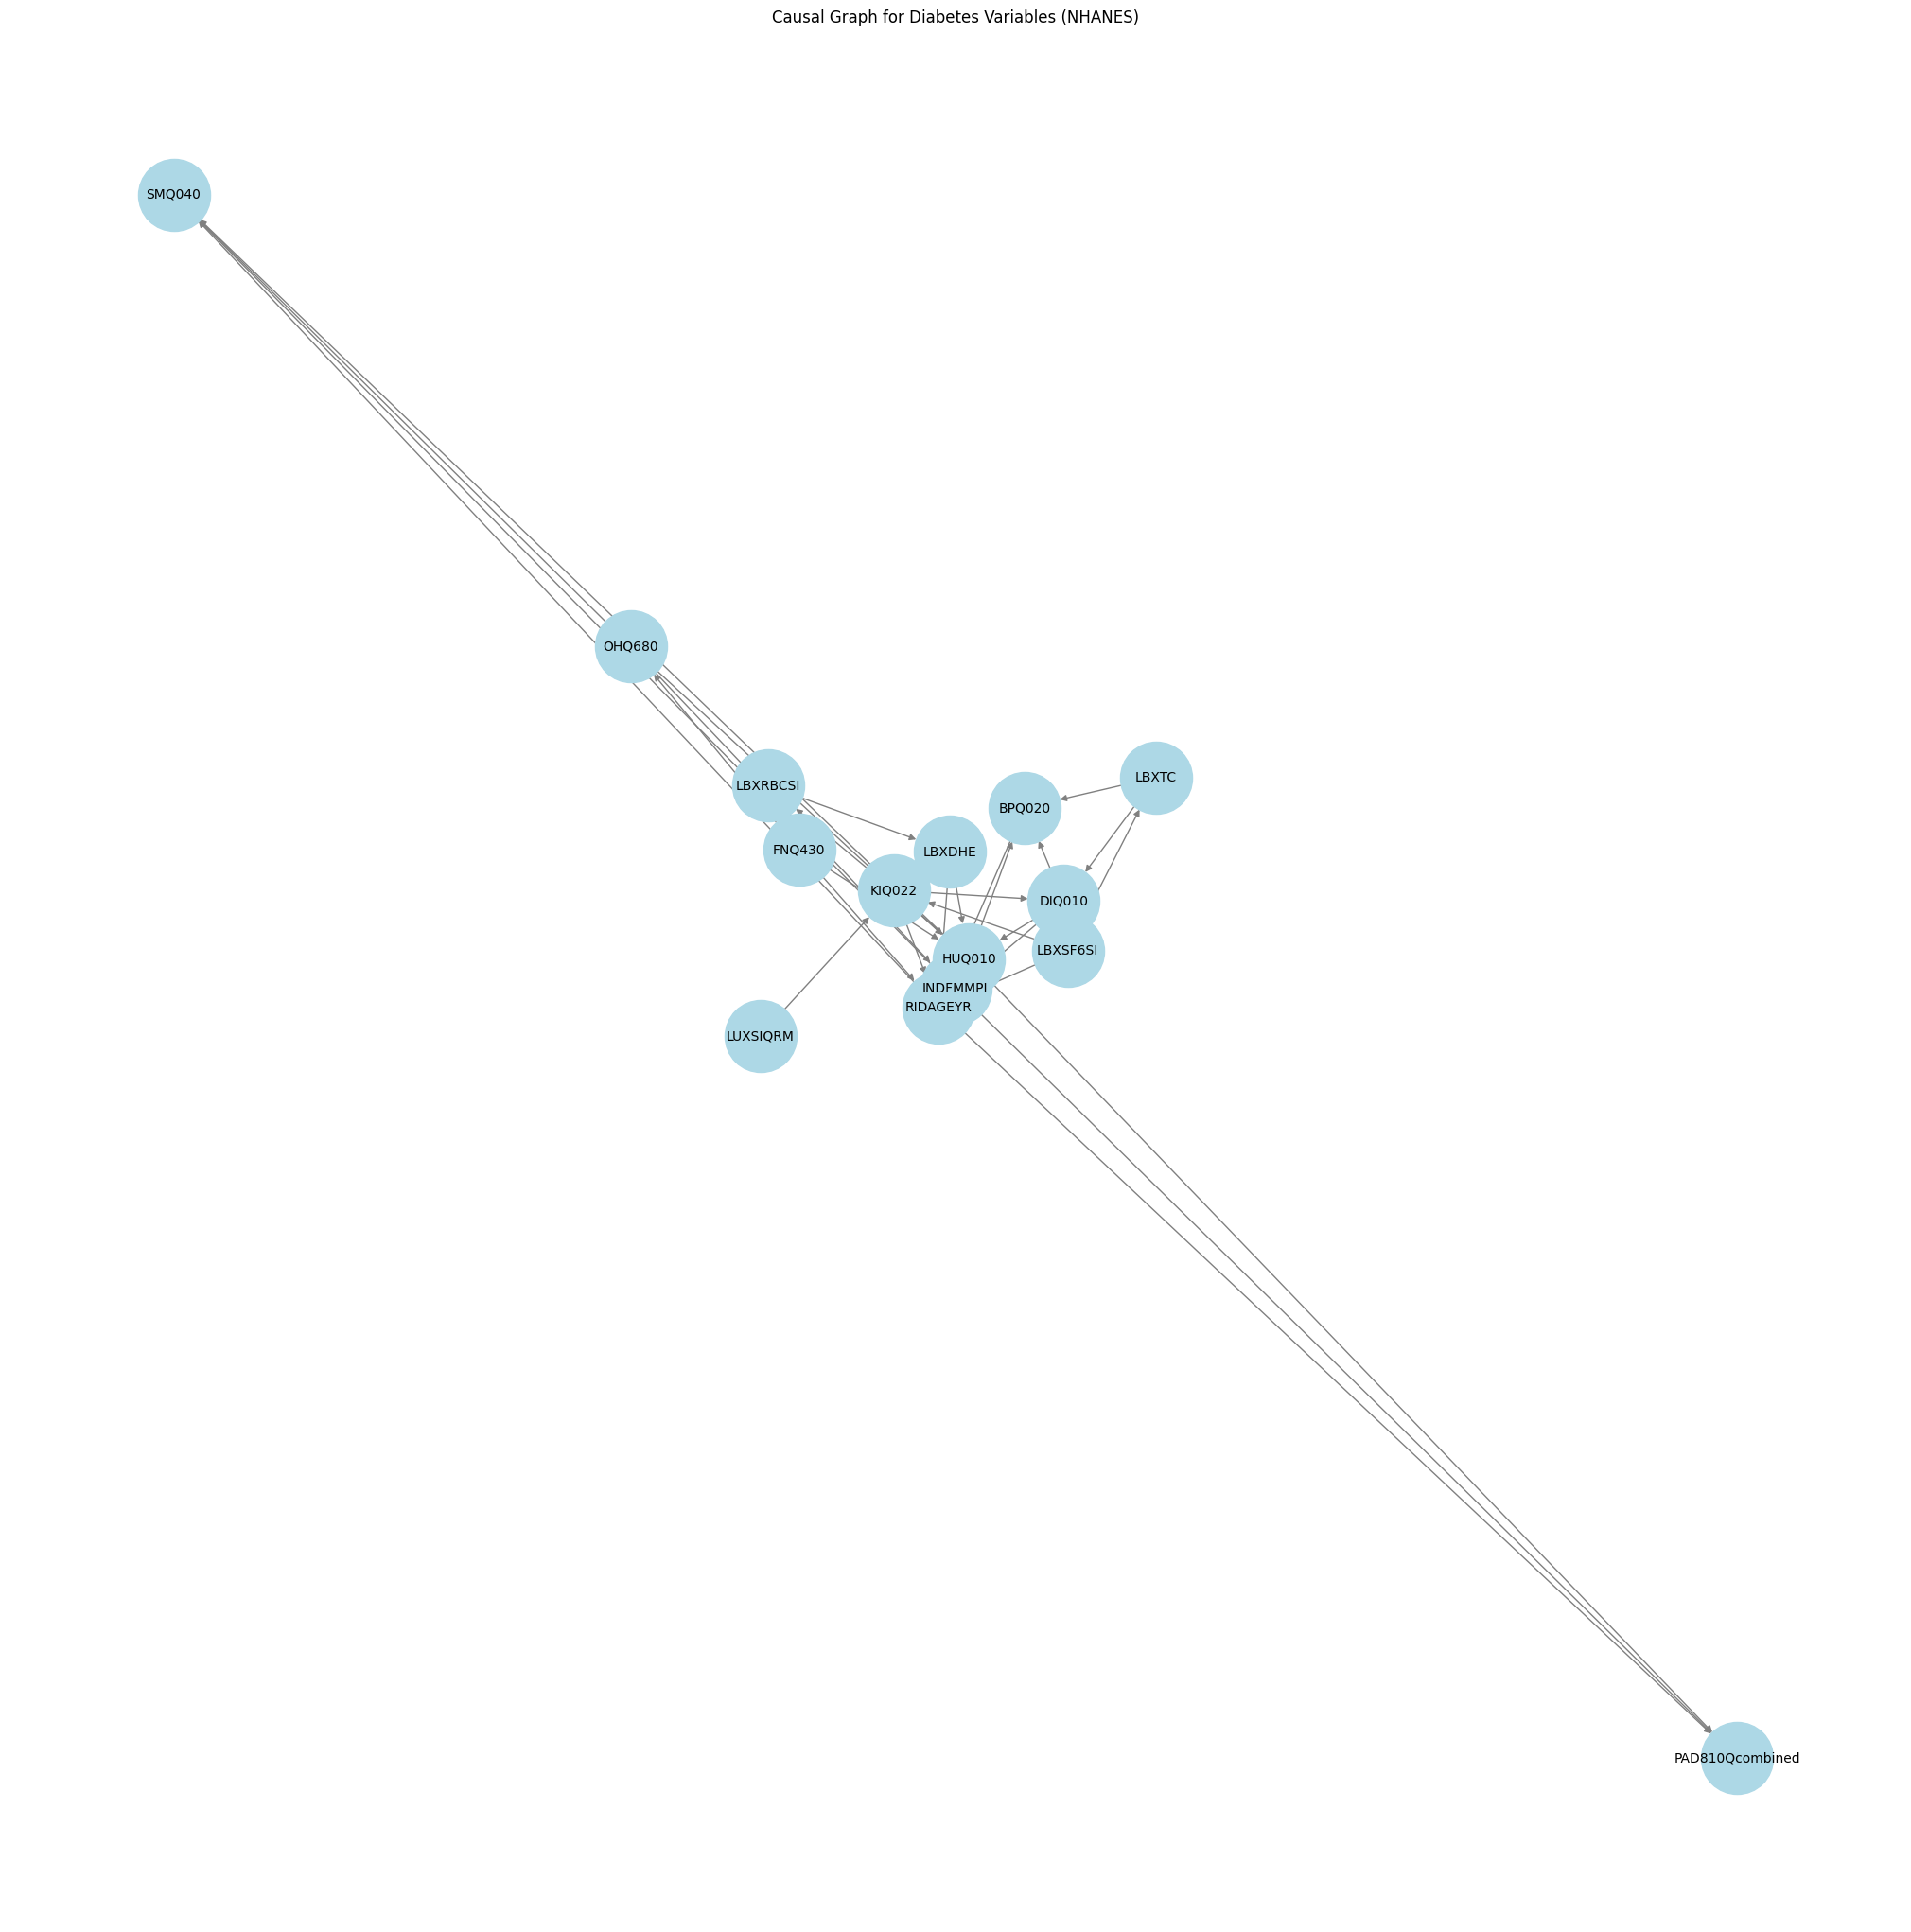

In [16]:
from causallearn.search.ScoreBased.GES import ges


ges = ges(data)

edges = ges["G"].graph 

G_ges_kd = nx.DiGraph()  # Create a directed graph
node_labels = {col: col for col in df.columns}  # Use column names as node labels

# Add edges to the graph
# node_labels = {col: col for col in df.columns}  # Use column names as node labels

# Add edges to the graph
for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if edges[i, j] == 1:  # If there is a causal relationship i → j
            G_ges_kd.add_edge(df.columns[i], df.columns[j])  # Add edge from column i to column j
        elif edges[i, j] == -1:  # If there is a causal relationship j → i
            G_ges_kd.add_edge(df.columns[j], df.columns[i])  # Add edge from column j to column i

# Step 12: Generate `pos` for visualization
pos = nx.spring_layout(G_ges_kd, seed=42)

# Step 13: Visualize the causal graph using column names as labels
plt.figure(figsize=(20, 20))
nx.draw(G_ges_kd, pos, labels=node_labels, with_labels=True, node_size=3000,
        node_color="lightblue", edge_color="gray", font_size=10)
plt.title("Causal Graph for Diabetes Variables (NHANES)")
plt.show()


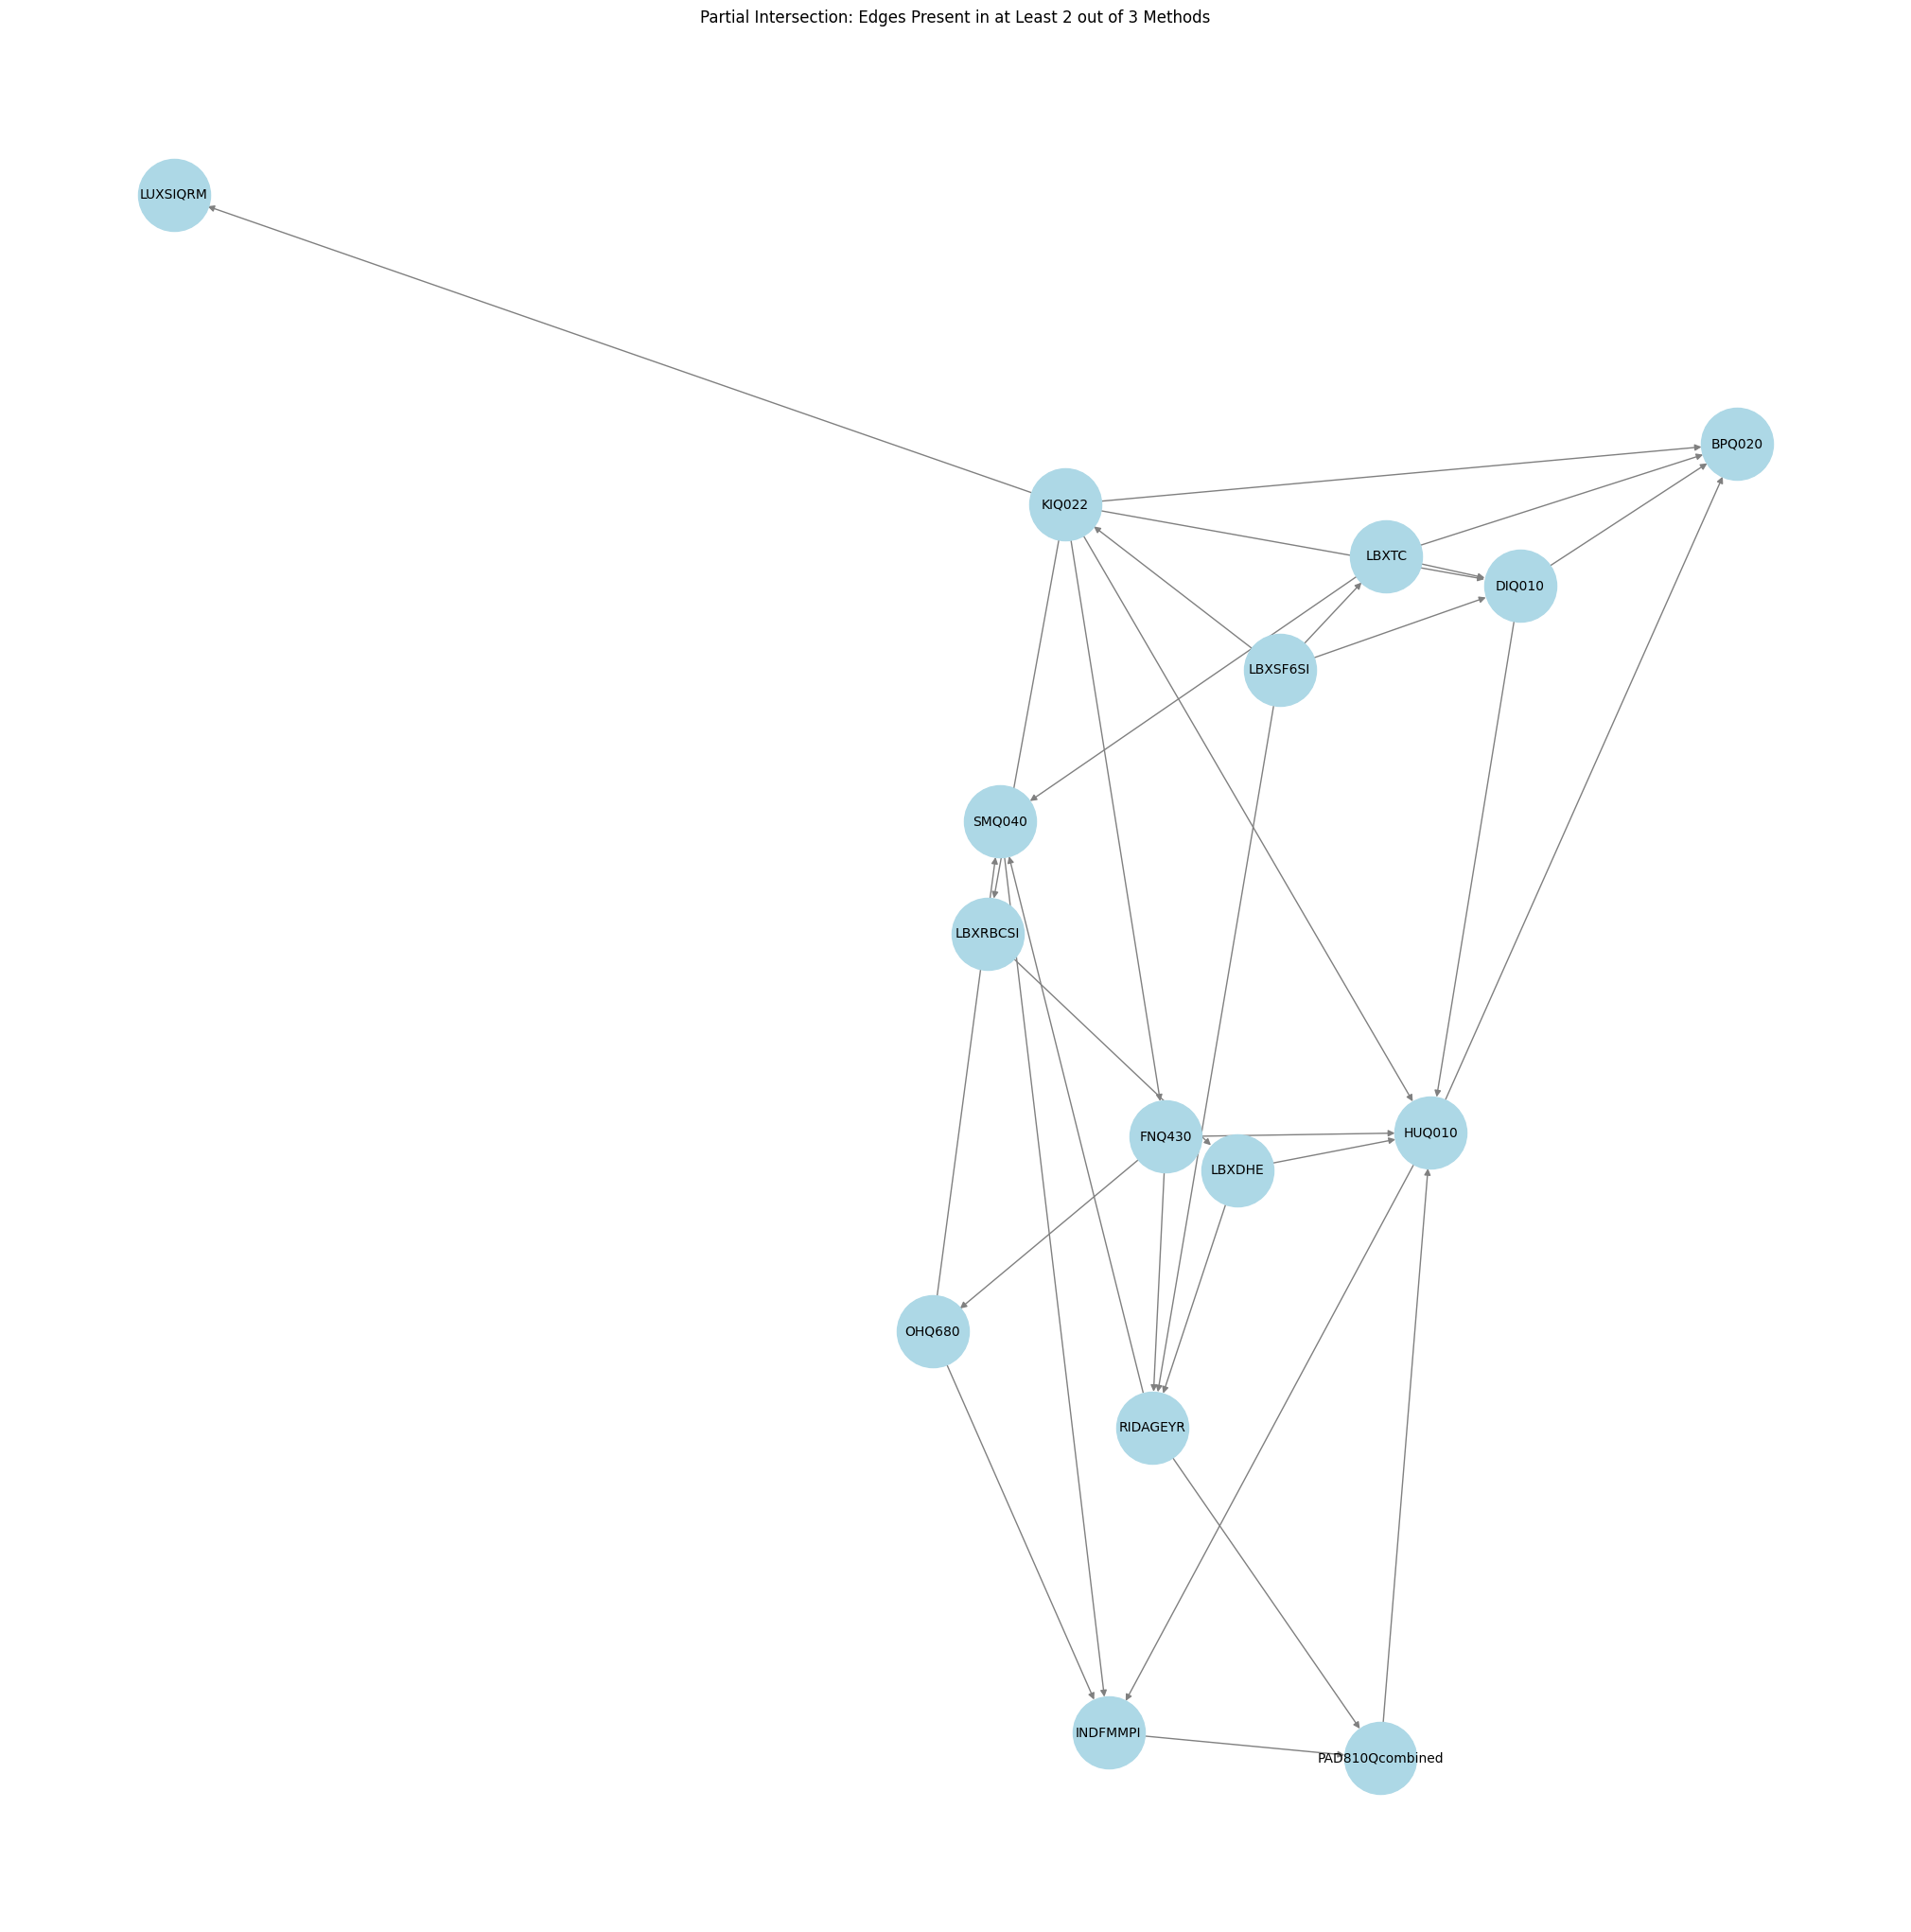

In [17]:
from collections import Counter

# Convert all edge lists to a common format: (source, target)
edges_pc = list(G_pc_kd.edges())
edges_lingam = list(G_lingam_kd.edges())
edges_ges = list(G_ges_kd.edges())

# Combine all edges from all graphs
all_edges = edges_pc + edges_lingam + edges_ges

# Count occurrences of each edge
edge_counts = Counter(all_edges)

# Filter edges that appear in at least 2 graphs
partial_edges = [edge for edge, count in edge_counts.items() if count >= 2]

# Create a new graph with only those partial edges
partial_graph_kd = nx.DiGraph()
partial_graph_kd.add_edges_from(partial_edges)

# Add nodes explicitly (in case some nodes are disconnected)
partial_graph_kd.add_nodes_from(G_pc_kd.nodes())

# Visualize
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(partial_graph_kd, seed=42)
nx.draw(partial_graph_kd, pos, with_labels=True, node_size=3000,
        node_color="lightblue", edge_color="gray", font_size=10)
plt.title("Partial Intersection: Edges Present in at Least 2 out of 3 Methods")
plt.show()


In [19]:
def extract_causal_roles(graph, node='KIQ022'):
    return {
        'Direct Causes (Parents)': sorted(list(graph.predecessors(node))),
        'Indirect Causes (Ancestors excl. direct)': sorted(list(set(nx.ancestors(graph, node)) - set(graph.predecessors(node)))),
        'Effects (Children)': sorted(list(graph.successors(node)))
    }

# Suppose you have graphs per disease per method like this
graphs = {
    ('KD', 'PC'): G_pc_kd,
    ('KD', 'LiNGAM'): G_lingam_kd,
    ('KD', 'GES'): G_ges_kd,
    # Add more entries here: e.g., ('CVD', 'PC'): G_cvd_pc, ...
}

# Create the structure for the table
summary = {}

for (disease, method), graph in graphs.items():
    roles = extract_causal_roles(graph, node='KIQ022')  # or other node for CVD/KIDNEY
    for role_type, variables in roles.items():
        key = role_type
        col = f"{disease} ({method})"
        if key not in summary:
            summary[key] = {}
        summary[key][col] = ', '.join(variables) if variables else '—'

# Convert to DataFrame
df_summary = pd.DataFrame(summary).T  # Transpose so rows are relationship types
df_summary.fillna('—', inplace=True)

# Preview
pd.set_option('display.max_colwidth', None)

# Convert the DataFrame to LaTeX format after adjusting the option.
latex_code = df_summary.to_latex(index=True)

with open("causal_summary_table_kd.tex", "w") as f:
    f.write(latex_code)

/tmp/ipykernel_3071270/2405321208.py:36: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_code = df_summary.to_latex(index=True)


---

# CVD

---

In [8]:
import pickle
from collections import Counter

# Step 1: Initialize a Counter to track feature appearances
feature_counter = Counter()

# Reading the dictionary from the file
with open('feature_sets_cvd.pkl', 'rb') as f:
    loaded_feature_sets = pickle.load(f)

# Printing to verify
print(loaded_feature_sets)
for method, features in loaded_feature_sets.items():
    feature_counter.update(features)


features_in_at_least_2_methods = [feature for feature, count in feature_counter.items() if count >= 2]

features_in_at_least_2_methods = [feature for feature in features_in_at_least_2_methods if feature not in ('RXQ050', 'RXQ033', 'BPQ020')]
# Printing the result
print("Features that appeared in at least 2 methods:", features_in_at_least_2_methods)


{'Model-Based': ['RXQ510', 'RXQ050', 'DRD370LQ', 'BPQ101D', 'SLQ310', 'LBDDHESI', 'RHQ031', 'BPQ020', 'BAXPF41', 'RXQ515', 'BMXARMC', 'BAXTC41', 'AUQ101', 'LBXTC', 'LBXRDW', 'FNQ480', 'HUQ010', 'FNQ440', 'BAXRXND', 'BAQ341', 'DPQ060', 'PAD810Qcombined', 'BAQ132', 'BAXPF42', 'DRD350H', 'KIQ010', 'DR1TMAGN', 'IMQ070', 'DRD370HQ', 'MCQ230C', 'LUARXIN', 'LBXEOPCT', 'BAARFC21', 'RIDAGEYR', 'MCQ220', 'DR1TP184', 'RHD280', 'BMXARML', 'DR1TIRON', 'DR1TVC', 'MCQ550', 'WHD010', 'OCD150', 'LBDHDD', 'DBD100', 'BAQ530', 'RHD043', 'OCQ210', 'SMD650', 'BPXODI1'], 'Domain': ['RIDAGEYR', 'RIAGENDR', 'RIDRETH3', 'DMDEDUC2', 'INDFMMPI', 'INDFMPIR', 'BMXBMI', 'BMXWAIST', 'BMXHIP', 'DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR', 'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 'DR1TCHOL', 'DR1TCAFF', 'DR1_320Z', 'PAD680', 'LBXHGB', 'LBXGLU', 'LBDINSI', 'LBDHDD', 'LBXHSCRP', 'SMQ040', 'ALQ121', 'SLD012', 'SLD013', 'MCQ160B', 'MCQ160D', 'MCQ160E', 'MCQ160F', 'MCQ160C', 'BPXOSY1', 'BPXODI1', 'DPQ100', 'PAD790Qcombined', '

In [9]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz, fastkci, chisq
from sklearn.impute import KNNImputer

# Step 1: Load NHANES dataset
df = pd.read_csv("NHANES_SAMPLE.csv")  # Ensure the file path is correct
diagnos_list = ['MCQ160B','MCQ160D', 'MCQ160E', 'MCQ160F','MCQ160C']

df["CVD conditions"] = df[diagnos_list].apply(lambda row: 1 if (row == 1).any() else 0, axis=1)

columns = features_in_at_least_2_methods +  ["CVD conditions"]

# Handle activity columns
activity_columns = [("PAD790Q", "PAD790U"), ("PAD810Q", "PAD810U")]  # List of pairs
for freq_col, unit_col in activity_columns:
    if freq_col in df.columns and unit_col in df.columns:
        df[f"{freq_col}combined"] = df[freq_col].astype(str) + "_" + df[unit_col].astype(str)  # Concatenate values
        df.drop([freq_col, unit_col], axis=1, inplace=True)  # Drop original columns

df = df[columns]

# Step 6: Remove constant columns (if any)
df = df.loc[:, df.nunique() > 1]

# Step 7: Convert categorical columns to numerical
for col in df.select_dtypes(include=["object", "category"]).columns:
    df[col] = df[col].astype("category").cat.codes

# Step 8: Convert dataframe to numpy array
knn_imputer = KNNImputer(n_neighbors=2)
df = df.dropna(axis=1, how='all')
df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)


data = df.to_numpy()
# Step 9: Run PC algorithm for causal discovery
cg = pc(data, alpha=0.05, indep_test=fisherz, max_condition_set=3)



/tmp/ipykernel_1180877/904046487.py:36: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)
Depth=10, working on node 23: 100%|██████████| 24/24 [00:00<00:00, 1302.34it/s]


{'RXQ510': 'RXQ510', 'BPQ101D': 'BPQ101D', 'LBDDHESI': 'LBDDHESI', 'RHQ031': 'RHQ031', 'RXQ515': 'RXQ515', 'AUQ101': 'AUQ101', 'LBXTC': 'LBXTC', 'LBXRDW': 'LBXRDW', 'FNQ480': 'FNQ480', 'HUQ010': 'HUQ010', 'FNQ440': 'FNQ440', 'PAD810Qcombined': 'PAD810Qcombined', 'LUARXIN': 'LUARXIN', 'RIDAGEYR': 'RIDAGEYR', 'RHD280': 'RHD280', 'OCD150': 'OCD150', 'LBDHDD': 'LBDHDD', 'BPXODI1': 'BPXODI1', 'DMDEDUC2': 'DMDEDUC2', 'BMXWAIST': 'BMXWAIST', 'LBDTCSI': 'LBDTCSI', 'LUAXSTAT': 'LUAXSTAT', 'SMQ020': 'SMQ020', 'CVD conditions': 'CVD conditions'}


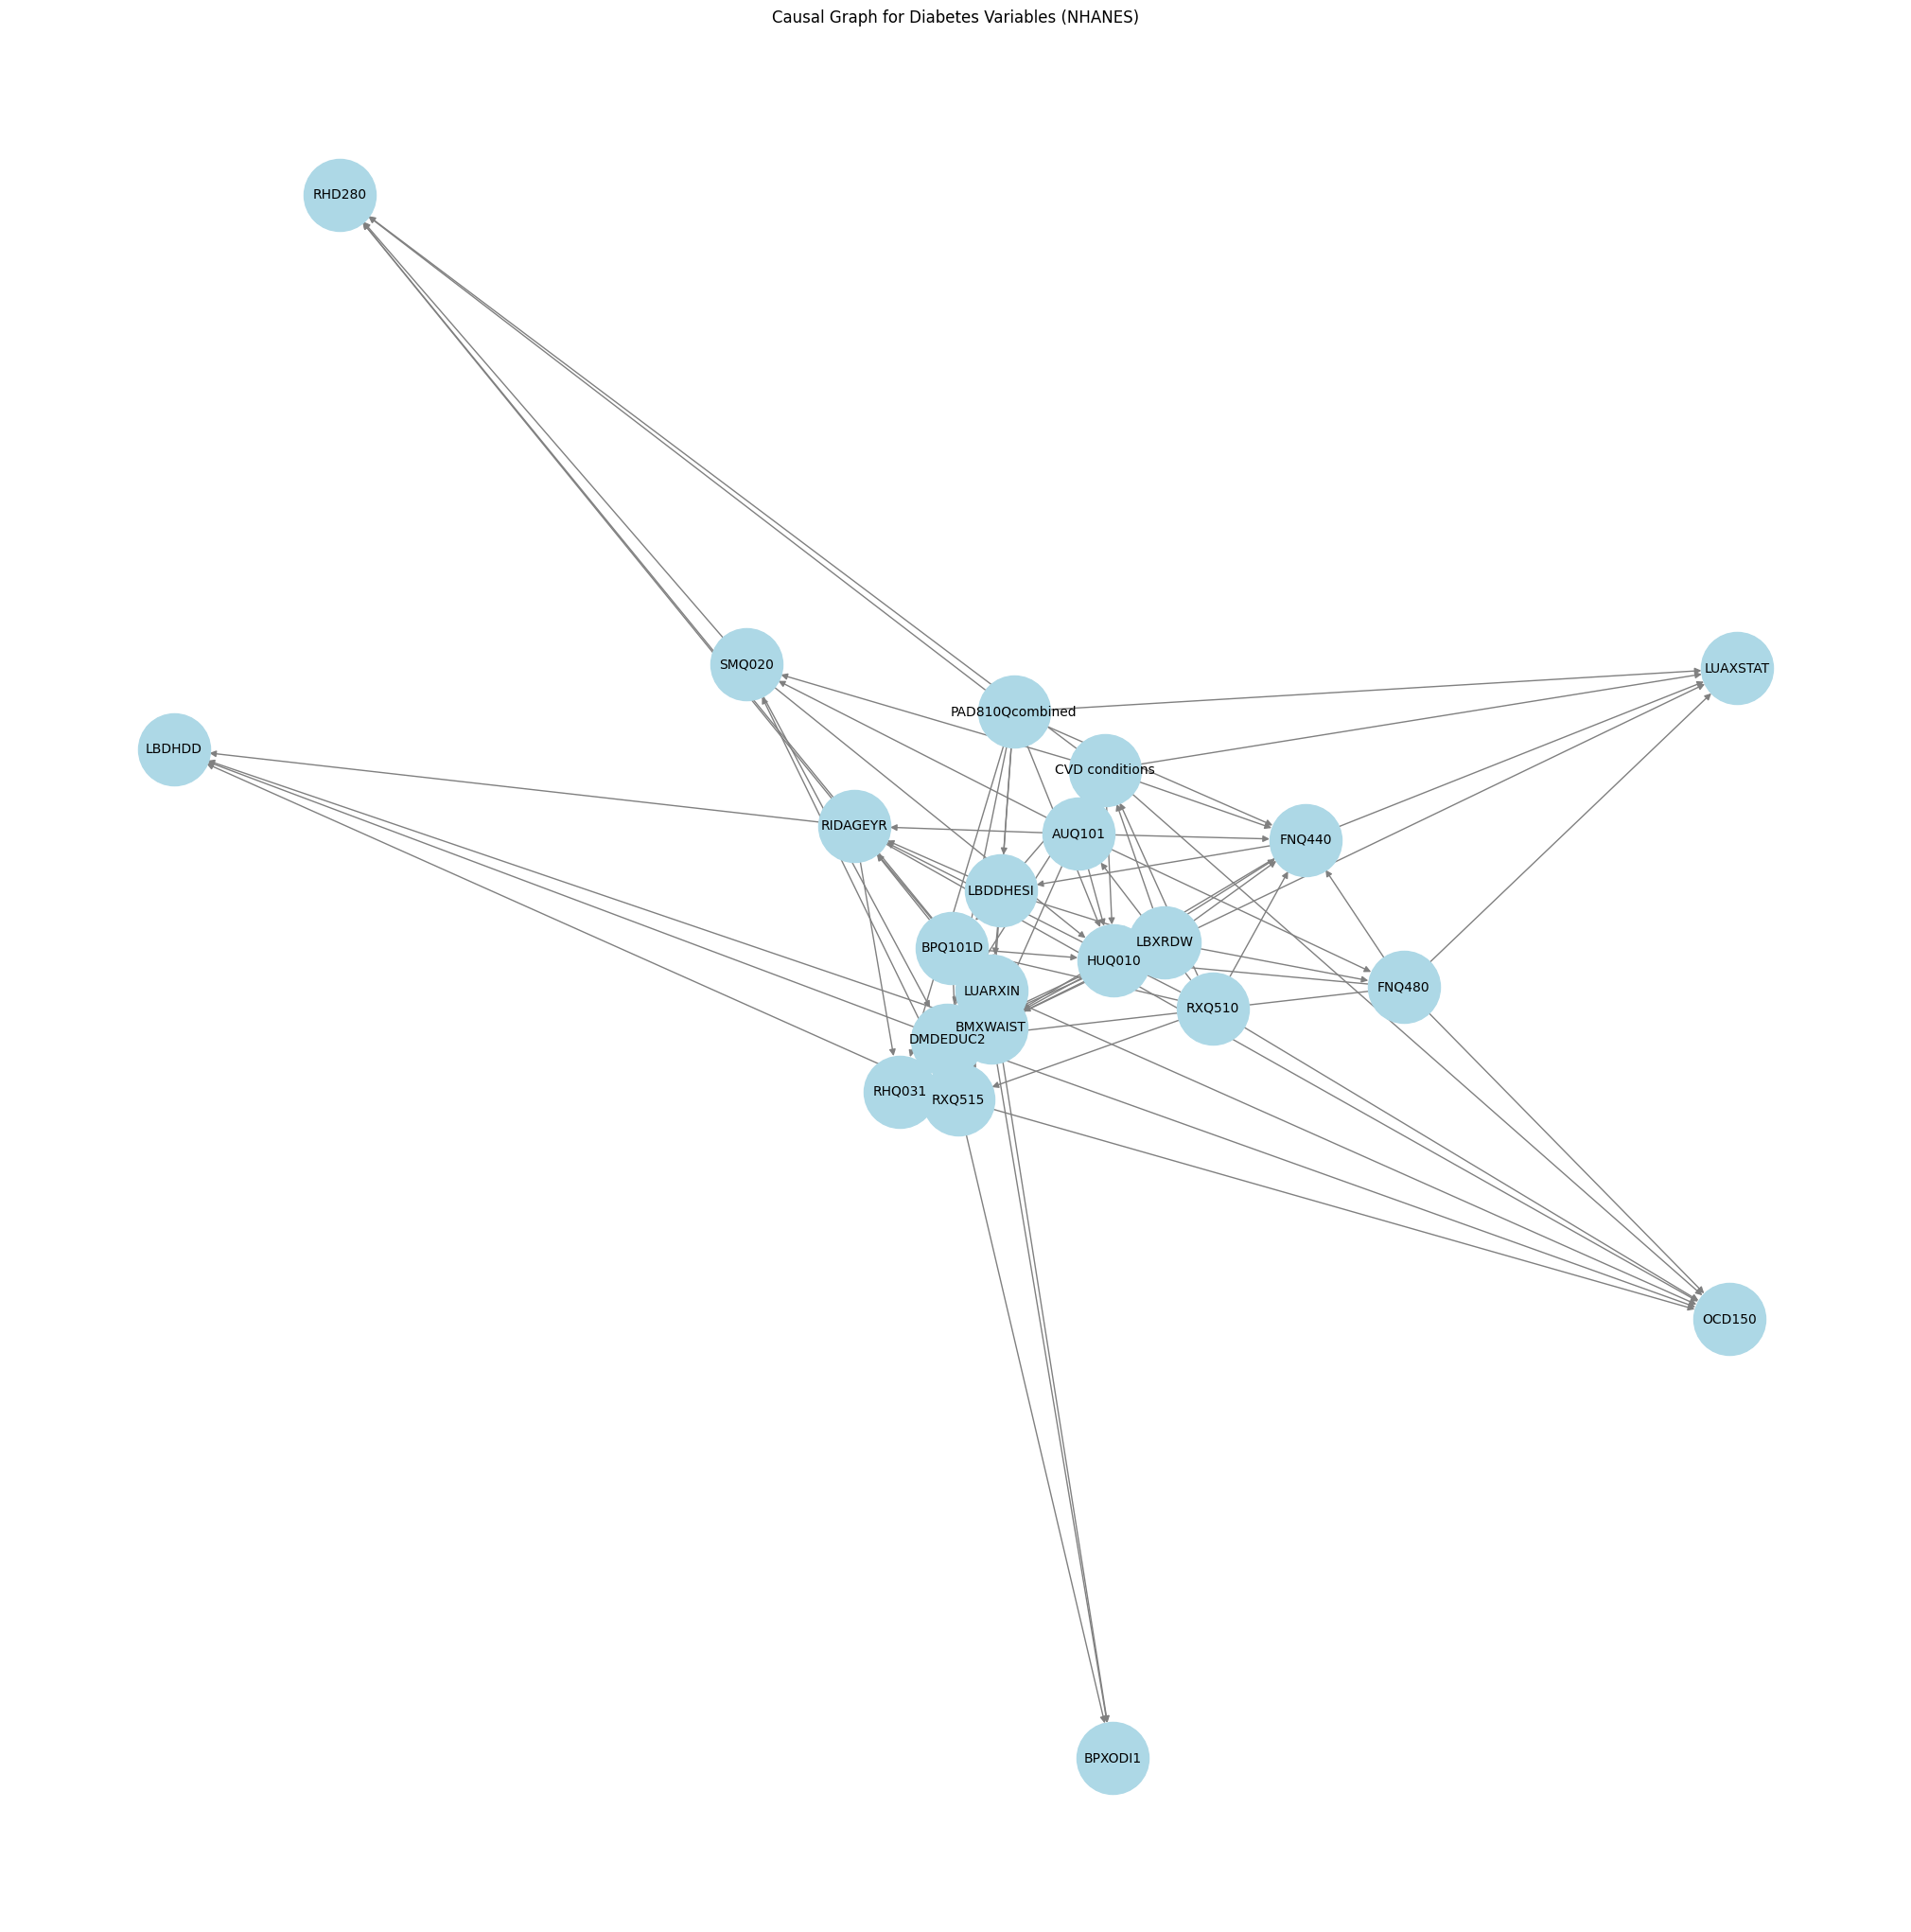

In [10]:
G_pc_cvd = nx.DiGraph()  # Create a directed graph
node_labels = {col: col for col in df.columns}  # Map column names to themselves
print(node_labels)

for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if cg.G.graph[i, j] == 1:  # If there is an edge
            feature_i = df.columns[i]  # Get the feature name using the index
            feature_j = df.columns[j]  # Get the feature name using the index
            if feature_i in df.columns and feature_j in df.columns:  # Ensure the feature exists in df.columns
                G_pc_cvd.add_edge(feature_i, feature_j)  # Add edge using column names
node_labels = {key: value for key, value in node_labels.items() if key in G_pc_cvd.nodes}

pos = nx.spring_layout(G_pc_cvd, seed=42)

plt.figure(figsize=(20, 20))
nx.draw(G_pc_cvd, pos, labels=node_labels, with_labels=True, node_size=3000,
        node_color="lightblue", edge_color="gray", font_size=10)
plt.title("Causal Graph for Diabetes Variables (NHANES)")
plt.show()

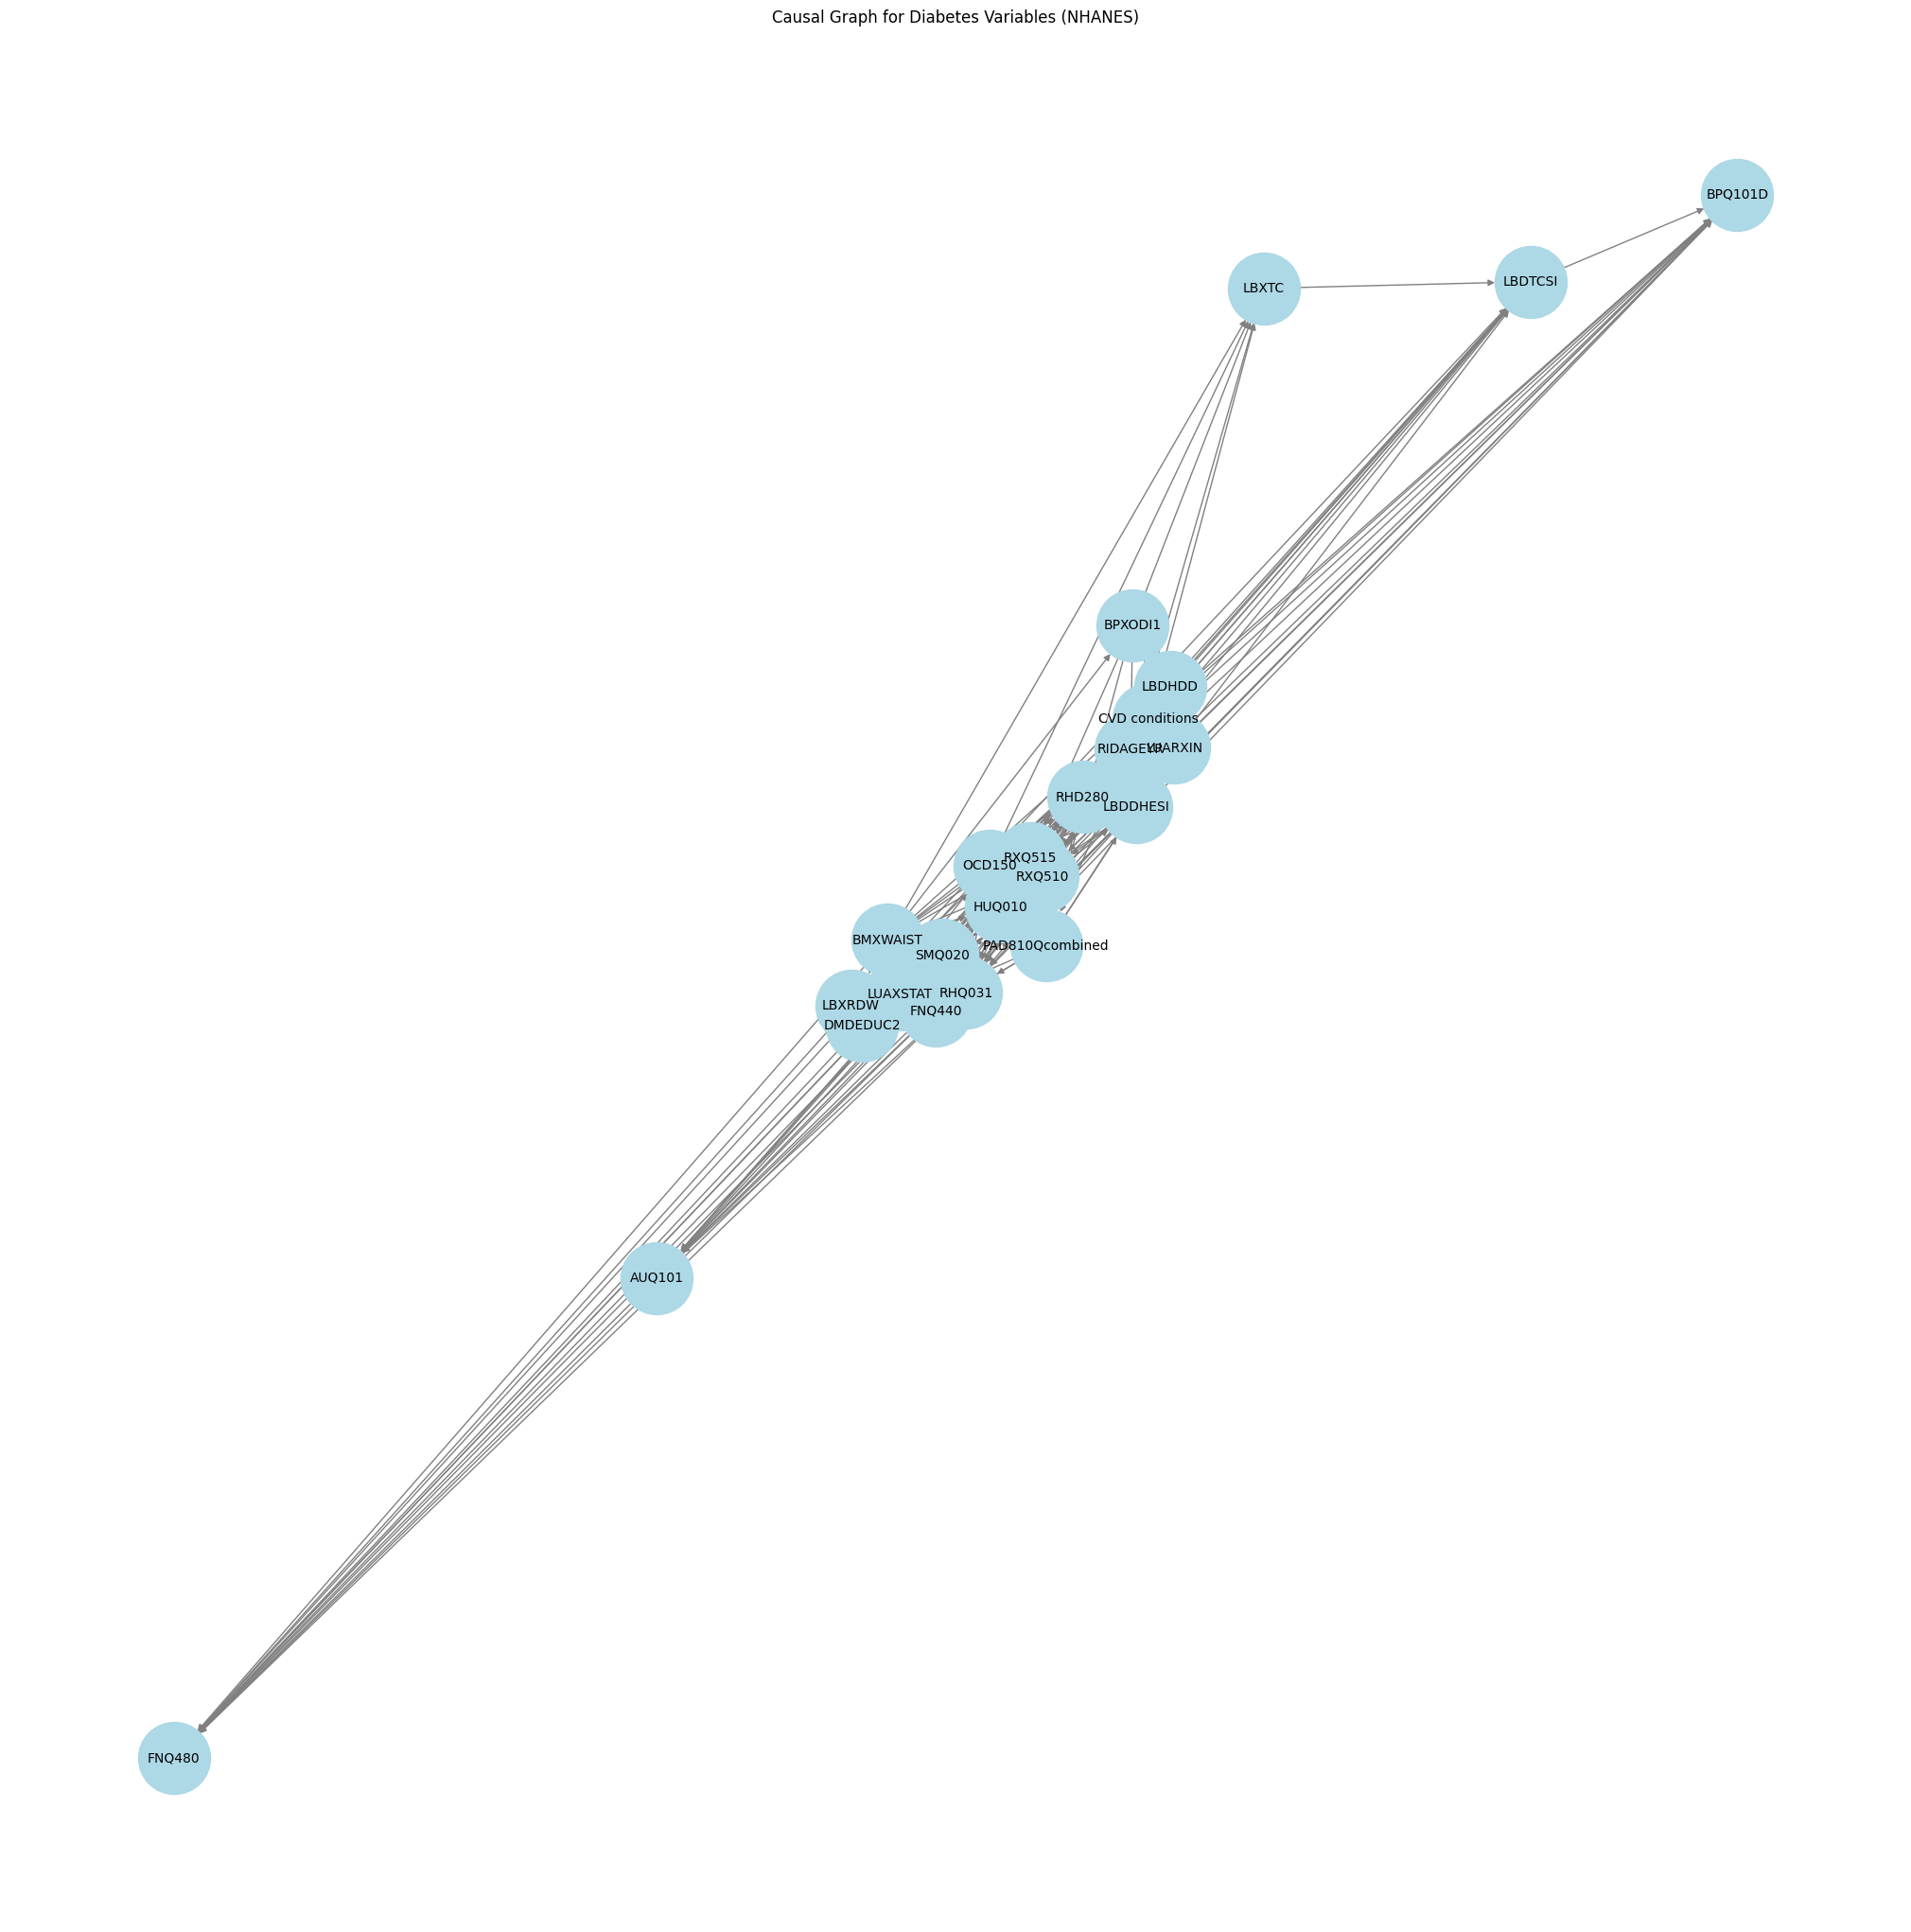

In [11]:
from causallearn.search.FCMBased import lingam

lingam = lingam.ICALiNGAM( random_state=1)
lingam.fit(data)

# Step 10: Get the causal graph from the learned coefficients
edges = lingam.adjacency_matrix_  # This gives you the adjacency matrix representing the causal graph

# Step 11: Convert causal graph to NetworkX graph
G_lingam_cvd = nx.DiGraph()  # Create a directed graph
node_labels = {col: col for col in df.columns}  # Use column names as node labels

# Add edges to the graph
for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if edges[i, j] != 0:  # If there is a causal relationship
            G_lingam_cvd.add_edge(df.columns[i], df.columns[j])  # Add edge from column i to column j

# Step 12: Generate `pos` for visualization
pos = nx.spring_layout(G_lingam_cvd, seed=42)

# Step 13: Visualize the causal graph using column names as labels
plt.figure(figsize=(20, 20))
nx.draw(G_lingam_cvd, pos, labels=node_labels, with_labels=True, node_size=3000,
        node_color="lightblue", edge_color="gray", font_size=10)
plt.title("Causal Graph for Diabetes Variables (NHANES)")
plt.show()


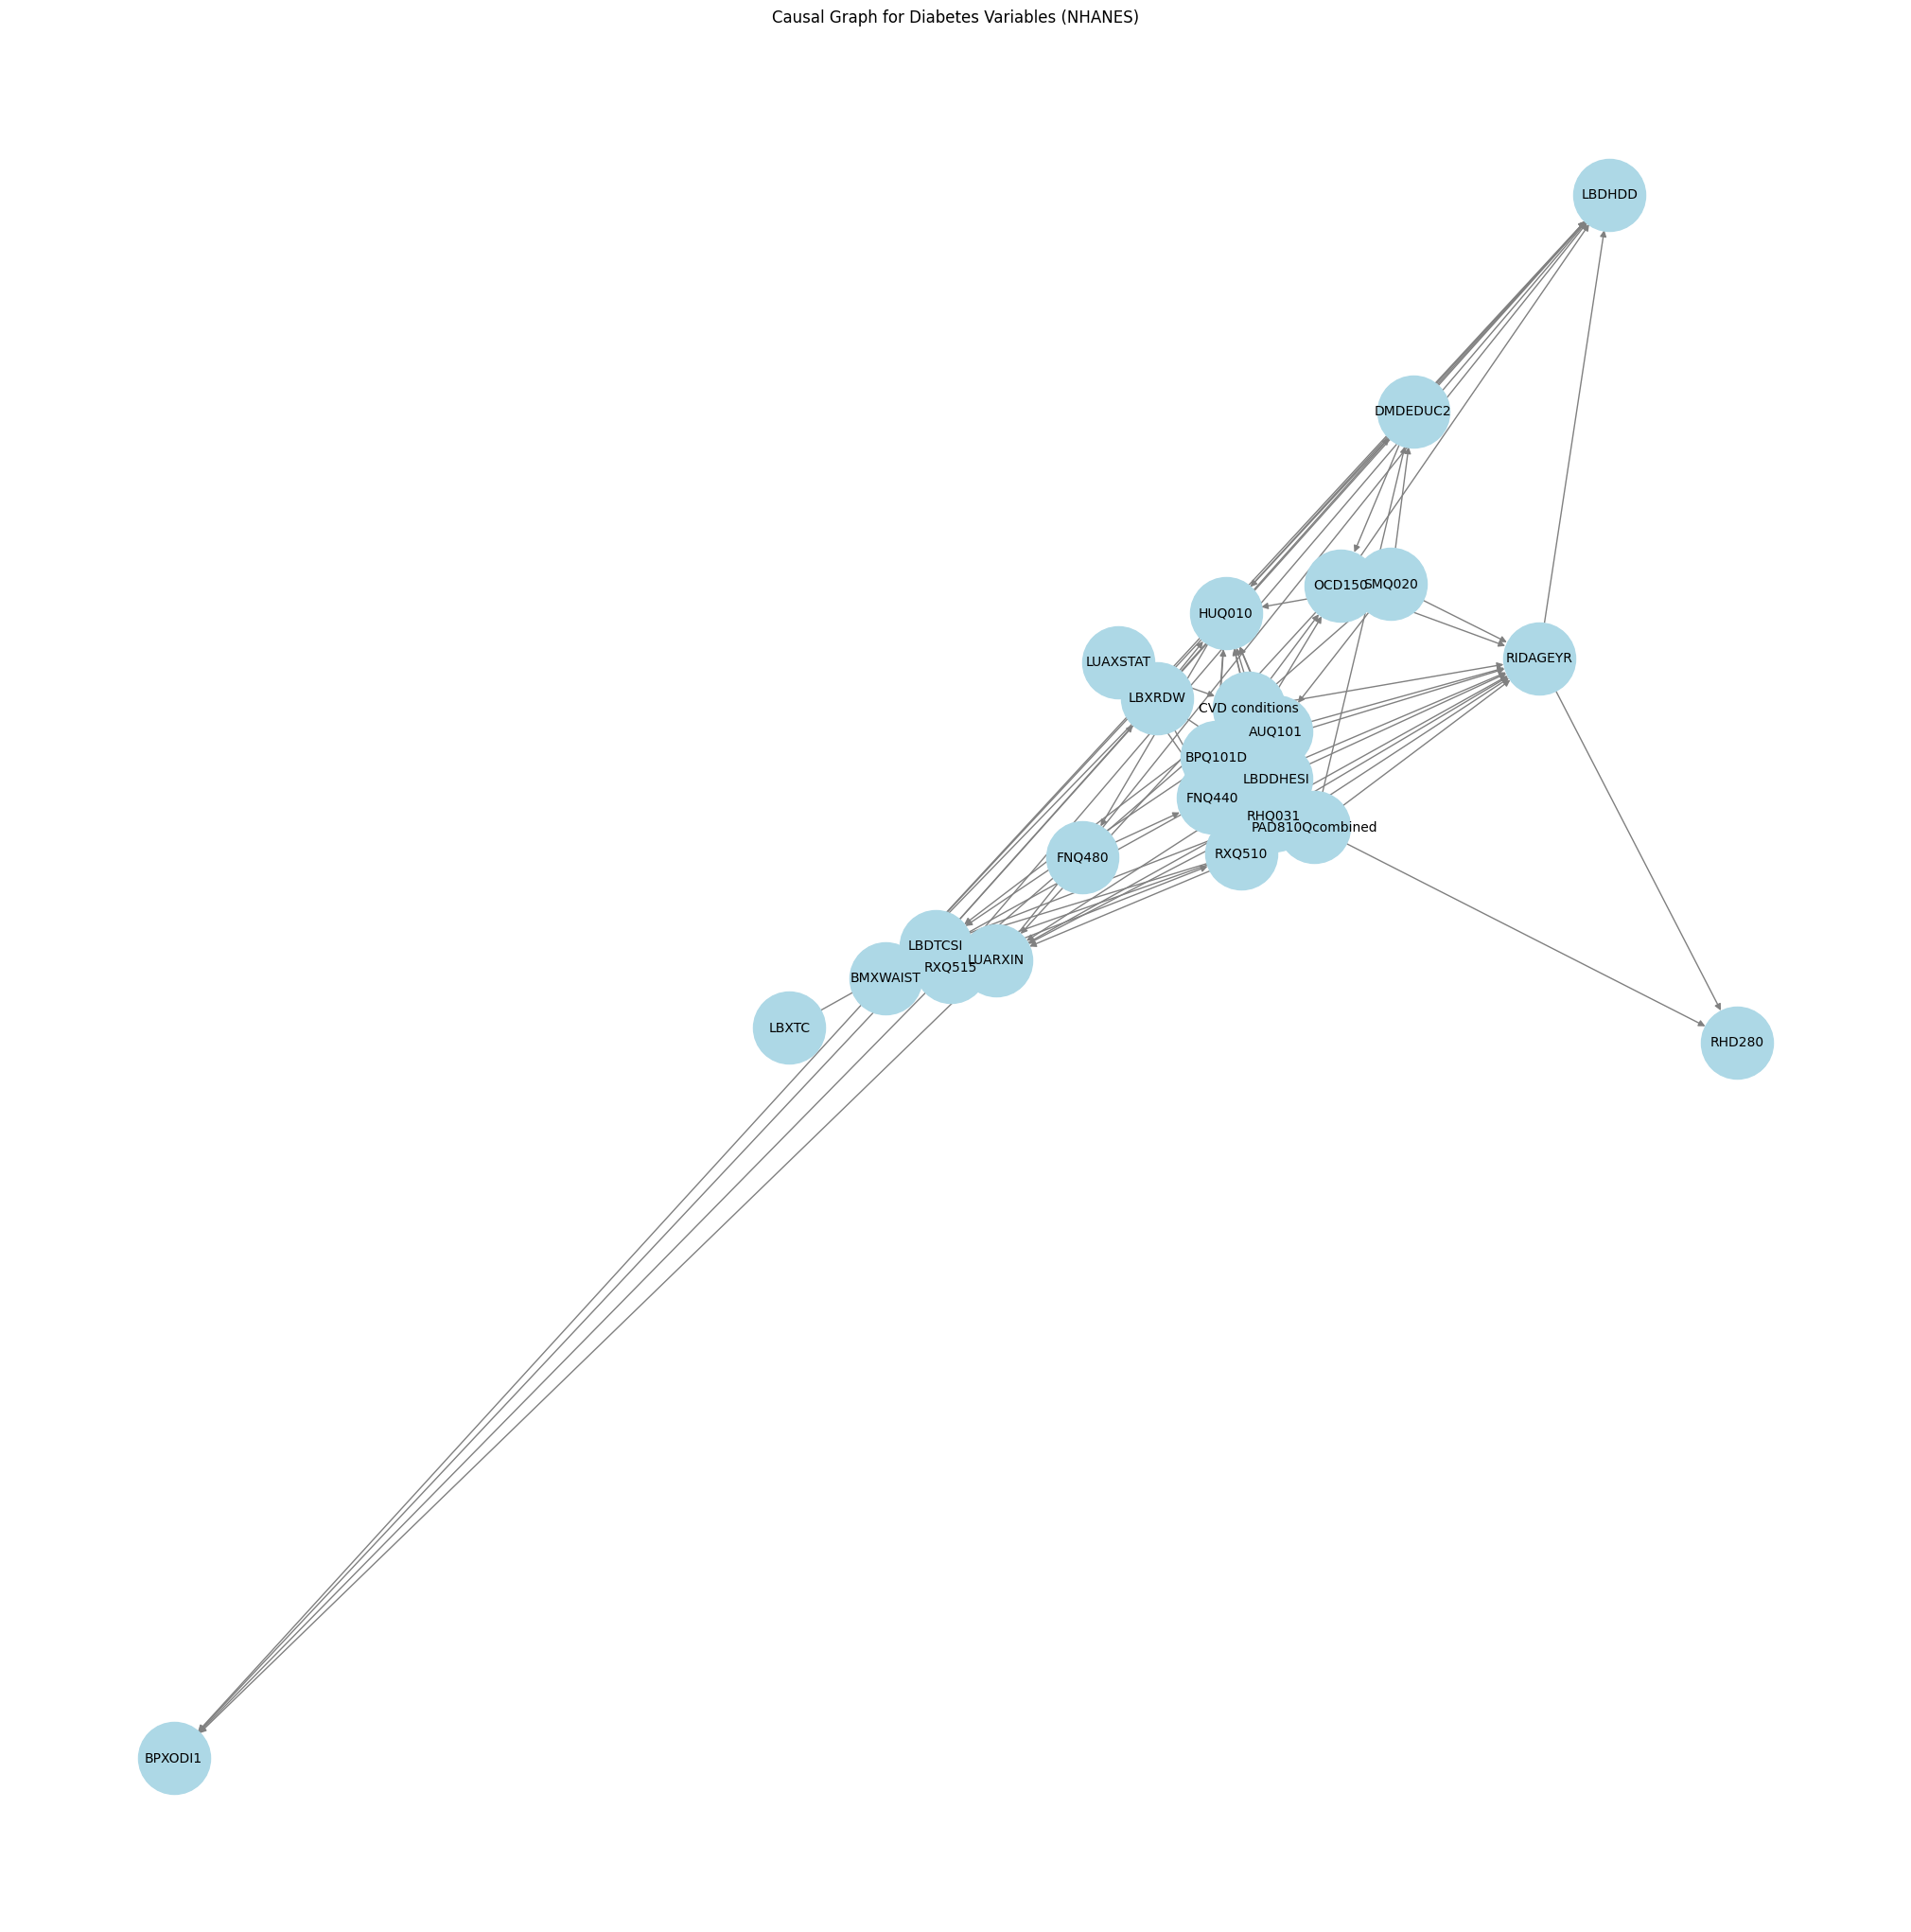

In [12]:
from causallearn.search.ScoreBased.GES import ges


ges = ges(data)

edges = ges["G"].graph 

G_ges_cvd = nx.DiGraph()  # Create a directed graph
node_labels = {col: col for col in df.columns}  # Use column names as node labels

# Add edges to the graph
# node_labels = {col: col for col in df.columns}  # Use column names as node labels

# Add edges to the graph
for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if edges[i, j] == 1:  # If there is a causal relationship i → j
            G_ges_cvd.add_edge(df.columns[i], df.columns[j])  # Add edge from column i to column j
        elif edges[i, j] == -1:  # If there is a causal relationship j → i
            G_ges_cvd.add_edge(df.columns[j], df.columns[i])  # Add edge from column j to column i

# Step 12: Generate `pos` for visualization
pos = nx.spring_layout(G_ges_cvd, seed=42)

# Step 13: Visualize the causal graph using column names as labels
plt.figure(figsize=(20, 20))
nx.draw(G_ges_cvd, pos, labels=node_labels, with_labels=True, node_size=3000,
        node_color="lightblue", edge_color="gray", font_size=10)
plt.title("Causal Graph for Diabetes Variables (NHANES)")
plt.show()


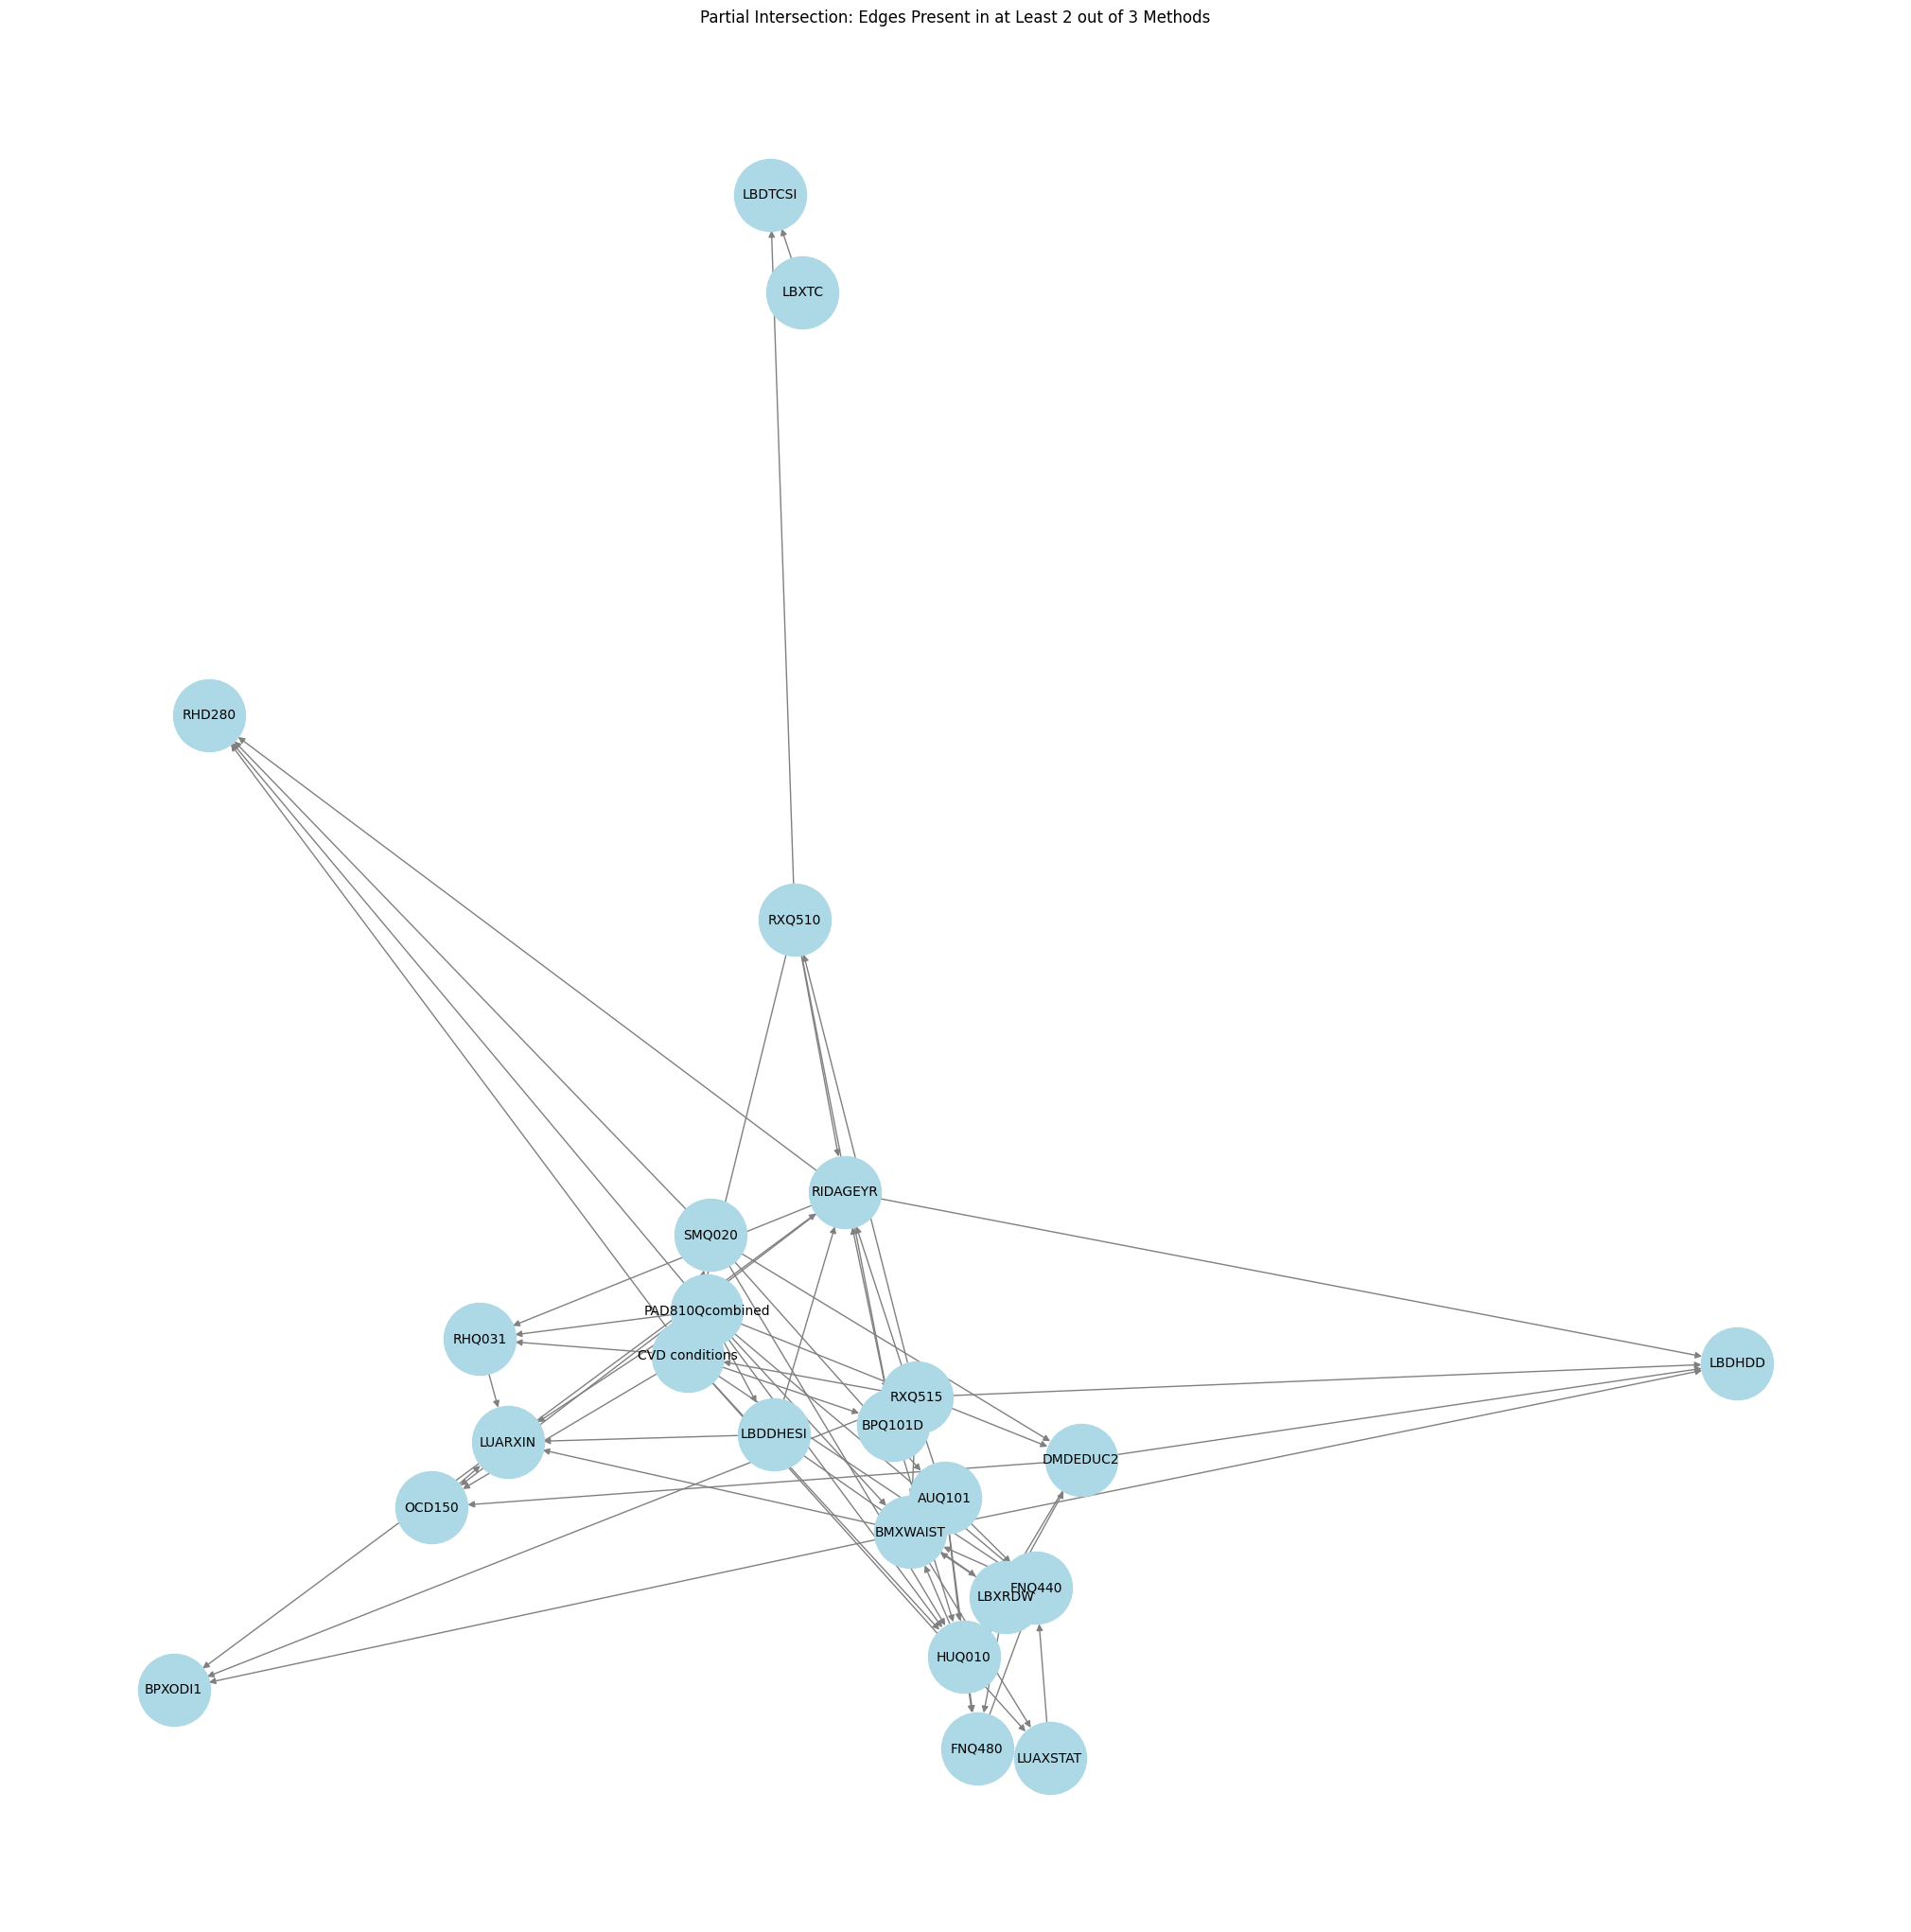

In [13]:
from collections import Counter

# Convert all edge lists to a common format: (source, target)
edges_pc = list(G_pc_cvd.edges())
edges_lingam = list(G_lingam_cvd.edges())
edges_ges = list(G_ges_cvd.edges())

# Combine all edges from all graphs
all_edges = edges_pc + edges_lingam + edges_ges

# Count occurrences of each edge
edge_counts = Counter(all_edges)

# Filter edges that appear in at least 2 graphs
partial_edges = [edge for edge, count in edge_counts.items() if count >= 2]

# Create a new graph with only those partial edges
partial_graph = nx.DiGraph()
partial_graph.add_edges_from(partial_edges)

# Add nodes explicitly (in case some nodes are disconnected)
partial_graph.add_nodes_from(G_pc_cvd.nodes())

# Visualize
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(partial_graph, seed=42)
nx.draw(partial_graph, pos, with_labels=True, node_size=3000,
        node_color="lightblue", edge_color="gray", font_size=10)
plt.title("Partial Intersection: Edges Present in at Least 2 out of 3 Methods")
plt.show()


In [14]:
def extract_causal_roles(graph, node='CVD conditions'):
    return {
        'Direct Causes': sorted(list(graph.predecessors(node))),
        'Indirect Causes': sorted(list(set(nx.ancestors(graph, node)) - set(graph.predecessors(node)))),
        'Effects': sorted(list(graph.successors(node)))
    }

# Suppose you have graphs per disease per method like this
graphs = {
    ('CVD', 'PC'): G_pc_cvd,
    ('CVD', 'LiNGAM'): G_lingam_cvd,
    ('CVD', 'GES'): G_ges_cvd,
    # Add more entries here: e.g., ('CVD', 'PC'): G_cvd_pc, ...
}

# Create the structure for the table
summary = {}

for (disease, method), graph in graphs.items():
    roles = extract_causal_roles(graph, node='CVD conditions')  # or other node for CVD/KIDNEY
    for role_type, variables in roles.items():
        key = role_type
        col = f"{disease} ({method})"
        if key not in summary:
            summary[key] = {}
        summary[key][col] = ', '.join(variables) if variables else '—'

# Convert to DataFrame
df_summary = pd.DataFrame(summary).T  # Transpose so rows are relationship types
df_summary.fillna('—', inplace=True)

# Preview
pd.set_option('display.max_colwidth', None)

# Convert the DataFrame to LaTeX format after adjusting the option.
latex_code = df_summary.to_latex(index=True)

with open("causal_summary_table_cvd.tex", "w") as f:
    f.write(latex_code)

/tmp/ipykernel_1180877/3574075094.py:36: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_code = df_summary.to_latex(index=True)


---

# Combined

---

In [54]:
import pickle
from collections import Counter

# Step 1: Initialize a Counter to track feature appearances
feature_counter = Counter()

# Reading the dictionary from the file
with open('feature_sets_diabetes.pkl', 'rb') as f:
    loaded_feature_sets = pickle.load(f)

for method, features in loaded_feature_sets.items():
    feature_counter.update(features)


features_in_at_least_2_methods_diab = [feature for feature, count in feature_counter.items() if count >= 2]

features_in_at_least_2_methods_diab = [feature for feature in features_in_at_least_2_methods if feature not in ('RXQ050', 'RXQ033', 'BPQ101D')]


feature_counter = Counter()

# Reading the dictionary from the file
with open('feature_sets_cvd.pkl', 'rb') as f:
    loaded_feature_sets = pickle.load(f)

for method, features in loaded_feature_sets.items():
    feature_counter.update(features)


features_in_at_least_2_methods_cvd = [feature for feature, count in feature_counter.items() if count >= 2]

features_in_at_least_2_methods_cvd = [feature for feature in features_in_at_least_2_methods if feature not in ('RXQ050', 'RXQ033', 'BPQ101D')]


feature_counter = Counter()

# Reading the dictionary from the file
with open('feature_sets_kidney.pkl', 'rb') as f:
    loaded_feature_sets = pickle.load(f)

for method, features in loaded_feature_sets.items():
    feature_counter.update(features)


features_in_at_least_2_methods_kd = [feature for feature, count in feature_counter.items() if count >= 2]

features_in_at_least_2_methods_kd = [feature for feature in features_in_at_least_2_methods if feature not in ('RXQ050', 'RXQ033', 'BPQ101D')]

common_features = list(
    (
        set(features_in_at_least_2_methods_cvd)
        & set(features_in_at_least_2_methods_kd)
        & set(features_in_at_least_2_methods_diab)
    )
    | set(features_in_at_least_2_methods_kd)
)

print(f"Features common to all 3 conditions: {sorted(common_features)}")


Features common to all 3 conditions: ['AUQ101', 'BMXWAIST', 'BPXODI1', 'DMDEDUC2', 'FNQ440', 'FNQ480', 'HUQ010', 'LBDDHESI', 'LBDHDD', 'LBDTCSI', 'LBXRDW', 'LBXTC', 'LUARXIN', 'LUAXSTAT', 'OCD150', 'PAD810Qcombined', 'RHD280', 'RHQ031', 'RIDAGEYR', 'RXQ510', 'RXQ515', 'SMQ020']


In [55]:
df = pd.read_csv("NHANES_SAMPLE.csv") 
columns = common_features + ["DIQ010"] 


df["DIQ010"] = df["DIQ010"].apply(lambda x: 1 if x == 1 else 0)

columns = columns + ["KIQ022"] 

df["KIQ022"] = df["KIQ022"].apply(lambda x: 1 if x == 1 else 0)

diagnos_list = ['MCQ160B','MCQ160D', 'MCQ160E', 'MCQ160F','MCQ160C']

df["CVD conditions"] = df[diagnos_list].apply(lambda row: 1 if (row == 1).any() else 0, axis=1)

columns = columns +  ["CVD conditions"]


activity_columns = [("PAD790Q", "PAD790U"), ("PAD810Q", "PAD810U")]  # List of pairs
for freq_col, unit_col in activity_columns:
    if freq_col in df.columns and unit_col in df.columns:
        df[f"{freq_col}combined"] = df[freq_col].astype(str) + "_" + df[unit_col].astype(str)  # Concatenate values
        df.drop([freq_col, unit_col], axis=1, inplace=True)  # Drop original columns

df = df[columns]

df = df.loc[:, df.nunique() > 1]

for col in df.select_dtypes(include=["object", "category"]).columns:
    df[col] = df[col].astype("category").cat.codes

knn_imputer = KNNImputer(n_neighbors=2)
df = df.dropna(axis=1, how='all')
df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)


data = df.to_numpy()
cg = pc(data, alpha=0.05, indep_test=fisherz, max_condition_set=3)



/tmp/ipykernel_1180877/3574699565.py:33: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)
Depth=11, working on node 24: 100%|██████████| 25/25 [00:00<00:00, 1520.18it/s]


{'FNQ440': 'FNQ440', 'RXQ510': 'RXQ510', 'LUARXIN': 'LUARXIN', 'RIDAGEYR': 'RIDAGEYR', 'LUAXSTAT': 'LUAXSTAT', 'AUQ101': 'AUQ101', 'BPXODI1': 'BPXODI1', 'RHD280': 'RHD280', 'LBXTC': 'LBXTC', 'LBDHDD': 'LBDHDD', 'DMDEDUC2': 'DMDEDUC2', 'LBXRDW': 'LBXRDW', 'PAD810Qcombined': 'PAD810Qcombined', 'RXQ515': 'RXQ515', 'LBDTCSI': 'LBDTCSI', 'RHQ031': 'RHQ031', 'HUQ010': 'HUQ010', 'BMXWAIST': 'BMXWAIST', 'OCD150': 'OCD150', 'LBDDHESI': 'LBDDHESI', 'FNQ480': 'FNQ480', 'SMQ020': 'SMQ020', 'DIQ010': 'DIQ010', 'KIQ022': 'KIQ022', 'CVD conditions': 'CVD conditions'}


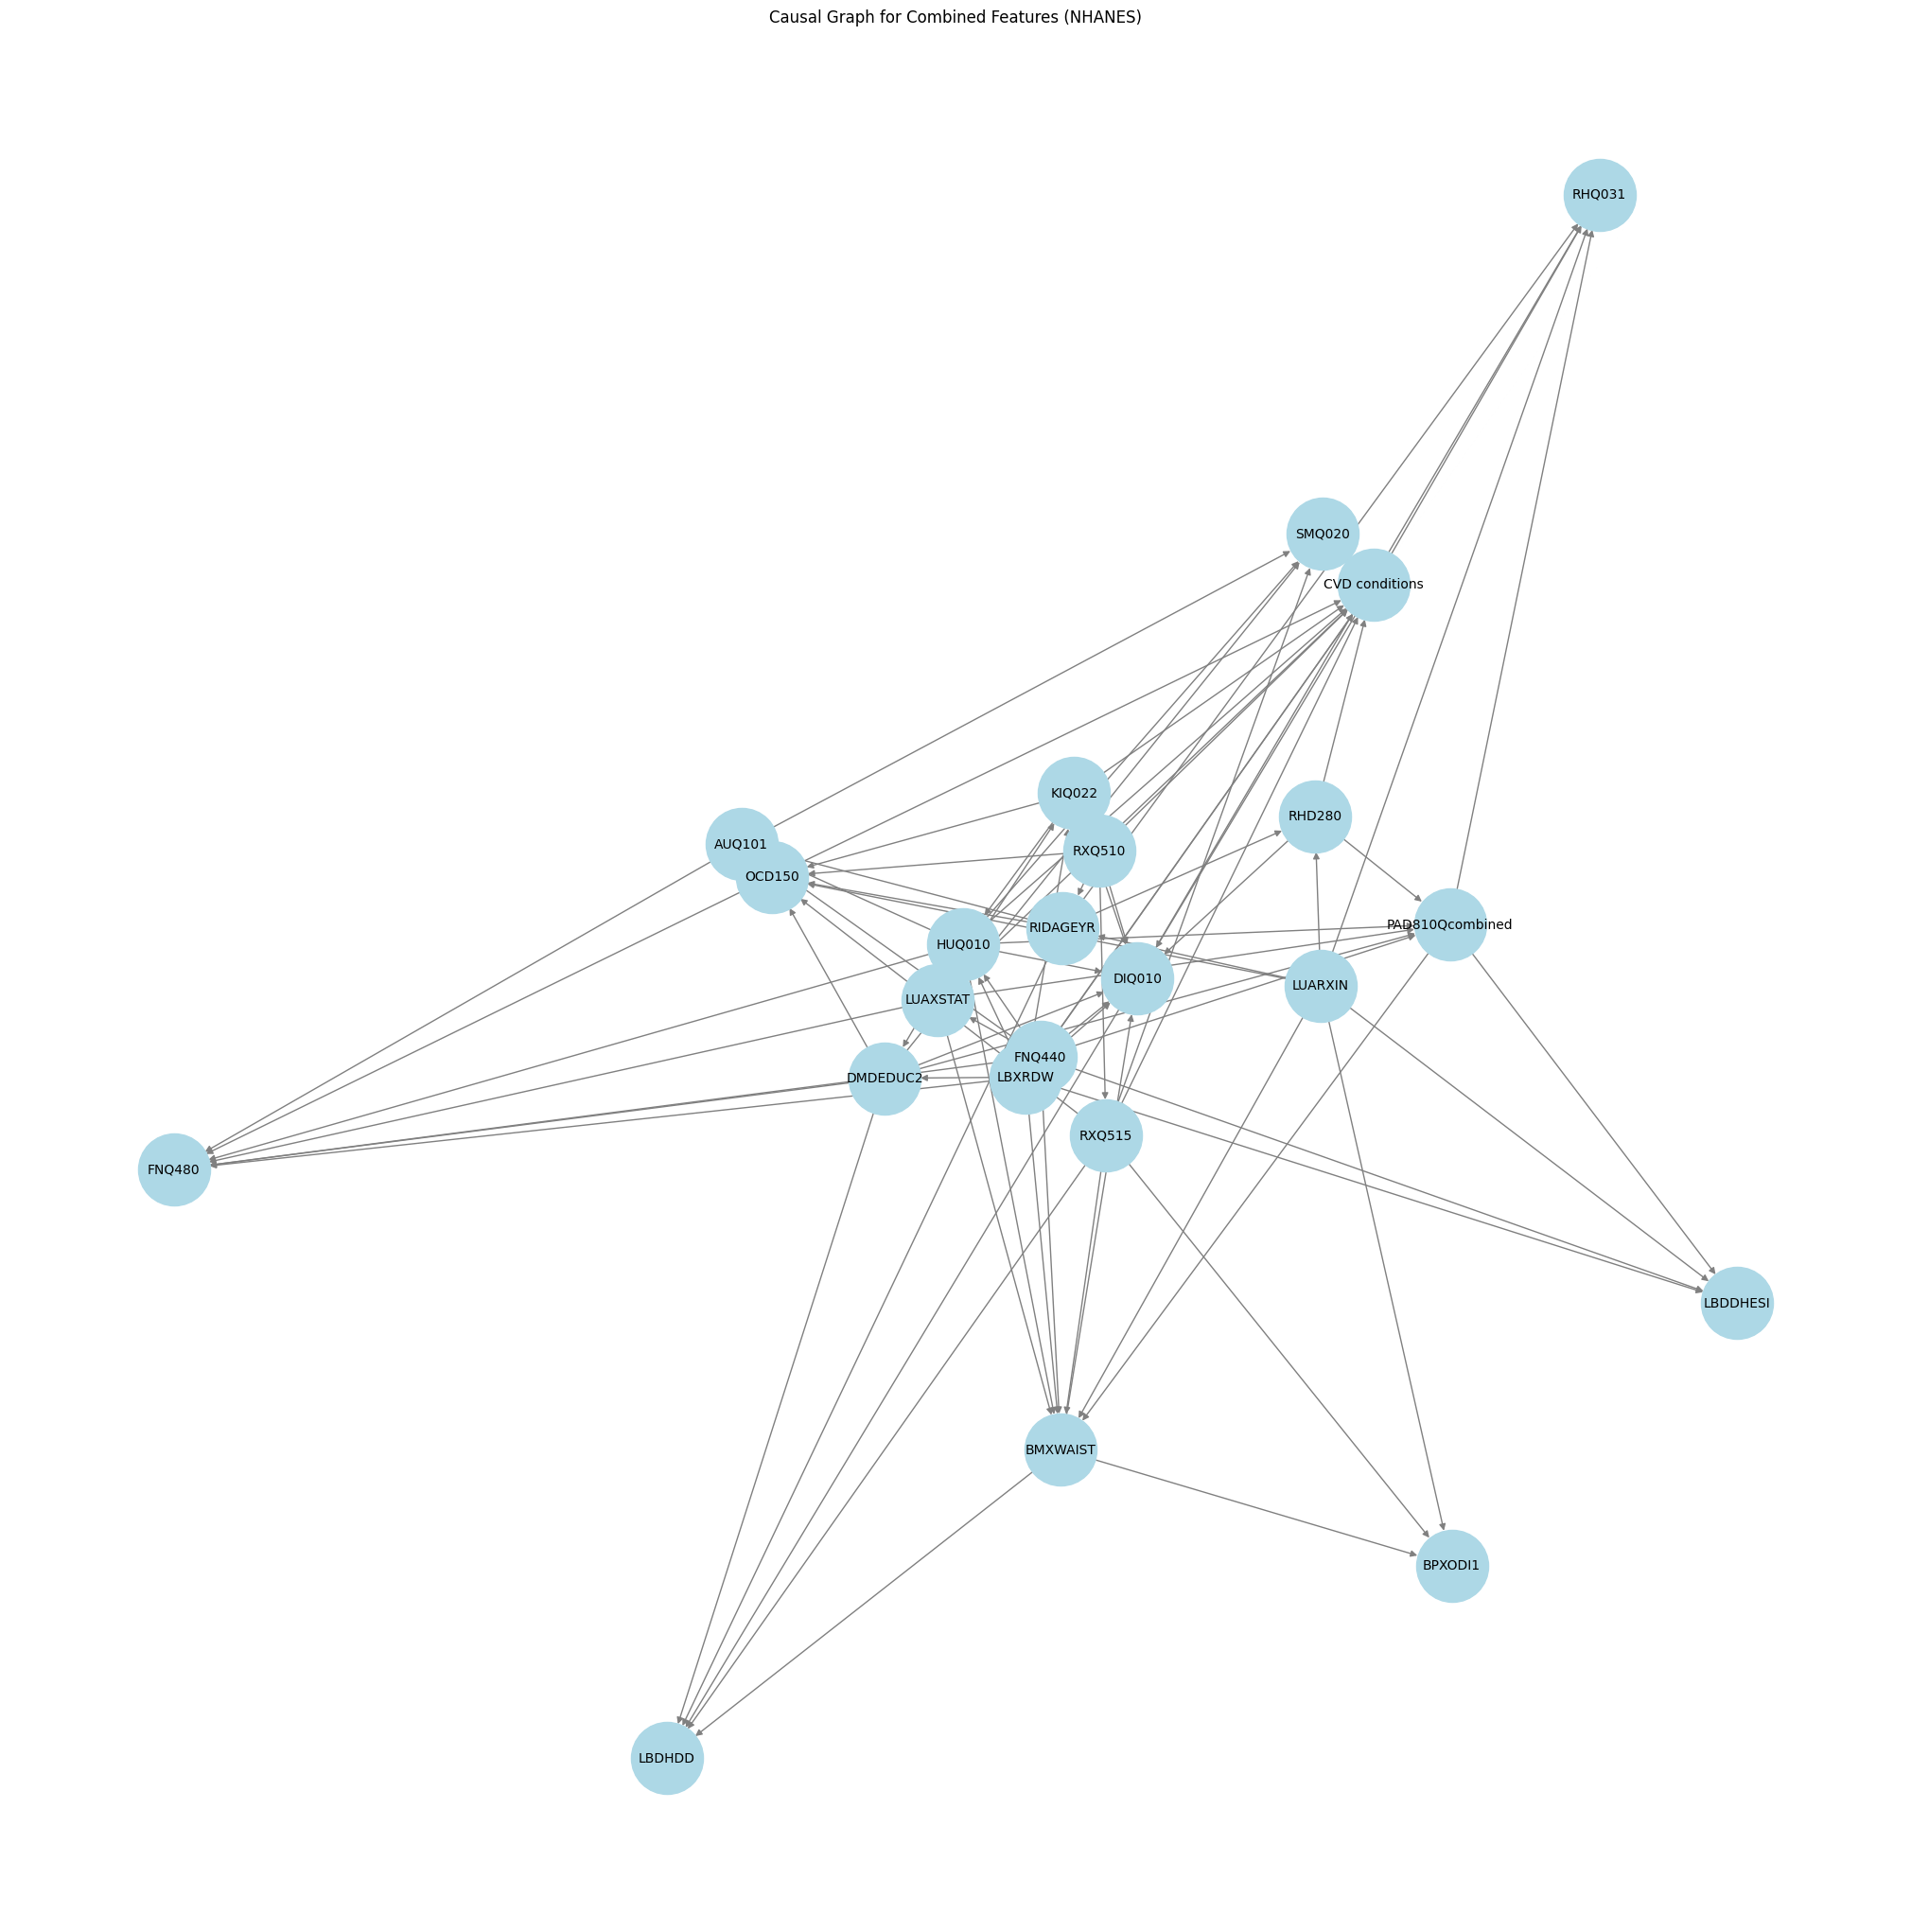

In [56]:
G_pc = nx.DiGraph()  # Create a directed graph
node_labels = {col: col for col in df.columns}  # Map column names to themselves
print(node_labels)

for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if cg.G.graph[i, j] == 1:  # If there is an edge
            feature_i = df.columns[i]  # Get the feature name using the index
            feature_j = df.columns[j]  # Get the feature name using the index
            if feature_i in df.columns and feature_j in df.columns:  # Ensure the feature exists in df.columns
                G_pc.add_edge(feature_i, feature_j)  # Add edge using column names
node_labels = {key: value for key, value in node_labels.items() if key in G_pc.nodes}

pos = nx.spring_layout(G_pc, seed=42)

plt.figure(figsize=(20, 20))
nx.draw(G_pc, pos, labels=node_labels, with_labels=True, node_size=3000,
        node_color="lightblue", edge_color="gray", font_size=10)
plt.title("Causal Graph for Combined Features (NHANES)")
plt.show()

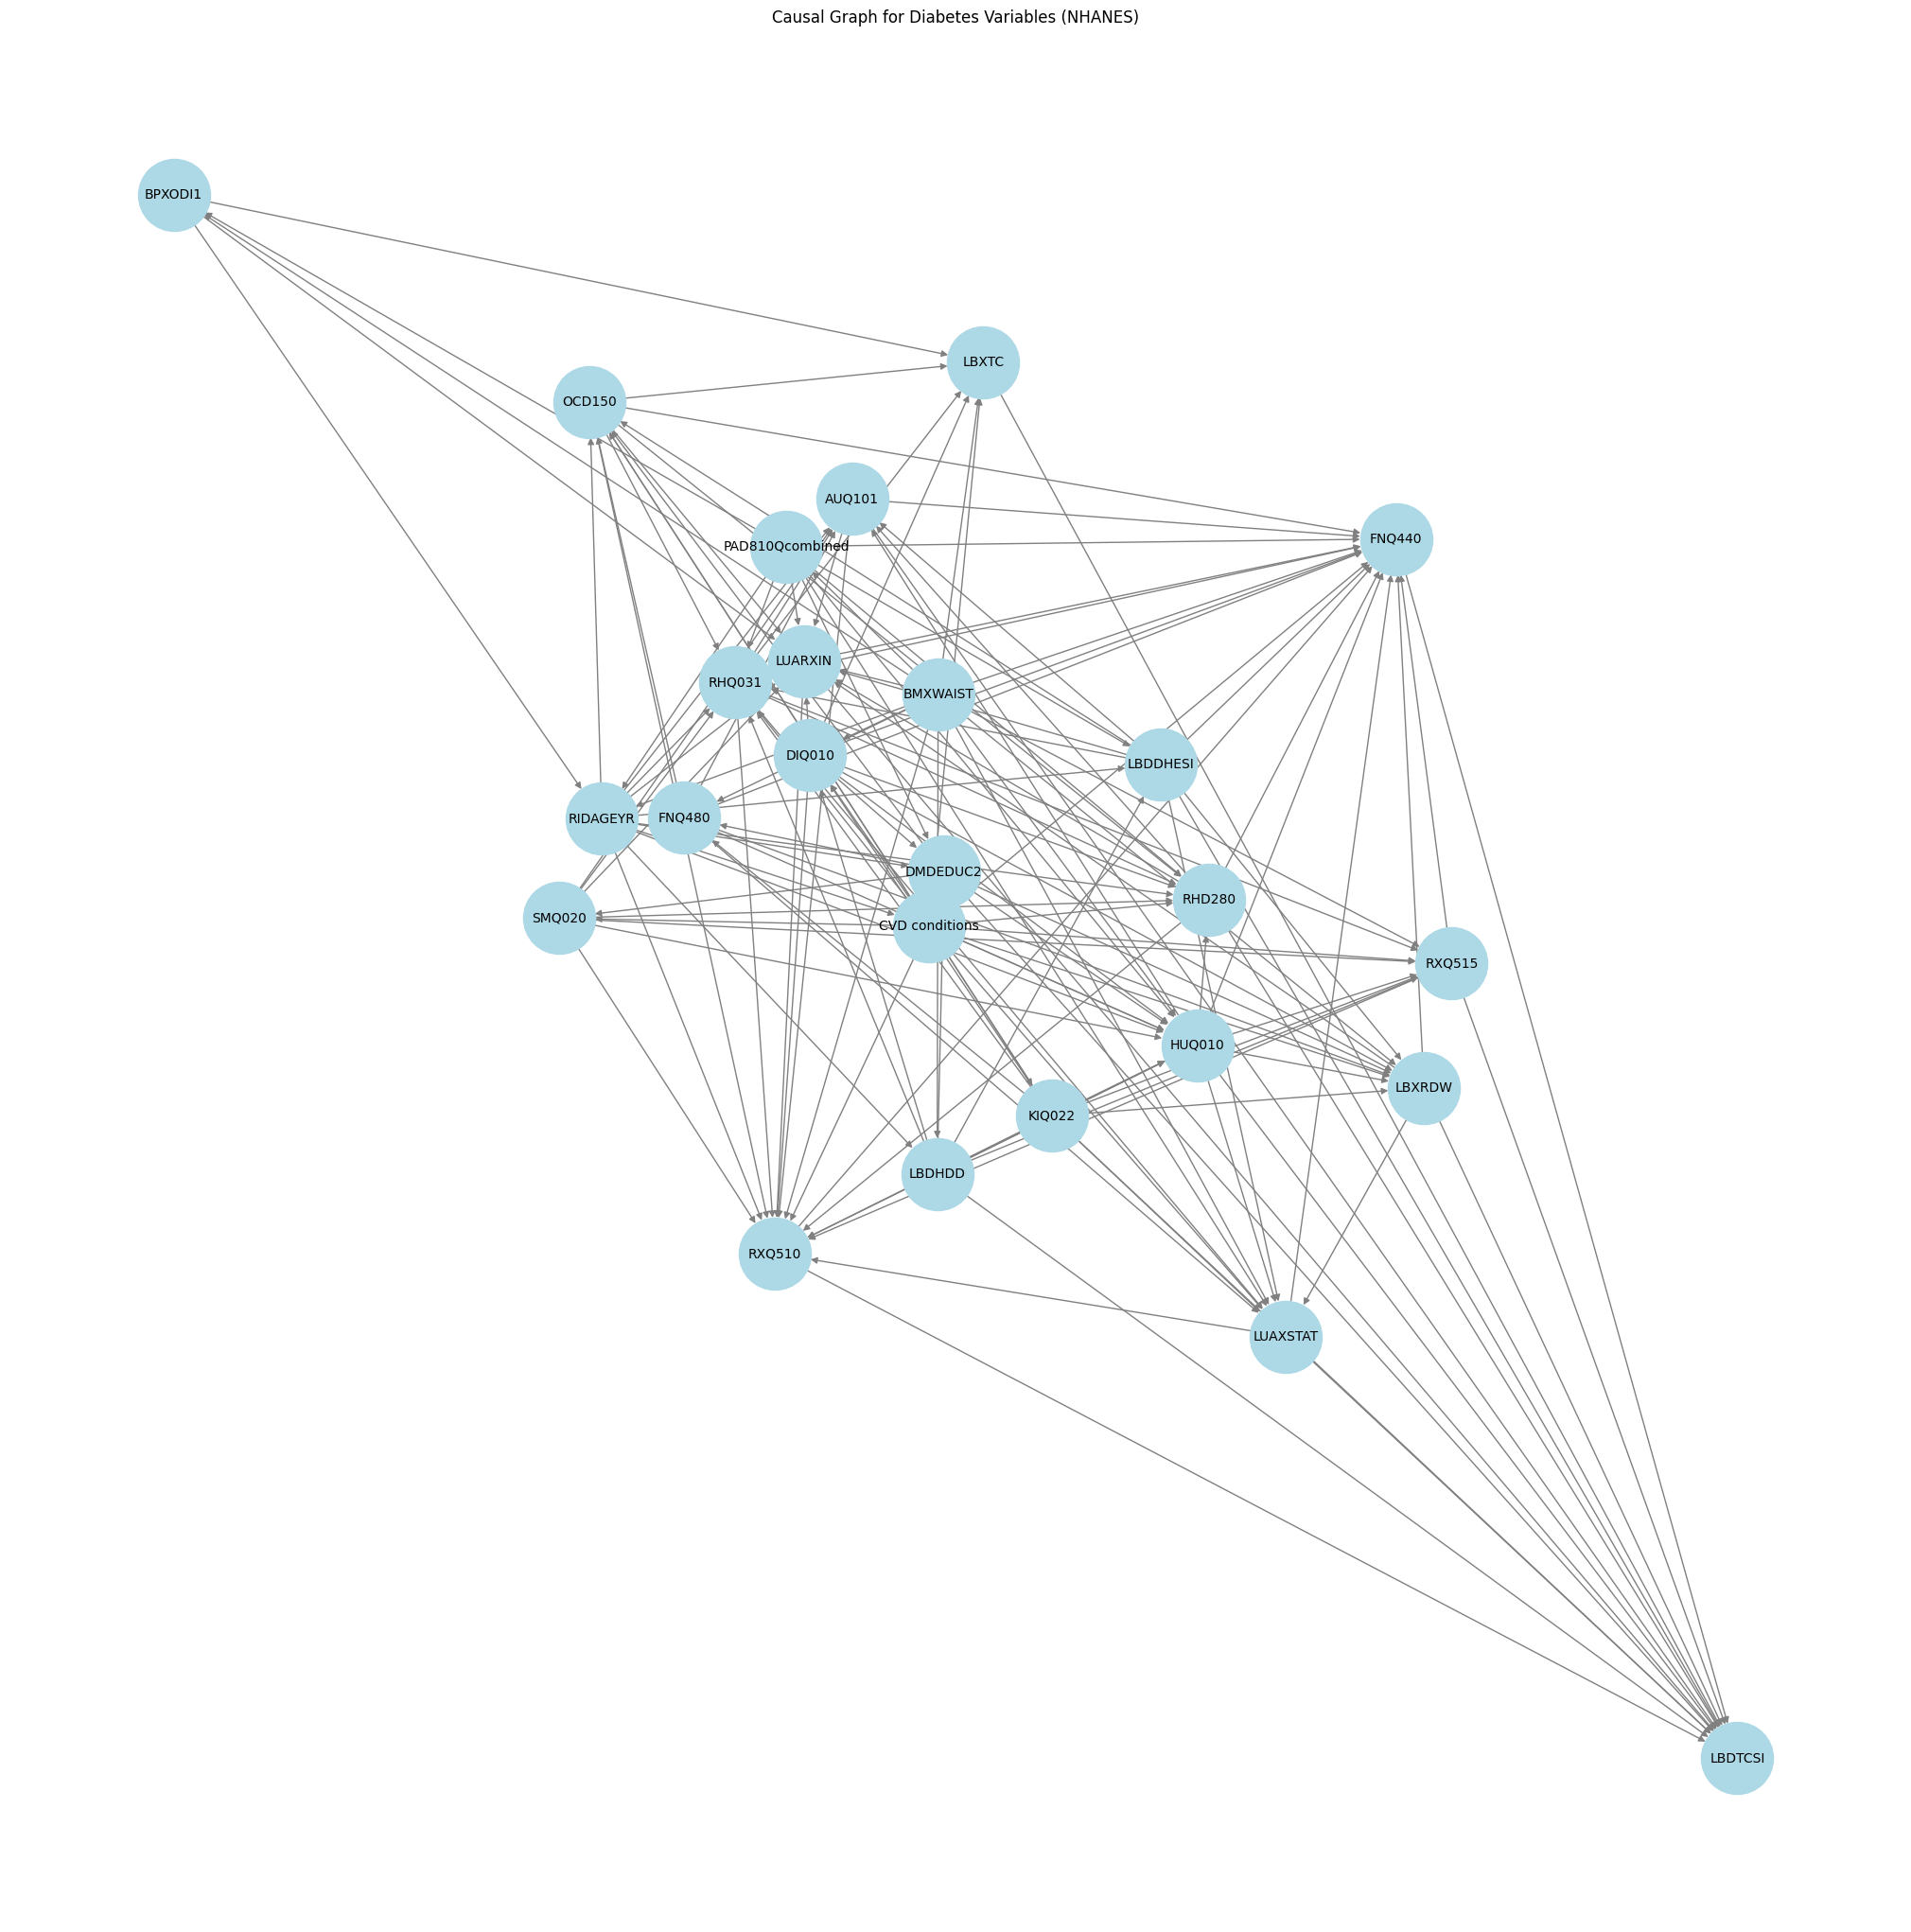

In [57]:
from causallearn.search.FCMBased import lingam

lingam = lingam.ICALiNGAM( random_state=1)
lingam.fit(data)

# Step 10: Get the causal graph from the learned coefficients
edges = lingam.adjacency_matrix_  # This gives you the adjacency matrix representing the causal graph

# Step 11: Convert causal graph to NetworkX graph
G_lingam = nx.DiGraph()  # Create a directed graph
node_labels = {col: col for col in df.columns}  # Use column names as node labels

# Add edges to the graph
for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if edges[i, j] != 0:  # If there is a causal relationship
            G_lingam.add_edge(df.columns[i], df.columns[j])  # Add edge from column i to column j

# Step 12: Generate `pos` for visualization
pos = nx.spring_layout(G_lingam, seed=42)

# Step 13: Visualize the causal graph using column names as labels
plt.figure(figsize=(20, 20))
nx.draw(G_lingam, pos, labels=node_labels, with_labels=True, node_size=3000,
        node_color="lightblue", edge_color="gray", font_size=10)
plt.title("Causal Graph for Diabetes Variables (NHANES)")
plt.show()


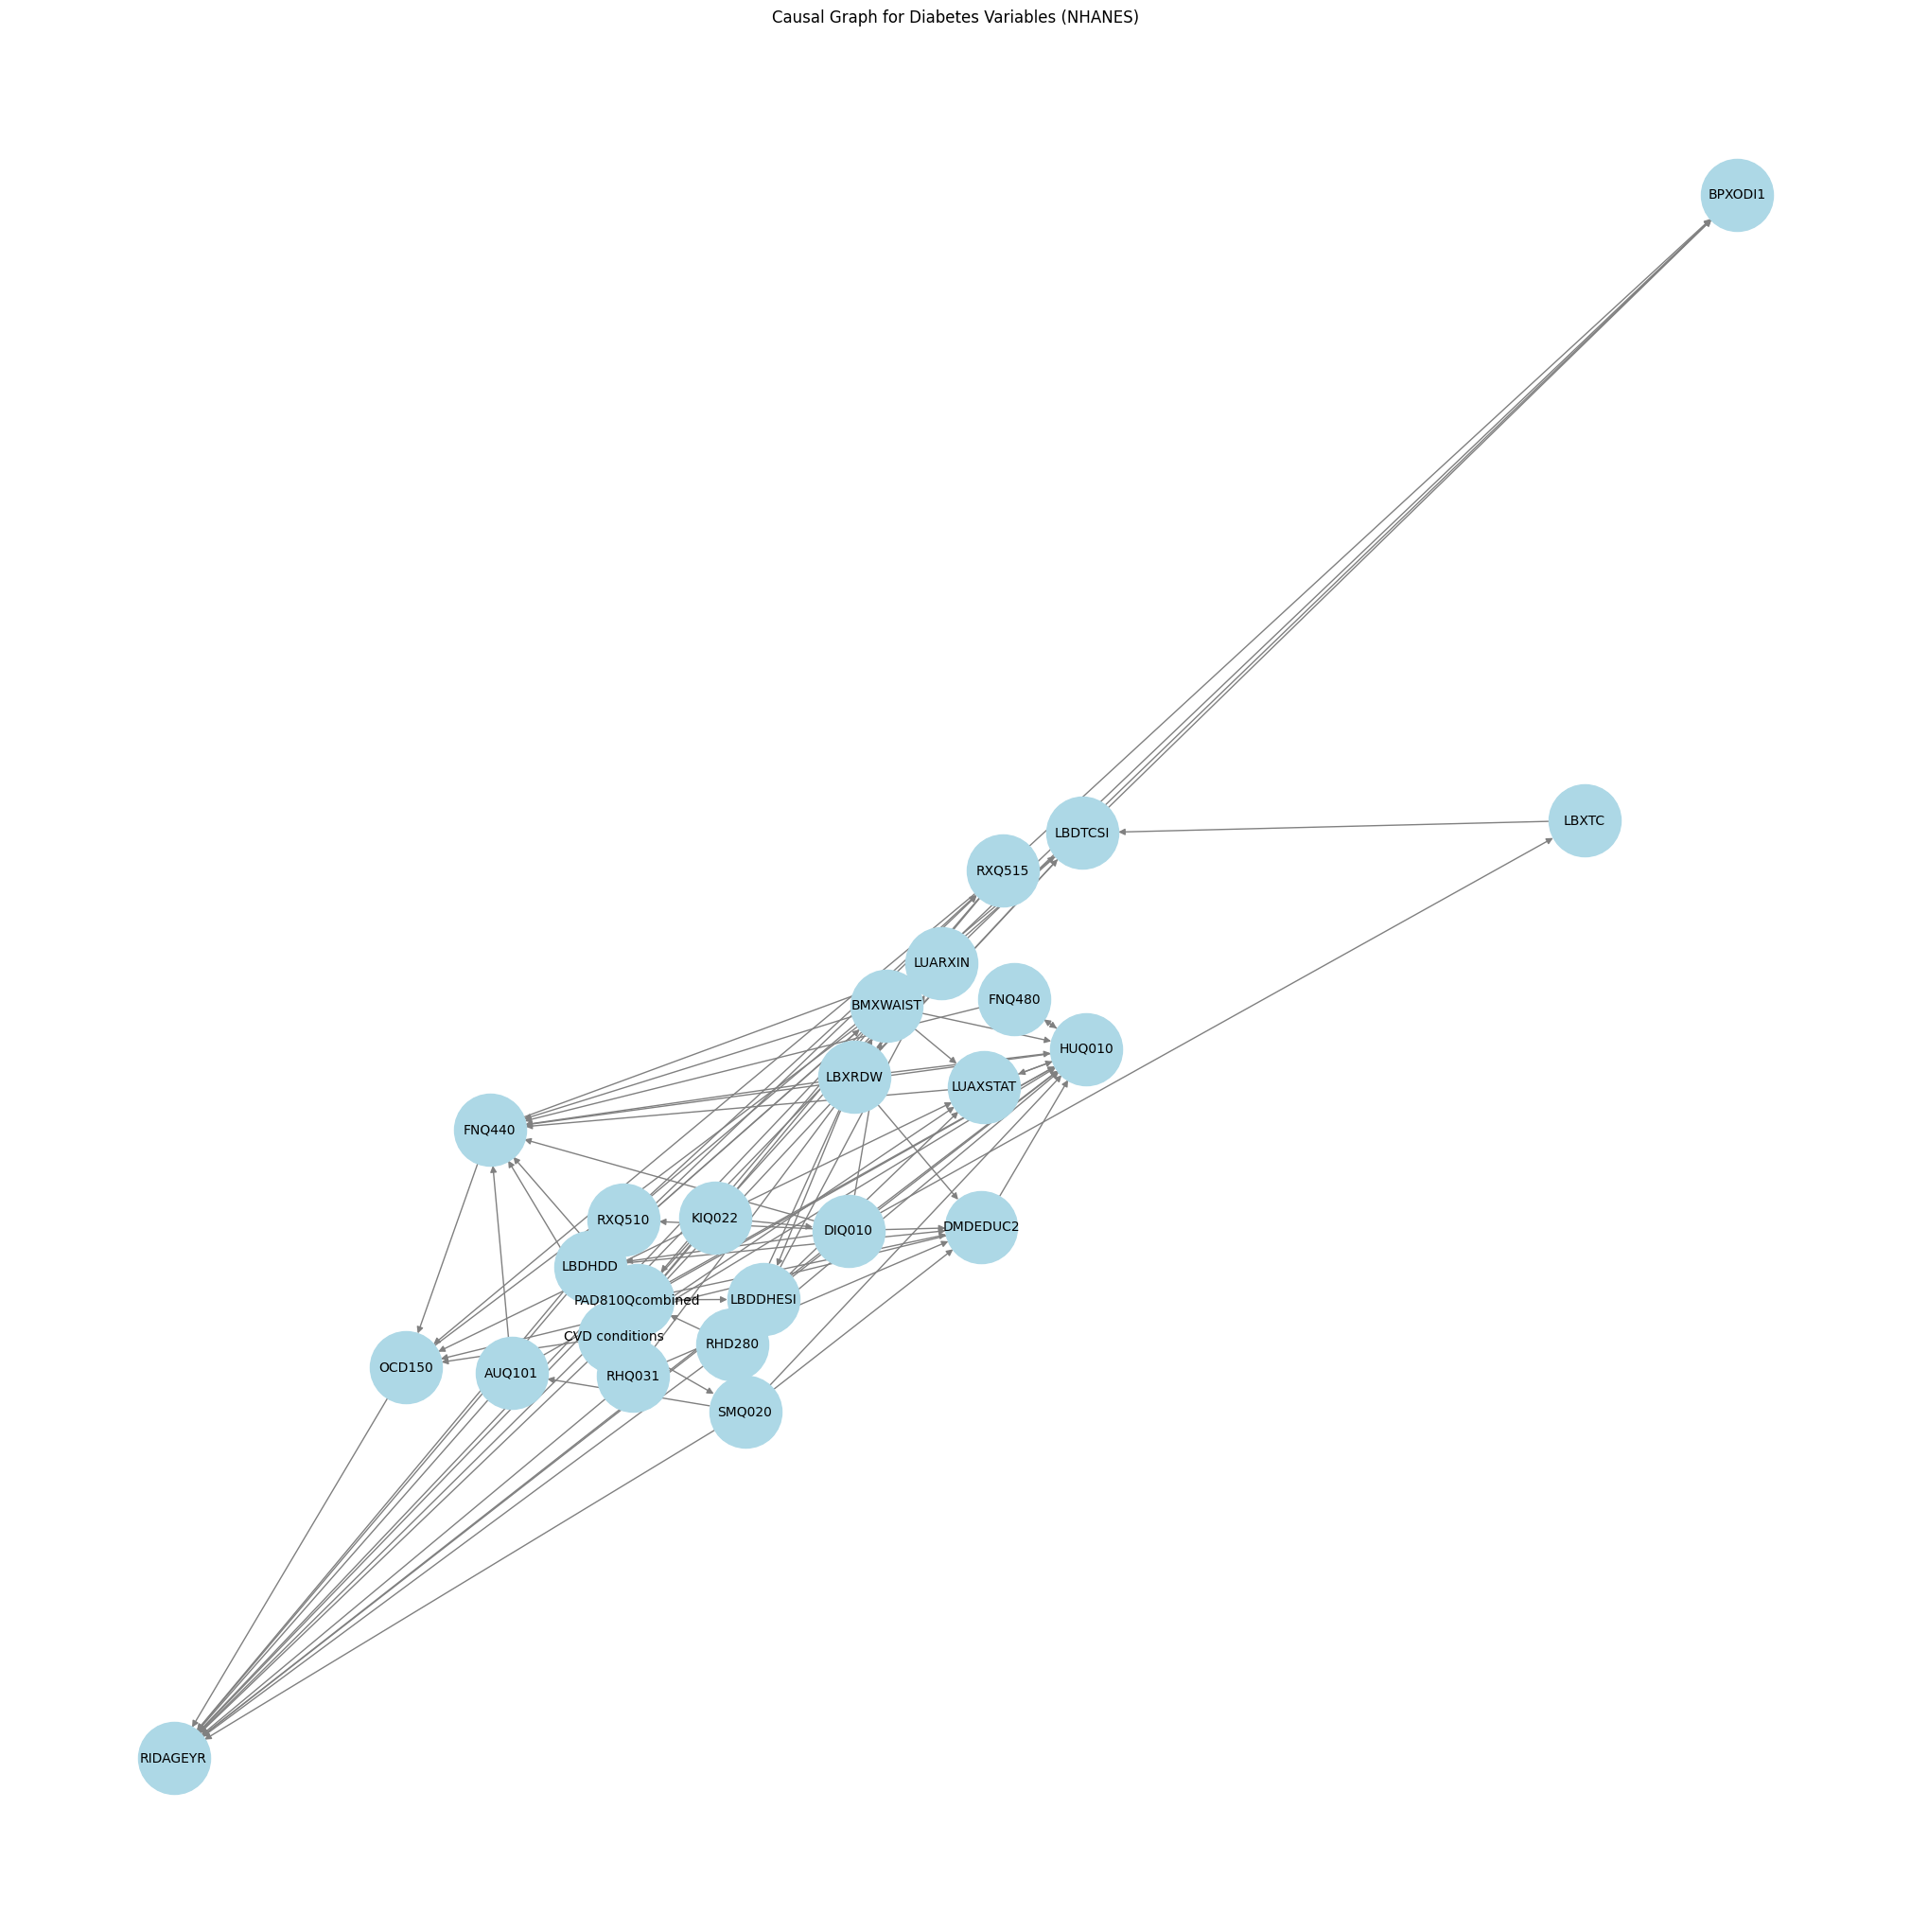

In [58]:
from causallearn.search.ScoreBased.GES import ges


ges = ges(data)

edges = ges["G"].graph 

G_ges = nx.DiGraph()  # Create a directed graph
node_labels = {col: col for col in df.columns}  # Use column names as node labels

# Add edges to the graph
# node_labels = {col: col for col in df.columns}  # Use column names as node labels

# Add edges to the graph
for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if edges[i, j] == 1:  # If there is a causal relationship i → j
            G_ges.add_edge(df.columns[i], df.columns[j])  # Add edge from column i to column j
        elif edges[i, j] == -1:  # If there is a causal relationship j → i
            G_ges.add_edge(df.columns[j], df.columns[i])  # Add edge from column j to column i

# Step 12: Generate `pos` for visualization
pos = nx.spring_layout(G_ges, seed=42)

# Step 13: Visualize the causal graph using column names as labels
plt.figure(figsize=(20, 20))
nx.draw(G_ges, pos, labels=node_labels, with_labels=True, node_size=3000,
        node_color="lightblue", edge_color="gray", font_size=10)
plt.title("Causal Graph for Diabetes Variables (NHANES)")
plt.show()


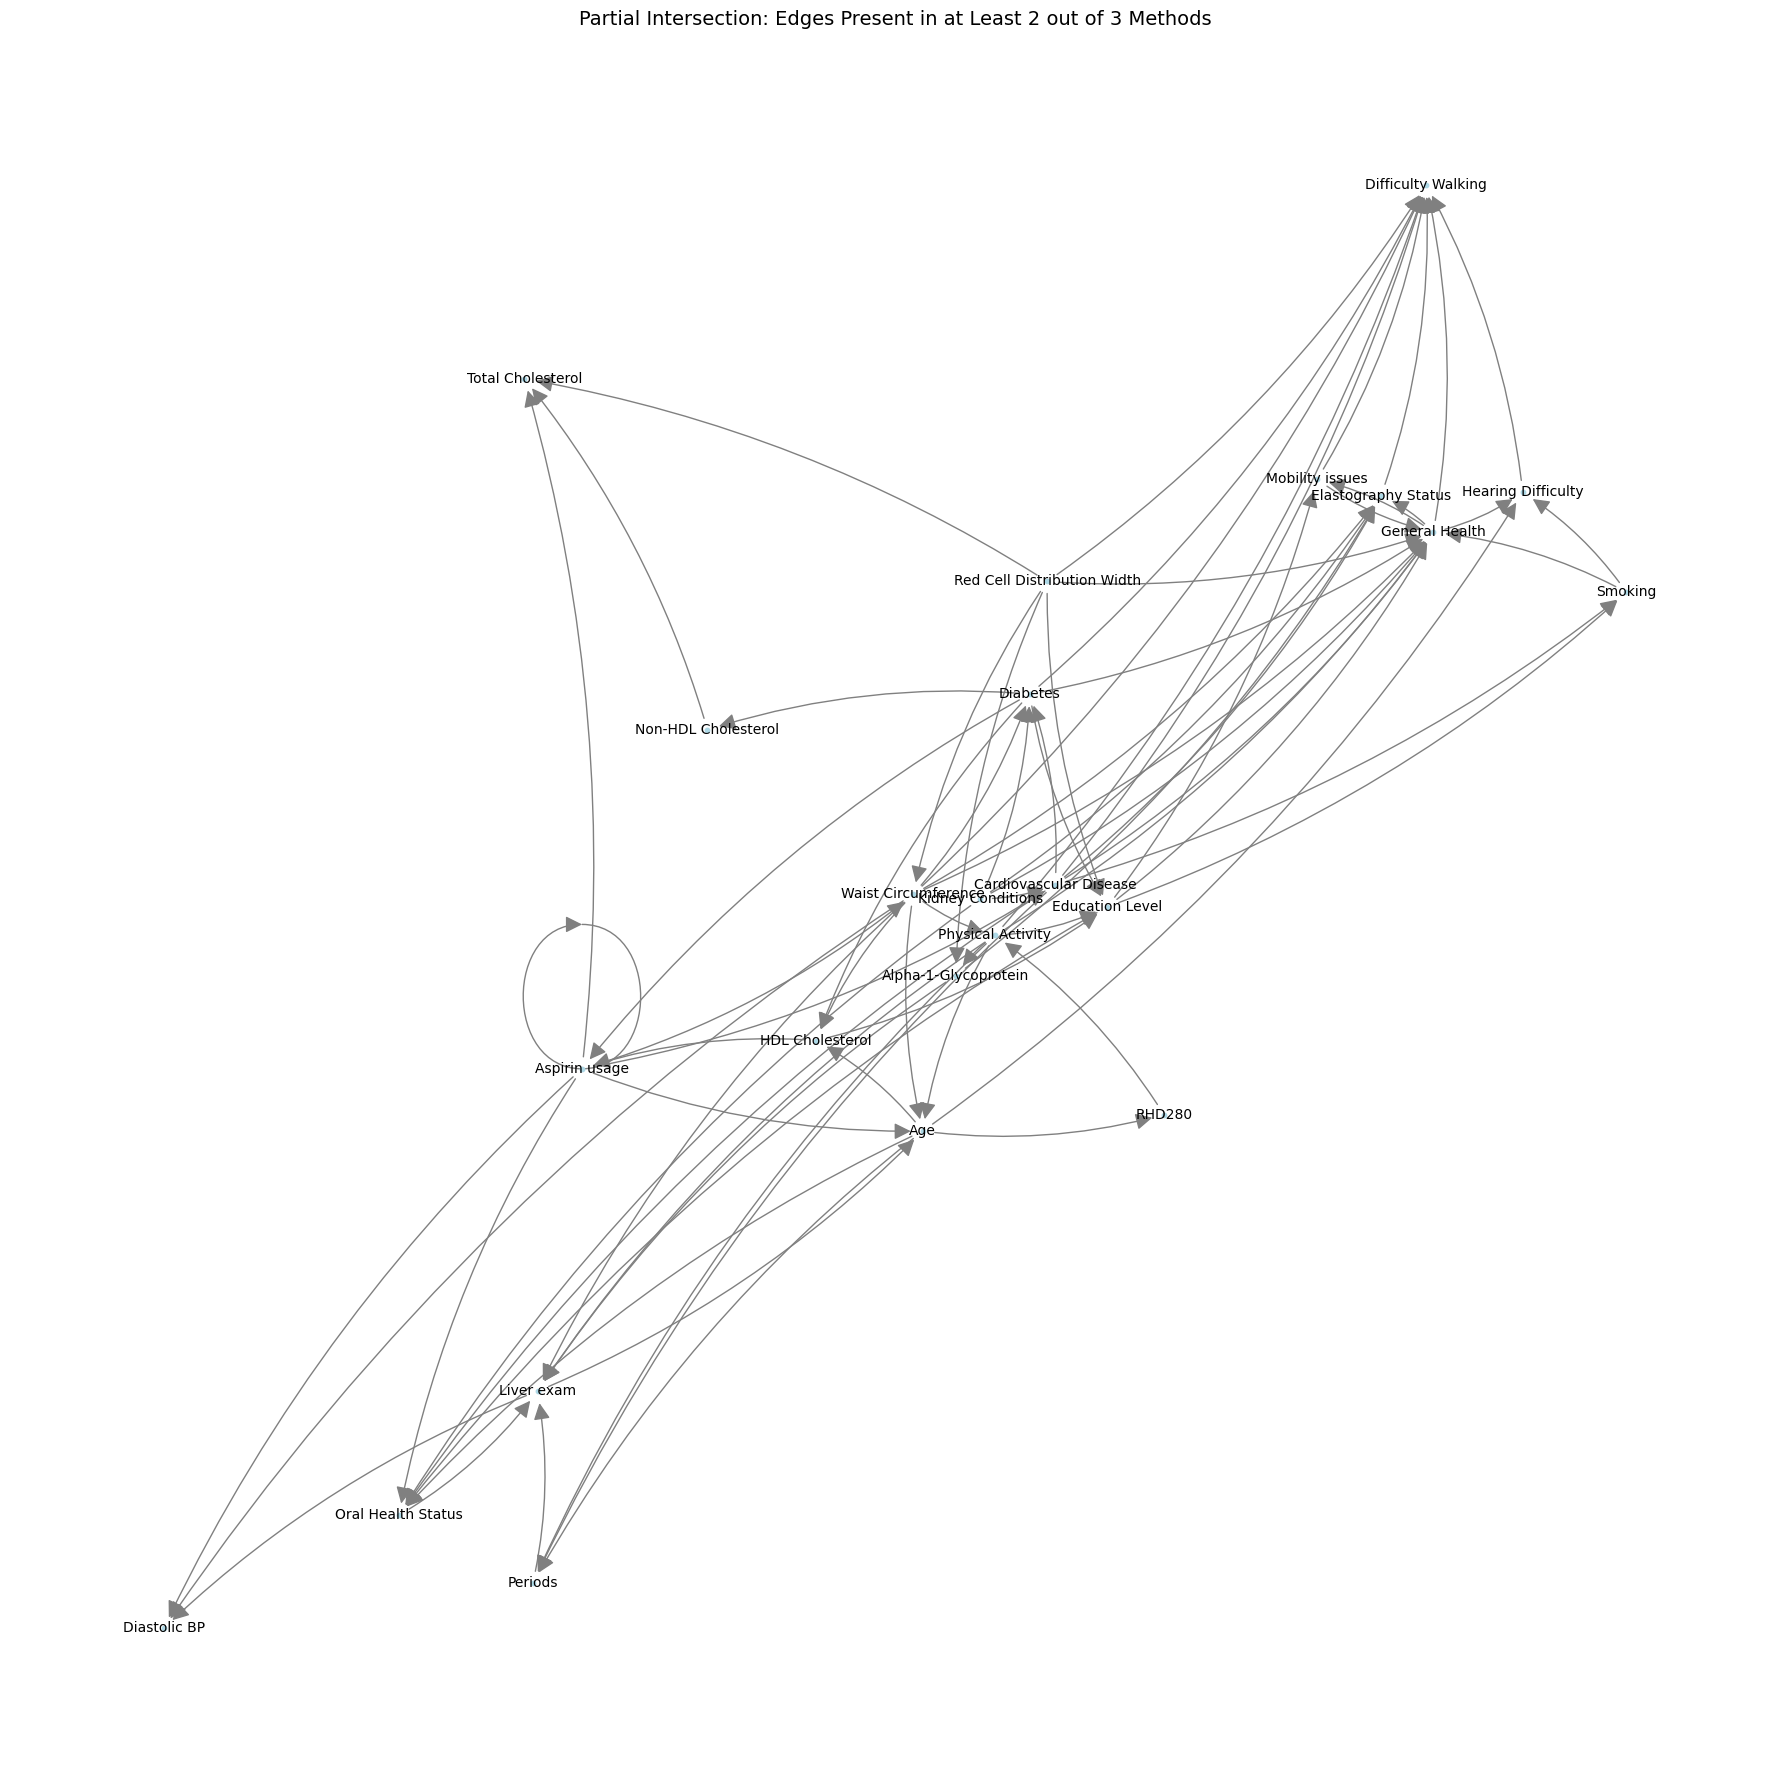

In [90]:
from collections import Counter
rename_dict = {
    'AUQ101': 'Hearing Difficulty',
    'BMXWAIST': 'Waist Circumference',
    'BPXODI1': 'Diastolic BP',
    'DMDEDUC2': 'Education Level',
    'FNQ440': 'Difficulty Walking',
    'FNQ480': 'Mobility issues',
    'HUQ010': 'General Health',
    'LBDDHESI': 'Alpha-1-Glycoprotein',
    'LBDHDD': 'HDL Cholesterol',
    'LBDTCSI': 'Total Cholesterol',
    'LBXRDW': 'Red Cell Distribution Width',
    'LBXTC': 'Non-HDL Cholesterol',
    'LUARXIN': 'Liver exam',
    'LUAXSTAT': 'Elastography Status',
    'OCD150': 'Oral Health Status',
    'PAD810Qcombined': 'Physical Activity',
    'RHQ031': 'Periods',
    'RIDAGEYR': 'Age',
    'RXQ510': 'Aspirin usage',
    'RXQ515': 'Aspirin usage',
    'SMQ020': 'Smoking',
    'DIQ010': 'Diabetes',
    'KIQ022': 'Kidney Conditions',
    'CVD conditions': 'Cardiovascular Disease'
}

# Convert all edge lists to a common format: (source, target)
edges_pc = list(G_pc.edges())
edges_lingam = list(G_lingam.edges())
edges_ges = list(G_ges.edges())

# Combine all edges from all graphs
all_edges = edges_pc + edges_lingam + edges_ges

# Count occurrences of each edge
edge_counts = Counter(all_edges)

# Filter edges that appear in at least 2 graphs
partial_edges = [edge for edge, count in edge_counts.items() if count >= 2]

# Create a new graph with only those partial edges
partial_graph = nx.DiGraph()
partial_graph.add_edges_from(partial_edges)

# Add nodes explicitly (in case some nodes are disconnected)
# partial_graph.add_nodes_from(G_pc_cvd.nodes())

# Create a copy of your graph with renamed nodes
partial_graph = nx.relabel_nodes(partial_graph, rename_dict)


plt.figure(figsize=(18, 18))
pos = nx.spring_layout(partial_graph, seed=12, k=0.3)

# Draw nodes
nx.draw_networkx_nodes(partial_graph, pos, node_size=10, node_color="lightblue")

# Draw directed edges with better arrows
nx.draw_networkx_edges(
    partial_graph,
    pos,
    edge_color="gray",
    arrows=True,
    arrowsize=25,  # 🔥 make arrowheads larger!
    connectionstyle='arc3,rad=0.1',  # optional: curved arrows for readability
)

# Draw labels
nx.draw_networkx_labels(partial_graph, pos, font_size=10)

plt.title("Partial Intersection: Edges Present in at Least 2 out of 3 Methods", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


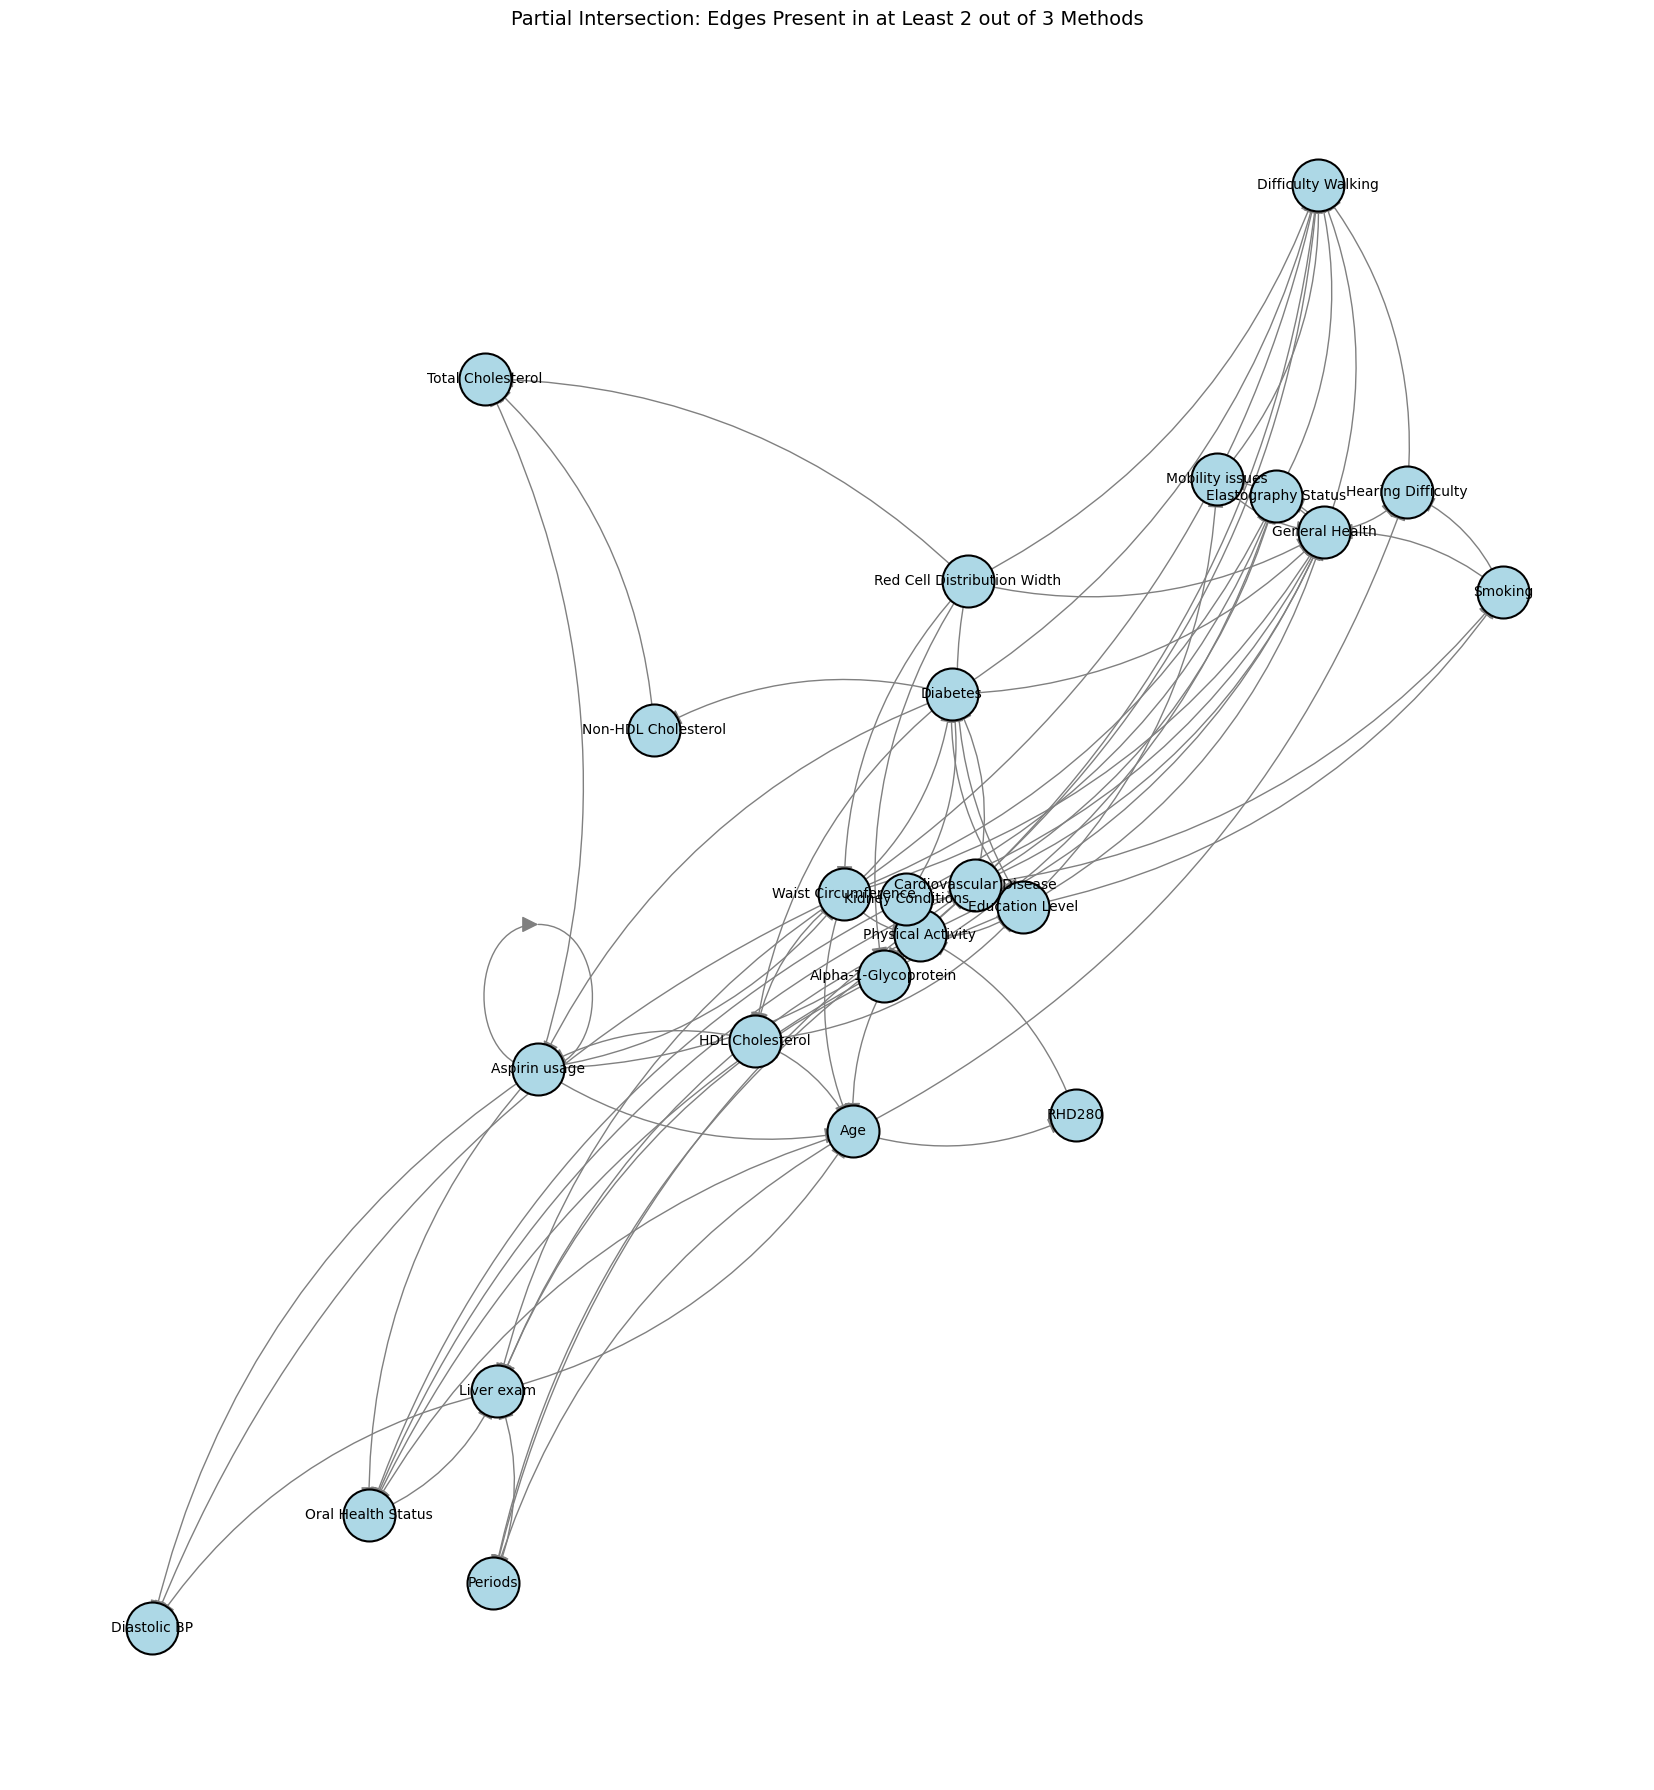

In [91]:
plt.figure(figsize=(18, 18))
pos = nx.spring_layout(partial_graph, seed=12, k=0.3)

ax = plt.gca()  # get current axes

# Draw nodes
nx.draw_networkx_nodes(
    partial_graph, pos,
    node_size=1400,
    node_color="lightblue",
    edgecolors="black",  # adds black outline
    linewidths=1.5
)

# Draw curved arrows
nx.draw_networkx_edges(
    partial_graph, pos,
    edge_color="gray",
    arrows=True,
    arrowsize=25,
    connectionstyle='arc3,rad=0.2',  # make arrows curved and distinct
)

# Draw node labels
nx.draw_networkx_labels(
    partial_graph, pos,
    font_size=10,
    font_color="black"
)

# Optional: improve spacing/layout
ax.set_title("Partial Intersection: Edges Present in at Least 2 out of 3 Methods", fontsize=14)
ax.set_aspect('equal')
plt.axis('off')
plt.tight_layout()
plt.show()


In [79]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

# Use the relabeled graph
G = partial_graph

# Graphviz layout
pos = graphviz_layout(G, prog='dot')  # use 'dot' for hierarchy; try 'neato' or 'twopi' for radial

plt.figure(figsize=(16, 12))

# Draw with proper arrows
nx.draw(G, pos,
        with_labels=True,
        arrows=True,
        node_size=1600,
        node_color="lightblue",
        edge_color="gray",
        font_size=9,
        font_weight='bold',
        linewidths=1.5,
        edgecolors='black',
        arrowsize=20)

plt.title("Causal Graph: Partial Intersection (2 out of 3 Methods)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()



ImportError: requires pygraphviz http://pygraphviz.github.io/

In [92]:
import networkx as nx

def extract_causal_roles(graph, node):
    if node not in graph.nodes:
        print(f"Node {node} not found in graph.")
        return None
    parents = sorted(list(graph.predecessors(node)))
    children = sorted(list(graph.successors(node)))
    indirect = sorted(list(set(nx.ancestors(graph, node)) - set(parents)))
    
    return {
        'Direct Causes (Parents)': parents,
        'Indirect Causes (Ancestors excl. direct)': indirect,
        'Effects (Children)': children
    }


    # 'DIQ010': 'Diabetes',
    # 'KIQ022': 'Kidney Conditions',
    # 'CVD conditions': 'Cardiovascular Disease'


for node in ['Diabetes', 'Kidney Conditions', 'Cardiovascular Disease']:  # replace 'CVD' with actual node name if different
    print(f"\n--- Causal roles for {node} ---")
    roles = extract_causal_roles(partial_graph, node)
    if roles:
        for role, features in roles.items():
            print(f"{role}: {features if features else '—'}")



--- Causal roles for Diabetes ---
Direct Causes (Parents): ['Cardiovascular Disease', 'Kidney Conditions', 'Waist Circumference']
Indirect Causes (Ancestors excl. direct): ['Age', 'Alpha-1-Glycoprotein', 'Aspirin usage', 'Education Level', 'HDL Cholesterol', 'Liver exam', 'Oral Health Status', 'Periods', 'Physical Activity', 'RHD280', 'Red Cell Distribution Width']
Effects (Children): ['Aspirin usage', 'Difficulty Walking', 'Education Level', 'General Health', 'HDL Cholesterol', 'Non-HDL Cholesterol']

--- Causal roles for Kidney Conditions ---
Direct Causes (Parents): —
Indirect Causes (Ancestors excl. direct): —
Effects (Children): ['Cardiovascular Disease', 'Diabetes', 'Elastography Status', 'General Health', 'Oral Health Status']

--- Causal roles for Cardiovascular Disease ---
Direct Causes (Parents): ['Aspirin usage', 'Kidney Conditions']
Indirect Causes (Ancestors excl. direct): ['Age', 'Alpha-1-Glycoprotein', 'Diabetes', 'Education Level', 'HDL Cholesterol', 'Liver exam', 'Ora

In [95]:
import networkx as nx

def extract_causal_roles(graph, node):
    if node not in graph.nodes:
        print(f"Node {node} not found in graph.")
        return None
    parents = sorted(list(graph.predecessors(node)))
    children = sorted(list(graph.successors(node)))
    indirect = sorted(list(set(nx.ancestors(graph, node)) - set(parents)))
    
    return {
        'Direct Causes (Parents)': parents,
        'Indirect Causes (Ancestors excl. direct)': indirect,
        'Effects (Children)': children
    }


for node in ['General Health']:  # replace 'CVD' with actual node name if different
    print(f"\n--- Causal roles for {node} ---")
    roles = extract_causal_roles(partial_graph, node)
    if roles:
        for role, features in roles.items():
            print(f"{role}: {features if features else '—'}")



--- Causal roles for General Health ---
Direct Causes (Parents): ['Cardiovascular Disease', 'Diabetes', 'Education Level', 'Kidney Conditions', 'Mobility issues', 'Physical Activity', 'Red Cell Distribution Width', 'Smoking', 'Waist Circumference']
Indirect Causes (Ancestors excl. direct): ['Age', 'Alpha-1-Glycoprotein', 'Aspirin usage', 'HDL Cholesterol', 'Liver exam', 'Oral Health Status', 'Periods', 'RHD280']
Effects (Children): ['Difficulty Walking', 'Elastography Status', 'Hearing Difficulty', 'Mobility issues']
